# Mandus Hjelm:  Project Generative Adversarial Network, GAN

In [1]:
import tensorflow as tf
from tensorflow import keras
from utils import *
from sklearn.metrics import confusion_matrix
from datetime import datetime
import imageio
from skimage import img_as_ubyte

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv3D, Conv2D, Conv1D, Convolution2D, Deconvolution2D, Cropping2D, UpSampling2D
from keras.layers import Input, Conv2DTranspose, ConvLSTM2D, TimeDistributed
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers import Concatenate, concatenate, Reshape
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.layers import Input, merge, GaussianNoise
from keras.regularizers import l2
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout, LeakyReLU, AveragePooling2D
import keras.backend as kb
from keras.initializers import RandomNormal

creating network model using gpu 1


In [2]:
class GANModel():
    def __init__(self, batch_size=32, inputShape=(128, 128, 3), dropout_prob=0.25): 
        self.batch_size = batch_size
        self.inputShape = inputShape
        self.dropout_prob = dropout_prob

        # Calculate the shape of patches
        patch = int(self.inputShape[0] / 2**4)
        self.disc_patch = (patch, patch, 1)
  
        # Build and compile the discriminator
        #optDisc = Adam(0.001, 0.5)
        optGEN = Adam(0.001, 0.5)
        optDisc = SGD(0.01)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optDisc,metrics=['accuracy'])
 
        # Build the generator
        self.generator = self.build_generator()

        # Input images and their conditioning images
        first_frame = Input(shape=self.inputShape)
        last_frame = Input(shape=self.inputShape)

        # By conditioning on the first frame generate a fake version of the last frame
        fake_last_frame = self.generator(first_frame)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        
        # Discriminators determines validity of fake and condition first image pairs
        valid = self.discriminator([fake_last_frame, first_frame])

        self.combined = Model(inputs=[last_frame, first_frame], outputs=[valid, fake_last_frame])
        self.combined.compile(loss=['mse', 'mae'], # mean squared and mean absolute errors
                              loss_weights=[1, 30],
                              optimizer=optGEN)

    def build_generator(self):
        
        inputs = Input(shape=self.inputShape)
        momentumVar = 0.8
        GenActivation ='sigmoid'
        dropoutVar = 0.20 
        # Number of filters in the first layer of Generator and Discriminator
        filtersize = 64
        init = RandomNormal(mean=0.0, stddev=0.02)
        
        def down_sample(layer_input, filters, k_size=4, bn=True,dropoutBoool=False,
                        kernel_initializer='he_normal',strides=2 ):
            """Layers used during downsampling"""
            convLayer = Conv2D(filters, kernel_size=k_size, strides=strides, padding='same', 
                               kernel_initializer=kernel_initializer)(layer_input)
            if bn:
                convLayer = BatchNormalization(momentum=momentumVar)(convLayer)
            if dropoutBoool:
                convLayer = Dropout(dropoutVar)(convLayer)
            #convLayer = LeakyReLU(alpha=0.2)(convLayer)
            convLayer = Activation('relu')(convLayer)
            return convLayer
        
        def up_sample(layer_input, skip_input, filters, k_size=(5,5), dropoutBoool=False, bn=True):
            """Layers used during upsampling"""
            #uplayer = UpSampling2D(size=2)(layer_input)
            #uplayer = Conv2D(filters, kernel_size=k_size, strides=1, padding='same', activation='relu')(uplayer)
            uplayer= Conv2DTranspose(filters, kernel_size=k_size, strides=(2,2),activation="relu", padding='same',
                                     kernel_initializer='he_normal')(layer_input)
            if bn:
                uplayer = BatchNormalization(momentum=momentumVar)(uplayer)
            if dropoutBoool:
                upLayer = Dropout(dropoutVar)(uplayer)
            uplayer = Concatenate()([uplayer, skip_input])
            return uplayer

                # Downsampling
        start = Conv2D( filters =filtersize , kernel_size=3, strides=1, padding='same', activation='relu',
                       kernel_initializer = init)(inputs)
        d1 = down_sample(start, filtersize, bn=False, dropoutBoool=False)
        d2 = down_sample(d1, filtersize*2,dropoutBoool=False)
        #d21 = down_sample(d2, filtersize*2,strides=1)
        d3 = down_sample(d2, filtersize*4,dropoutBoool=False)
        #d4 = down_sample(d3, filtersize*8,dropoutBoool=False)
        #d41= down_sample(d4, filtersize*2,strides=1)
        #d5 = down_sample(d4, filtersize*8)
        #d6 = down_sample(d5, filtersize*8,bn=True)
        #d7 = down_sample(d6, filtersize*8)

        # Upsampling
        #u1 = up_sample(d7, d6, filtersize*8)
        #u1= Dense(8,activation="relu",input_dim=filtersize*8)(u1)
        #u2 = up_sample(d6, d5, filtersize*8)
        #u2= Dense(8,activation="relu",input_dim=filtersize*8)(d5)
        #u3 = up_sample(d5, d4, filtersize*8)
        #u4 = up_sample(d4, d3, filtersize*4,dropoutBoool=True)
        u5 = up_sample(d3, d2, filtersize*2,dropoutBoool=True)
        u6 = up_sample(u5, d1, filtersize,dropoutBoool=True)
        u7 = up_sample(u6,start,filtersize, dropoutBoool=False,bn=False)
        
        nbr_img_channels = self.inputShape[2]
        print(nbr_img_channels)
        outputs = Conv2D(nbr_img_channels, (1, 1), activation=GenActivation)(u7)

        model = Model(inputs=inputs, outputs=outputs, name='Generator')
        model.summary() 
        return model

    def build_discriminator(self):
  
        last_img = Input(shape=self.inputShape)
        first_img = Input(shape=self.inputShape)
        
        DiscAct =  'softmax'
        momentumVariable2 = 0.8
        alpha = 0.2
        
        # Concatenate image and conditioning image by channels to produce input
        # Using LeakyRelu because Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks
        # Gives that as a tips with the alpha = 0.2
        combined_imgs = Concatenate(axis=-1)([last_img, first_img])
        #combined_imgs = BatchNormalization(momentum=momentumVariable2)(combined_imgs)
        d1 = Conv2D(32, (3, 3), strides=2, padding='same')(combined_imgs) 
        #d1 = Activation(discActivation)(d1) 
        #d1 = BatchNormalization(momentum=momentumVariable2)(d1)
        d1 = LeakyReLU(alpha=alpha)(d1)
        #d1 = GaussianNoise(stddev=0.2)(d1)
        d1 = Dropout(0.2)(d1)
        
        d2 = Conv2D(64, (3, 3), strides=2, padding='same')(d1)
        d2 = BatchNormalization(momentum=momentumVariable2)(d2)
        #d2 = Activation('relu')(d2) 
        d2 = LeakyReLU(alpha=alpha)(d2)
        #d2 = GaussianNoise(stddev=0.2)(d2)
        d2 = Dropout(0.2)(d2)
        
        d3 = Conv2D(128, (3, 3), strides=2, padding='same')(d2)
        d3 = BatchNormalization(momentum=momentumVariable2)(d3)
        d3 = LeakyReLU(alpha=alpha)(d3)
        #d3 = Activation('relu')(d3) 
        d3 = Conv2D(256, (3, 3), strides=1, padding='same')(d3)

         
        validity = Conv2D(3, (3, 3), strides=2, padding='same', activation=DiscAct)(d3) #Check the filtersize 
        #validity = LeakyReLU(alpha=alpha)(validity)
        #validity = Activation('relu')(validity) 
        
        model = Model([last_img, first_img], validity,name='Discriminator')
        model.summary()

        return model

In [3]:
image_shape = (cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH, cfg.IMAGE_CHANNEL)
modelObj = GANModel(batch_size=cfg.BATCH_SIZE, inputShape=image_shape,
                                 dropout_prob=cfg.DROPOUT_PROB)

Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 128, 6)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   1760        concatenate[0][0]    

In [5]:
#Logg files sorting and path. 
start_time = datetime.now()
# Adversarial loss ground truths
valid = np.ones((cfg.BATCH_SIZE,) + modelObj.disc_patch)
fake = np.zeros((cfg.BATCH_SIZE,) + modelObj.disc_patch)
# log file
output_log_dir = "./logs/{}".format(datetime.now().strftime("%Y%m%d-%H%M%S"))
if not os.path.exists(output_log_dir):
    os.makedirs(output_log_dir)

In [6]:
import imageio
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
import numpy as np 

%matplotlib inline

test_first_imgs, test_last_imgs = next(test_batch_generator)
steps_per_epoch = (nbr_train_data // cfg.BATCH_SIZE)
g_loss_vector = np.zeros((steps_per_epoch, cfg.NUM_EPOCHS))
d_loss_vector = np.zeros((steps_per_epoch, cfg.NUM_EPOCHS))

"""g_loss_vector = np.zeros(steps_per_epoch*cfg.BATCH_SIZE)
d_loss_vector = np.zeros(steps_per_epoch*cfg.BATCH_SIZE)"""

for epoch in range(cfg.NUM_EPOCHS):
    for batch_i in range(steps_per_epoch):
        first_frames, last_frames= next(train_batch_generator)
        if first_frames.shape[0] == cfg.BATCH_SIZE: 
             
            # Condition on the first frame and generate the last frame
            fake_last_frames = modelObj.generator.predict(first_frames)
            #plt.imshow(fake_last_frames[1])
            #print(fake_last_frames.shape)
            #print(tf.keras.backend.mean(fake_last_frames[0]))
            print(np.mean(fake_last_frames[0]))

            # Train the discriminator with combined loss  
            d_loss_real = modelObj.discriminator.train_on_batch([last_frames, first_frames], valid)
            d_loss_fake = modelObj.discriminator.train_on_batch([fake_last_frames, first_frames], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            d_loss_vector[batch_i,epoch] = d_loss[0]
            #d_loss_vector[batch_i*epoch] = d_loss[0]
 
            # Train the generator
            g_loss = modelObj.combined.train_on_batch([last_frames, first_frames], [valid, last_frames])
            g_loss_vector[batch_i,epoch] = g_loss[0]
            #g_loss_vector[batch_i*epoch] = g_loss[0]
            #print("batch_i: ", batch_i)
            elapsed_time = datetime.now() - start_time 
            print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] time: %s" % (epoch, cfg.NUM_EPOCHS,
                                                                                               batch_i,
                                                                                                steps_per_epoch,
                                                                                               d_loss[0], 
                                                                                               g_loss[0],
                                                                                               elapsed_time))
            # run some tests to check how the generated images evolve during training
            test_fake_last_imgs = modelObj.generator.predict(test_first_imgs)
            test_img_name = output_log_dir + "/gen_img_epoc_" + str(epoch) + ".png"
            merged_img = np.vstack((first_frames[0],last_frames[0],fake_last_frames[0]))
            imageio.imwrite(test_img_name, img_as_ubyte(merged_img)) #scipy.misc.imsave(test_img_name, merged_img)
  

0.47978437
[Epoch 0/50] [Batch 0/300] [D loss: 0.866832] [G loss: 16.108828] time: 0:00:03.560833
0.5177483
[Epoch 0/50] [Batch 1/300] [D loss: 0.844763] [G loss: 13.861998] time: 0:00:03.853658
0.5815659
[Epoch 0/50] [Batch 2/300] [D loss: 0.841443] [G loss: 11.668509] time: 0:00:04.141633
0.666764
[Epoch 0/50] [Batch 3/300] [D loss: 0.840337] [G loss: 9.306491] time: 0:00:04.521968
0.76860636
[Epoch 0/50] [Batch 4/300] [D loss: 0.839600] [G loss: 7.111308] time: 0:00:04.813100
0.864391
[Epoch 0/50] [Batch 5/300] [D loss: 0.838897] [G loss: 5.131775] time: 0:00:05.103691
0.9244302
[Epoch 0/50] [Batch 6/300] [D loss: 0.838120] [G loss: 3.554386] time: 0:00:05.397382
0.9594822
[Epoch 0/50] [Batch 7/300] [D loss: 0.837534] [G loss: 2.742751] time: 0:00:05.692774
0.90263814
[Epoch 0/50] [Batch 8/300] [D loss: 0.833901] [G loss: 2.509740] time: 0:00:05.990472
0.97626376
[Epoch 0/50] [Batch 9/300] [D loss: 0.836404] [G loss: 2.211891] time: 0:00:06.287573
0.9644208
[Epoch 0/50] [Batch 10/30

0.88407326
[Epoch 0/50] [Batch 85/300] [D loss: 0.796014] [G loss: 1.057059] time: 0:00:29.052655
0.93613887
[Epoch 0/50] [Batch 86/300] [D loss: 0.796921] [G loss: 1.000349] time: 0:00:29.349039
0.8929605
[Epoch 0/50] [Batch 87/300] [D loss: 0.796639] [G loss: 1.017675] time: 0:00:29.629500
0.90490896
[Epoch 0/50] [Batch 88/300] [D loss: 0.796414] [G loss: 1.311961] time: 0:00:29.935941
0.9677345
[Epoch 0/50] [Batch 89/300] [D loss: 0.798164] [G loss: 0.857916] time: 0:00:30.227882
0.9015772
[Epoch 0/50] [Batch 90/300] [D loss: 0.796320] [G loss: 1.084090] time: 0:00:30.518757
0.8664417
[Epoch 0/50] [Batch 91/300] [D loss: 0.796500] [G loss: 1.100862] time: 0:00:30.828607
0.9294825
[Epoch 0/50] [Batch 92/300] [D loss: 0.796401] [G loss: 0.972993] time: 0:00:31.128821
0.90838426
[Epoch 0/50] [Batch 93/300] [D loss: 0.795544] [G loss: 1.012389] time: 0:00:31.432808
0.902431
[Epoch 0/50] [Batch 94/300] [D loss: 0.795462] [G loss: 1.222495] time: 0:00:31.737167
0.85234004
[Epoch 0/50] [Ba

0.95235807
[Epoch 0/50] [Batch 169/300] [D loss: 0.781108] [G loss: 0.991289] time: 0:00:53.990512
0.9738993
[Epoch 0/50] [Batch 170/300] [D loss: 0.780963] [G loss: 0.905828] time: 0:00:54.293508
0.94636106
[Epoch 0/50] [Batch 171/300] [D loss: 0.781551] [G loss: 1.089163] time: 0:00:54.581328
0.9468611
[Epoch 0/50] [Batch 172/300] [D loss: 0.780661] [G loss: 1.063327] time: 0:00:54.882946
0.9333441
[Epoch 0/50] [Batch 173/300] [D loss: 0.781308] [G loss: 1.104012] time: 0:00:55.175668
0.91971976
[Epoch 0/50] [Batch 174/300] [D loss: 0.780674] [G loss: 0.992024] time: 0:00:55.469991
0.8596897
[Epoch 0/50] [Batch 175/300] [D loss: 0.781997] [G loss: 0.982430] time: 0:00:55.782162
0.9054653
[Epoch 0/50] [Batch 176/300] [D loss: 0.780518] [G loss: 0.922578] time: 0:00:56.089952
0.9316163
[Epoch 0/50] [Batch 177/300] [D loss: 0.780859] [G loss: 1.107644] time: 0:00:56.391856
0.9167059
[Epoch 0/50] [Batch 178/300] [D loss: 0.780630] [G loss: 0.919483] time: 0:00:56.702087
0.9162192
[Epoch 

0.91793066
[Epoch 0/50] [Batch 253/300] [D loss: 0.773959] [G loss: 0.904831] time: 0:01:19.466883
0.9400804
[Epoch 0/50] [Batch 254/300] [D loss: 0.773638] [G loss: 0.940125] time: 0:01:19.769487
0.9718287
[Epoch 0/50] [Batch 255/300] [D loss: 0.773493] [G loss: 1.043488] time: 0:01:20.065339
0.88242656
[Epoch 0/50] [Batch 256/300] [D loss: 0.773693] [G loss: 0.978030] time: 0:01:20.357640
0.9358561
[Epoch 0/50] [Batch 257/300] [D loss: 0.773670] [G loss: 0.957147] time: 0:01:20.671467
0.93167764
[Epoch 0/50] [Batch 258/300] [D loss: 0.773760] [G loss: 1.018505] time: 0:01:20.978628
0.89690906
[Epoch 0/50] [Batch 259/300] [D loss: 0.773411] [G loss: 0.963404] time: 0:01:21.282642
0.9106695
[Epoch 0/50] [Batch 260/300] [D loss: 0.773105] [G loss: 0.841752] time: 0:01:21.568517
0.9127938
[Epoch 0/50] [Batch 261/300] [D loss: 0.773310] [G loss: 1.097353] time: 0:01:21.857156
0.94658995
[Epoch 0/50] [Batch 262/300] [D loss: 0.773114] [G loss: 0.963495] time: 0:01:22.156459
0.8626848
[Epoc

0.94537634
[Epoch 1/50] [Batch 38/300] [D loss: 0.768685] [G loss: 1.110883] time: 0:01:44.894919
0.9417377
[Epoch 1/50] [Batch 39/300] [D loss: 0.768699] [G loss: 0.889024] time: 0:01:45.202058
0.92726344
[Epoch 1/50] [Batch 40/300] [D loss: 0.768890] [G loss: 0.992675] time: 0:01:45.492614
0.9068637
[Epoch 1/50] [Batch 41/300] [D loss: 0.768100] [G loss: 0.941549] time: 0:01:45.798373
0.86697274
[Epoch 1/50] [Batch 42/300] [D loss: 0.768235] [G loss: 1.068254] time: 0:01:46.095087
0.9009803
[Epoch 1/50] [Batch 43/300] [D loss: 0.768447] [G loss: 0.979862] time: 0:01:46.383846
0.91782045
[Epoch 1/50] [Batch 44/300] [D loss: 0.768874] [G loss: 1.008081] time: 0:01:46.687774
0.8928564
[Epoch 1/50] [Batch 45/300] [D loss: 0.768221] [G loss: 0.876636] time: 0:01:46.965060
0.92925143
[Epoch 1/50] [Batch 46/300] [D loss: 0.768554] [G loss: 1.004256] time: 0:01:47.264708
0.9511214
[Epoch 1/50] [Batch 47/300] [D loss: 0.768550] [G loss: 1.046132] time: 0:01:47.577526
0.9161419
[Epoch 1/50] [B

0.90026146
[Epoch 1/50] [Batch 122/300] [D loss: 0.765442] [G loss: 1.003390] time: 0:02:09.623246
0.96435547
[Epoch 1/50] [Batch 123/300] [D loss: 0.765794] [G loss: 1.016158] time: 0:02:09.932718
0.9361498
[Epoch 1/50] [Batch 124/300] [D loss: 0.765429] [G loss: 0.987779] time: 0:02:10.224842
0.9119489
[Epoch 1/50] [Batch 125/300] [D loss: 0.765917] [G loss: 1.007369] time: 0:02:10.522010
0.94154006
[Epoch 1/50] [Batch 126/300] [D loss: 0.765405] [G loss: 1.048853] time: 0:02:10.811490
0.9197336
[Epoch 1/50] [Batch 127/300] [D loss: 0.765371] [G loss: 0.995123] time: 0:02:11.097108
0.9385008
[Epoch 1/50] [Batch 128/300] [D loss: 0.765378] [G loss: 0.698619] time: 0:02:11.395490
0.8799844
[Epoch 1/50] [Batch 129/300] [D loss: 0.765032] [G loss: 0.773544] time: 0:02:11.692481
0.92116565
[Epoch 1/50] [Batch 130/300] [D loss: 0.765599] [G loss: 0.857763] time: 0:02:11.991108
0.9240277
[Epoch 1/50] [Batch 131/300] [D loss: 0.765488] [G loss: 0.851436] time: 0:02:12.292763
0.90277386
[Epoc

0.90639085
[Epoch 1/50] [Batch 206/300] [D loss: 0.763384] [G loss: 0.870782] time: 0:02:34.868957
0.93485445
[Epoch 1/50] [Batch 207/300] [D loss: 0.763574] [G loss: 0.831425] time: 0:02:35.165476
0.8603272
[Epoch 1/50] [Batch 208/300] [D loss: 0.763354] [G loss: 0.912011] time: 0:02:35.461293
0.8675685
[Epoch 1/50] [Batch 209/300] [D loss: 0.763540] [G loss: 1.064806] time: 0:02:35.764148
0.92762333
[Epoch 1/50] [Batch 210/300] [D loss: 0.763381] [G loss: 0.889894] time: 0:02:36.061447
0.91491294
[Epoch 1/50] [Batch 211/300] [D loss: 0.763510] [G loss: 0.769231] time: 0:02:36.364427
0.89431334
[Epoch 1/50] [Batch 212/300] [D loss: 0.763675] [G loss: 0.947311] time: 0:02:36.665393
0.96797466
[Epoch 1/50] [Batch 213/300] [D loss: 0.763359] [G loss: 0.981243] time: 0:02:36.959456
0.9421194
[Epoch 1/50] [Batch 214/300] [D loss: 0.763128] [G loss: 0.928804] time: 0:02:37.265947
0.939085
[Epoch 1/50] [Batch 215/300] [D loss: 0.763197] [G loss: 0.949511] time: 0:02:37.574888
0.8538828
[Epoc

0.89891845
[Epoch 1/50] [Batch 290/300] [D loss: 0.761924] [G loss: 1.071285] time: 0:03:00.210750
0.8996441
[Epoch 1/50] [Batch 291/300] [D loss: 0.762050] [G loss: 0.982803] time: 0:03:00.516992
0.9266054
[Epoch 1/50] [Batch 292/300] [D loss: 0.761670] [G loss: 0.868994] time: 0:03:00.833407
0.9434829
[Epoch 1/50] [Batch 293/300] [D loss: 0.761614] [G loss: 0.983793] time: 0:03:01.143929
0.88888735
[Epoch 1/50] [Batch 294/300] [D loss: 0.761778] [G loss: 0.859171] time: 0:03:01.449725
0.90829283
[Epoch 1/50] [Batch 295/300] [D loss: 0.761812] [G loss: 0.755264] time: 0:03:01.773057
0.9387269
[Epoch 1/50] [Batch 296/300] [D loss: 0.761380] [G loss: 1.052052] time: 0:03:02.081185
0.8670358
[Epoch 1/50] [Batch 297/300] [D loss: 0.761873] [G loss: 0.991285] time: 0:03:02.366426
0.93729013
[Epoch 1/50] [Batch 298/300] [D loss: 0.761712] [G loss: 0.969613] time: 0:03:02.662307
0.9379931
[Epoch 1/50] [Batch 299/300] [D loss: 0.761544] [G loss: 0.796369] time: 0:03:02.967489
0.9570406
[Epoch

0.91652054
[Epoch 2/50] [Batch 76/300] [D loss: 0.760502] [G loss: 0.844941] time: 0:03:25.958874
0.8792078
[Epoch 2/50] [Batch 77/300] [D loss: 0.760425] [G loss: 0.875385] time: 0:03:26.274096
0.90589666
[Epoch 2/50] [Batch 78/300] [D loss: 0.760369] [G loss: 0.881676] time: 0:03:26.563025
0.97564965
[Epoch 2/50] [Batch 79/300] [D loss: 0.760235] [G loss: 0.849731] time: 0:03:26.861913
0.9208068
[Epoch 2/50] [Batch 80/300] [D loss: 0.760413] [G loss: 0.996732] time: 0:03:27.133758
0.9156473
[Epoch 2/50] [Batch 81/300] [D loss: 0.760493] [G loss: 0.938031] time: 0:03:27.560510
0.91842765
[Epoch 2/50] [Batch 82/300] [D loss: 0.760351] [G loss: 0.863552] time: 0:03:27.851166
0.9403358
[Epoch 2/50] [Batch 83/300] [D loss: 0.760855] [G loss: 0.808989] time: 0:03:28.140997
0.8895979
[Epoch 2/50] [Batch 84/300] [D loss: 0.760522] [G loss: 0.945101] time: 0:03:28.456816
0.9061179
[Epoch 2/50] [Batch 85/300] [D loss: 0.760563] [G loss: 1.109865] time: 0:03:28.765129
0.861311
[Epoch 2/50] [Bat

0.8842017
[Epoch 2/50] [Batch 160/300] [D loss: 0.759673] [G loss: 1.031561] time: 0:03:50.913801
0.9387699
[Epoch 2/50] [Batch 161/300] [D loss: 0.759508] [G loss: 0.752669] time: 0:03:51.215249
0.8981137
[Epoch 2/50] [Batch 162/300] [D loss: 0.759441] [G loss: 1.004155] time: 0:03:51.497943
0.8936947
[Epoch 2/50] [Batch 163/300] [D loss: 0.759445] [G loss: 1.010778] time: 0:03:51.805544
0.8553801
[Epoch 2/50] [Batch 164/300] [D loss: 0.759403] [G loss: 1.087131] time: 0:03:52.090536
0.930614
[Epoch 2/50] [Batch 165/300] [D loss: 0.759373] [G loss: 1.000955] time: 0:03:52.398100
0.8542512
[Epoch 2/50] [Batch 166/300] [D loss: 0.759727] [G loss: 0.934770] time: 0:03:52.696783
0.8999939
[Epoch 2/50] [Batch 167/300] [D loss: 0.759283] [G loss: 0.816139] time: 0:03:53.000395
0.92466086
[Epoch 2/50] [Batch 168/300] [D loss: 0.759534] [G loss: 1.023584] time: 0:03:53.300276
0.86507624
[Epoch 2/50] [Batch 169/300] [D loss: 0.759355] [G loss: 0.970780] time: 0:03:53.595878
0.92632216
[Epoch 2

0.8961697
[Epoch 2/50] [Batch 244/300] [D loss: 0.758632] [G loss: 0.883550] time: 0:04:15.831487
0.92239934
[Epoch 2/50] [Batch 245/300] [D loss: 0.758832] [G loss: 0.991215] time: 0:04:16.100711
0.89857125
[Epoch 2/50] [Batch 246/300] [D loss: 0.758787] [G loss: 0.933344] time: 0:04:16.408133
0.9247353
[Epoch 2/50] [Batch 247/300] [D loss: 0.758574] [G loss: 0.956372] time: 0:04:16.700019
0.9030466
[Epoch 2/50] [Batch 248/300] [D loss: 0.758763] [G loss: 0.910964] time: 0:04:16.992502
0.90476316
[Epoch 2/50] [Batch 249/300] [D loss: 0.758740] [G loss: 0.774379] time: 0:04:17.277940
0.912134
[Epoch 2/50] [Batch 250/300] [D loss: 0.758742] [G loss: 0.966978] time: 0:04:17.593005
0.9126975
[Epoch 2/50] [Batch 251/300] [D loss: 0.758689] [G loss: 0.872230] time: 0:04:17.865139
0.9332891
[Epoch 2/50] [Batch 252/300] [D loss: 0.758714] [G loss: 0.857045] time: 0:04:18.157922
0.91436625
[Epoch 2/50] [Batch 253/300] [D loss: 0.758709] [G loss: 0.841110] time: 0:04:18.459383
0.9452887
[Epoch 

0.9205518
[Epoch 3/50] [Batch 29/300] [D loss: 0.758050] [G loss: 0.735278] time: 0:04:40.672445
0.8975353
[Epoch 3/50] [Batch 30/300] [D loss: 0.758212] [G loss: 1.009261] time: 0:04:40.968939
0.8703967
[Epoch 3/50] [Batch 31/300] [D loss: 0.758025] [G loss: 0.833649] time: 0:04:41.268107
0.9447332
[Epoch 3/50] [Batch 32/300] [D loss: 0.758122] [G loss: 0.881201] time: 0:04:41.560274
0.9151227
[Epoch 3/50] [Batch 33/300] [D loss: 0.757952] [G loss: 0.939871] time: 0:04:41.854892
0.90573245
[Epoch 3/50] [Batch 34/300] [D loss: 0.758129] [G loss: 0.905997] time: 0:04:42.148442
0.89480615
[Epoch 3/50] [Batch 35/300] [D loss: 0.758015] [G loss: 0.896217] time: 0:04:42.453577
0.86738557
[Epoch 3/50] [Batch 36/300] [D loss: 0.757995] [G loss: 0.973931] time: 0:04:42.763437
0.93376845
[Epoch 3/50] [Batch 37/300] [D loss: 0.758043] [G loss: 0.884761] time: 0:04:43.058796
0.9768886
[Epoch 3/50] [Batch 38/300] [D loss: 0.757948] [G loss: 0.802965] time: 0:04:43.342804
0.9218152
[Epoch 3/50] [Ba

0.92452544
[Epoch 3/50] [Batch 113/300] [D loss: 0.757620] [G loss: 0.791448] time: 0:05:05.512554
0.9360542
[Epoch 3/50] [Batch 114/300] [D loss: 0.757530] [G loss: 0.805491] time: 0:05:05.802799
0.974531
[Epoch 3/50] [Batch 115/300] [D loss: 0.757502] [G loss: 0.872777] time: 0:05:06.100482
0.9256823
[Epoch 3/50] [Batch 116/300] [D loss: 0.757430] [G loss: 0.732770] time: 0:05:06.407535
0.88519996
[Epoch 3/50] [Batch 117/300] [D loss: 0.757429] [G loss: 0.861258] time: 0:05:06.702632
0.9763945
[Epoch 3/50] [Batch 118/300] [D loss: 0.757453] [G loss: 0.994105] time: 0:05:06.987719
0.88951087
[Epoch 3/50] [Batch 119/300] [D loss: 0.757500] [G loss: 0.936960] time: 0:05:07.283945
0.9064979
[Epoch 3/50] [Batch 120/300] [D loss: 0.757533] [G loss: 0.755737] time: 0:05:07.572842
0.942272
[Epoch 3/50] [Batch 121/300] [D loss: 0.757495] [G loss: 0.870967] time: 0:05:07.870162
0.8688993
[Epoch 3/50] [Batch 122/300] [D loss: 0.757596] [G loss: 0.961516] time: 0:05:08.148769
0.8955698
[Epoch 3/

0.89515847
[Epoch 3/50] [Batch 197/300] [D loss: 0.756997] [G loss: 0.908038] time: 0:05:30.453609
0.9034367
[Epoch 3/50] [Batch 198/300] [D loss: 0.757004] [G loss: 0.722048] time: 0:05:30.746463
0.9364384
[Epoch 3/50] [Batch 199/300] [D loss: 0.757011] [G loss: 0.814525] time: 0:05:31.049903
0.9297072
[Epoch 3/50] [Batch 200/300] [D loss: 0.756989] [G loss: 0.889986] time: 0:05:31.346372
0.9687868
[Epoch 3/50] [Batch 201/300] [D loss: 0.756915] [G loss: 0.836809] time: 0:05:31.646897
0.9368766
[Epoch 3/50] [Batch 202/300] [D loss: 0.756924] [G loss: 0.806071] time: 0:05:31.918399
0.942797
[Epoch 3/50] [Batch 203/300] [D loss: 0.756979] [G loss: 0.895224] time: 0:05:32.214387
0.9272518
[Epoch 3/50] [Batch 204/300] [D loss: 0.756914] [G loss: 1.018907] time: 0:05:32.507719
0.8758363
[Epoch 3/50] [Batch 205/300] [D loss: 0.756968] [G loss: 0.871282] time: 0:05:32.808421
0.91020465
[Epoch 3/50] [Batch 206/300] [D loss: 0.756993] [G loss: 1.013795] time: 0:05:33.097621
0.94539195
[Epoch 3

0.92176867
[Epoch 3/50] [Batch 281/300] [D loss: 0.756596] [G loss: 0.863989] time: 0:05:55.406815
0.93440413
[Epoch 3/50] [Batch 282/300] [D loss: 0.756747] [G loss: 0.744509] time: 0:05:55.708867
0.9743896
[Epoch 3/50] [Batch 283/300] [D loss: 0.756661] [G loss: 0.861865] time: 0:05:56.012607
0.9526053
[Epoch 3/50] [Batch 284/300] [D loss: 0.756798] [G loss: 0.783928] time: 0:05:56.309681
0.96675926
[Epoch 3/50] [Batch 285/300] [D loss: 0.756714] [G loss: 1.089091] time: 0:05:56.594996
0.8853431
[Epoch 3/50] [Batch 286/300] [D loss: 0.756699] [G loss: 0.814340] time: 0:05:56.905305
0.87990874
[Epoch 3/50] [Batch 287/300] [D loss: 0.756548] [G loss: 1.052955] time: 0:05:57.203836
0.92796946
[Epoch 3/50] [Batch 288/300] [D loss: 0.756614] [G loss: 1.058103] time: 0:05:57.506445
0.9096305
[Epoch 3/50] [Batch 289/300] [D loss: 0.756590] [G loss: 0.805973] time: 0:05:57.806262
0.92378885
[Epoch 3/50] [Batch 290/300] [D loss: 0.756731] [G loss: 1.059549] time: 0:05:58.102788
0.91936177
[Ep

0.95375586
[Epoch 4/50] [Batch 67/300] [D loss: 0.756441] [G loss: 0.869188] time: 0:06:20.733014
0.9657006
[Epoch 4/50] [Batch 68/300] [D loss: 0.756190] [G loss: 0.902429] time: 0:06:21.022096
0.91142464
[Epoch 4/50] [Batch 69/300] [D loss: 0.756250] [G loss: 0.848125] time: 0:06:21.315878
0.9140585
[Epoch 4/50] [Batch 70/300] [D loss: 0.756218] [G loss: 0.935595] time: 0:06:21.617961
0.97328
[Epoch 4/50] [Batch 71/300] [D loss: 0.756288] [G loss: 0.790968] time: 0:06:21.888541
0.9087508
[Epoch 4/50] [Batch 72/300] [D loss: 0.756353] [G loss: 0.881786] time: 0:06:22.185148
0.8637194
[Epoch 4/50] [Batch 73/300] [D loss: 0.756199] [G loss: 0.931358] time: 0:06:22.488611
0.9005205
[Epoch 4/50] [Batch 74/300] [D loss: 0.756160] [G loss: 0.805328] time: 0:06:22.785135
0.87247086
[Epoch 4/50] [Batch 75/300] [D loss: 0.756200] [G loss: 0.911864] time: 0:06:23.096815
0.95546454
[Epoch 4/50] [Batch 76/300] [D loss: 0.756356] [G loss: 0.766111] time: 0:06:23.382740
0.91876215
[Epoch 4/50] [Bat

0.97431976
[Epoch 4/50] [Batch 151/300] [D loss: 0.755945] [G loss: 0.797124] time: 0:06:45.672652
0.9218238
[Epoch 4/50] [Batch 152/300] [D loss: 0.756063] [G loss: 0.845606] time: 0:06:45.963123
0.9048724
[Epoch 4/50] [Batch 153/300] [D loss: 0.755983] [G loss: 0.916960] time: 0:06:46.258573
0.90564686
[Epoch 4/50] [Batch 154/300] [D loss: 0.756026] [G loss: 0.901633] time: 0:06:46.558573
0.8708822
[Epoch 4/50] [Batch 155/300] [D loss: 0.756096] [G loss: 0.860519] time: 0:06:46.847135
0.8981362
[Epoch 4/50] [Batch 156/300] [D loss: 0.755809] [G loss: 1.039611] time: 0:06:47.135273
0.9108312
[Epoch 4/50] [Batch 157/300] [D loss: 0.755878] [G loss: 1.001184] time: 0:06:47.417451
0.951895
[Epoch 4/50] [Batch 158/300] [D loss: 0.755886] [G loss: 0.949332] time: 0:06:47.712738
0.9701617
[Epoch 4/50] [Batch 159/300] [D loss: 0.755960] [G loss: 0.796683] time: 0:06:48.032878
0.876157
[Epoch 4/50] [Batch 160/300] [D loss: 0.755966] [G loss: 0.758400] time: 0:06:48.331719
0.9051903
[Epoch 4/5

0.8453331
[Epoch 4/50] [Batch 235/300] [D loss: 0.755573] [G loss: 0.872184] time: 0:07:10.706454
0.92348886
[Epoch 4/50] [Batch 236/300] [D loss: 0.755784] [G loss: 0.835623] time: 0:07:11.001470
0.8914757
[Epoch 4/50] [Batch 237/300] [D loss: 0.755661] [G loss: 0.920982] time: 0:07:11.306905
0.87126404
[Epoch 4/50] [Batch 238/300] [D loss: 0.755810] [G loss: 0.923488] time: 0:07:11.609414
0.862799
[Epoch 4/50] [Batch 239/300] [D loss: 0.755595] [G loss: 0.894907] time: 0:07:11.903691
0.95944685
[Epoch 4/50] [Batch 240/300] [D loss: 0.755605] [G loss: 0.900172] time: 0:07:12.178324
0.8806552
[Epoch 4/50] [Batch 241/300] [D loss: 0.755638] [G loss: 0.863364] time: 0:07:12.483538
0.9235778
[Epoch 4/50] [Batch 242/300] [D loss: 0.755761] [G loss: 0.754102] time: 0:07:12.771003
0.89850163
[Epoch 4/50] [Batch 243/300] [D loss: 0.755688] [G loss: 0.692583] time: 0:07:13.055263
0.84741896
[Epoch 4/50] [Batch 244/300] [D loss: 0.755589] [G loss: 0.971480] time: 0:07:13.355947
0.89893335
[Epoc

0.9325905
[Epoch 5/50] [Batch 20/300] [D loss: 0.755581] [G loss: 0.721933] time: 0:07:35.612099
0.86596775
[Epoch 5/50] [Batch 21/300] [D loss: 0.755386] [G loss: 0.798358] time: 0:07:35.897129
0.92019516
[Epoch 5/50] [Batch 22/300] [D loss: 0.755542] [G loss: 0.785777] time: 0:07:36.213323
0.9121833
[Epoch 5/50] [Batch 23/300] [D loss: 0.755343] [G loss: 0.841122] time: 0:07:36.512506
0.9068549
[Epoch 5/50] [Batch 24/300] [D loss: 0.755468] [G loss: 0.892693] time: 0:07:36.797720
0.8937893
[Epoch 5/50] [Batch 25/300] [D loss: 0.755501] [G loss: 0.883109] time: 0:07:37.097062
0.9292788
[Epoch 5/50] [Batch 26/300] [D loss: 0.755489] [G loss: 0.896861] time: 0:07:37.397659
0.87275714
[Epoch 5/50] [Batch 27/300] [D loss: 0.755500] [G loss: 0.980405] time: 0:07:37.687066
0.8891115
[Epoch 5/50] [Batch 28/300] [D loss: 0.755483] [G loss: 0.887299] time: 0:07:37.992260
0.9151605
[Epoch 5/50] [Batch 29/300] [D loss: 0.755382] [G loss: 0.818356] time: 0:07:38.309605
0.8958896
[Epoch 5/50] [Bat

0.93942624
[Epoch 5/50] [Batch 105/300] [D loss: 0.755158] [G loss: 0.771731] time: 0:08:00.979113
0.96832675
[Epoch 5/50] [Batch 106/300] [D loss: 0.755327] [G loss: 0.881260] time: 0:08:01.253097
0.8772888
[Epoch 5/50] [Batch 107/300] [D loss: 0.755207] [G loss: 0.907558] time: 0:08:01.536282
0.87882143
[Epoch 5/50] [Batch 108/300] [D loss: 0.755178] [G loss: 0.888662] time: 0:08:01.849599
0.94699717
[Epoch 5/50] [Batch 109/300] [D loss: 0.755251] [G loss: 0.827721] time: 0:08:02.160271
0.88491386
[Epoch 5/50] [Batch 110/300] [D loss: 0.755324] [G loss: 0.874716] time: 0:08:02.459730
0.89273447
[Epoch 5/50] [Batch 111/300] [D loss: 0.755277] [G loss: 0.781253] time: 0:08:02.742625
0.924428
[Epoch 5/50] [Batch 112/300] [D loss: 0.755183] [G loss: 0.868274] time: 0:08:03.041462
0.9000888
[Epoch 5/50] [Batch 113/300] [D loss: 0.755184] [G loss: 0.883327] time: 0:08:03.338579
0.90168184
[Epoch 5/50] [Batch 114/300] [D loss: 0.755103] [G loss: 0.865890] time: 0:08:03.646641
0.8895801
[Epo

0.8994439
[Epoch 5/50] [Batch 189/300] [D loss: 0.755245] [G loss: 0.846430] time: 0:08:26.146003
0.8927329
[Epoch 5/50] [Batch 190/300] [D loss: 0.755026] [G loss: 0.767633] time: 0:08:26.442765
0.9551187
[Epoch 5/50] [Batch 191/300] [D loss: 0.755025] [G loss: 0.866787] time: 0:08:26.742415
0.9355803
[Epoch 5/50] [Batch 192/300] [D loss: 0.755045] [G loss: 0.744773] time: 0:08:27.023507
0.88976574
[Epoch 5/50] [Batch 193/300] [D loss: 0.754964] [G loss: 0.754859] time: 0:08:27.315460
0.94076276
[Epoch 5/50] [Batch 194/300] [D loss: 0.754979] [G loss: 0.726626] time: 0:08:27.624920
0.9164608
[Epoch 5/50] [Batch 195/300] [D loss: 0.755110] [G loss: 0.770031] time: 0:08:27.911946
0.90613395
[Epoch 5/50] [Batch 196/300] [D loss: 0.755074] [G loss: 0.856899] time: 0:08:28.214520
0.92719984
[Epoch 5/50] [Batch 197/300] [D loss: 0.755025] [G loss: 0.738926] time: 0:08:28.505926
0.90385455
[Epoch 5/50] [Batch 198/300] [D loss: 0.754962] [G loss: 0.826310] time: 0:08:28.788071
0.93448836
[Epo

0.93795735
[Epoch 5/50] [Batch 273/300] [D loss: 0.754949] [G loss: 0.815003] time: 0:08:51.177595
0.90381676
[Epoch 5/50] [Batch 274/300] [D loss: 0.754864] [G loss: 0.744886] time: 0:08:51.466780
0.95587134
[Epoch 5/50] [Batch 275/300] [D loss: 0.754992] [G loss: 0.832105] time: 0:08:51.768206
0.9471827
[Epoch 5/50] [Batch 276/300] [D loss: 0.754934] [G loss: 0.728120] time: 0:08:52.055181
0.91100425
[Epoch 5/50] [Batch 277/300] [D loss: 0.755004] [G loss: 0.759087] time: 0:08:52.360583
0.9355595
[Epoch 5/50] [Batch 278/300] [D loss: 0.754960] [G loss: 0.707589] time: 0:08:52.649910
0.93246317
[Epoch 5/50] [Batch 279/300] [D loss: 0.754814] [G loss: 0.823716] time: 0:08:52.960780
0.9317835
[Epoch 5/50] [Batch 280/300] [D loss: 0.754904] [G loss: 0.877003] time: 0:08:53.255276
0.89061946
[Epoch 5/50] [Batch 281/300] [D loss: 0.754820] [G loss: 0.859455] time: 0:08:53.560165
0.91821885
[Epoch 5/50] [Batch 282/300] [D loss: 0.754829] [G loss: 0.786770] time: 0:08:53.863820
0.9390502
[Ep

0.92393845
[Epoch 6/50] [Batch 58/300] [D loss: 0.754735] [G loss: 0.881212] time: 0:09:16.104384
0.9182615
[Epoch 6/50] [Batch 59/300] [D loss: 0.754886] [G loss: 0.748004] time: 0:09:16.403756
0.90067273
[Epoch 6/50] [Batch 60/300] [D loss: 0.754732] [G loss: 0.752266] time: 0:09:16.698296
0.9663649
[Epoch 6/50] [Batch 61/300] [D loss: 0.754740] [G loss: 0.872141] time: 0:09:16.987457
0.9384765
[Epoch 6/50] [Batch 62/300] [D loss: 0.754740] [G loss: 0.717802] time: 0:09:17.285728
0.93822473
[Epoch 6/50] [Batch 63/300] [D loss: 0.754679] [G loss: 0.758659] time: 0:09:17.576016
0.91805077
[Epoch 6/50] [Batch 64/300] [D loss: 0.754805] [G loss: 0.725416] time: 0:09:17.873225
0.87973875
[Epoch 6/50] [Batch 65/300] [D loss: 0.754691] [G loss: 0.735510] time: 0:09:18.176003
0.90311503
[Epoch 6/50] [Batch 66/300] [D loss: 0.754659] [G loss: 0.796381] time: 0:09:18.467570
0.908405
[Epoch 6/50] [Batch 67/300] [D loss: 0.754720] [G loss: 0.670305] time: 0:09:18.767498
0.8831102
[Epoch 6/50] [B

0.9349254
[Epoch 6/50] [Batch 142/300] [D loss: 0.754606] [G loss: 0.764281] time: 0:09:41.233645
0.87481505
[Epoch 6/50] [Batch 143/300] [D loss: 0.754584] [G loss: 0.780067] time: 0:09:41.536520
0.9108157
[Epoch 6/50] [Batch 144/300] [D loss: 0.754503] [G loss: 0.754992] time: 0:09:41.852675
0.915921
[Epoch 6/50] [Batch 145/300] [D loss: 0.754513] [G loss: 0.834991] time: 0:09:42.154747
0.8985993
[Epoch 6/50] [Batch 146/300] [D loss: 0.754571] [G loss: 0.745660] time: 0:09:42.458007
0.9287837
[Epoch 6/50] [Batch 147/300] [D loss: 0.754572] [G loss: 0.734459] time: 0:09:42.762876
0.9412036
[Epoch 6/50] [Batch 148/300] [D loss: 0.754550] [G loss: 0.696972] time: 0:09:43.068296
0.8734179
[Epoch 6/50] [Batch 149/300] [D loss: 0.754645] [G loss: 0.868112] time: 0:09:43.369273
0.9672913
[Epoch 6/50] [Batch 150/300] [D loss: 0.754659] [G loss: 0.816059] time: 0:09:43.692544
0.9376859
[Epoch 6/50] [Batch 151/300] [D loss: 0.754564] [G loss: 0.850298] time: 0:09:43.978730
0.91896373
[Epoch 6/

0.88456106
[Epoch 6/50] [Batch 226/300] [D loss: 0.754477] [G loss: 0.805868] time: 0:10:06.358924
0.90713793
[Epoch 6/50] [Batch 227/300] [D loss: 0.754423] [G loss: 0.867089] time: 0:10:06.664035
0.9712464
[Epoch 6/50] [Batch 228/300] [D loss: 0.754363] [G loss: 0.828650] time: 0:10:06.978204
0.92240095
[Epoch 6/50] [Batch 229/300] [D loss: 0.754429] [G loss: 0.832584] time: 0:10:07.274968
0.8646024
[Epoch 6/50] [Batch 230/300] [D loss: 0.754461] [G loss: 0.739618] time: 0:10:07.554880
0.87837106
[Epoch 6/50] [Batch 231/300] [D loss: 0.754527] [G loss: 0.888047] time: 0:10:07.854030
0.9044809
[Epoch 6/50] [Batch 232/300] [D loss: 0.754579] [G loss: 0.691277] time: 0:10:08.162748
0.9340947
[Epoch 6/50] [Batch 233/300] [D loss: 0.754463] [G loss: 0.755303] time: 0:10:08.463043
0.878514
[Epoch 6/50] [Batch 234/300] [D loss: 0.754531] [G loss: 0.862370] time: 0:10:08.736751
0.8667186
[Epoch 6/50] [Batch 235/300] [D loss: 0.754470] [G loss: 0.780903] time: 0:10:09.048854
0.90041465
[Epoch

0.95247465
[Epoch 7/50] [Batch 11/300] [D loss: 0.754389] [G loss: 0.775473] time: 0:10:31.294812
0.90452313
[Epoch 7/50] [Batch 12/300] [D loss: 0.754278] [G loss: 0.842858] time: 0:10:31.595031
0.91946536
[Epoch 7/50] [Batch 13/300] [D loss: 0.754302] [G loss: 0.756993] time: 0:10:31.891832
0.93472284
[Epoch 7/50] [Batch 14/300] [D loss: 0.754413] [G loss: 0.903684] time: 0:10:32.205127
0.93662816
[Epoch 7/50] [Batch 15/300] [D loss: 0.754330] [G loss: 0.843011] time: 0:10:32.501285
0.9254404
[Epoch 7/50] [Batch 16/300] [D loss: 0.754291] [G loss: 0.962092] time: 0:10:32.807962
0.90356463
[Epoch 7/50] [Batch 17/300] [D loss: 0.754290] [G loss: 0.736240] time: 0:10:33.106728
0.90954304
[Epoch 7/50] [Batch 18/300] [D loss: 0.754344] [G loss: 0.765036] time: 0:10:33.414672
0.934931
[Epoch 7/50] [Batch 19/300] [D loss: 0.754377] [G loss: 0.729274] time: 0:10:33.717730
0.9308426
[Epoch 7/50] [Batch 20/300] [D loss: 0.754425] [G loss: 0.829449] time: 0:10:34.032621
0.93288636
[Epoch 7/50] 

0.85681933
[Epoch 7/50] [Batch 96/300] [D loss: 0.754189] [G loss: 0.967385] time: 0:10:56.788450
0.8974607
[Epoch 7/50] [Batch 97/300] [D loss: 0.754283] [G loss: 0.758921] time: 0:10:57.084039
0.90493655
[Epoch 7/50] [Batch 98/300] [D loss: 0.754306] [G loss: 0.791124] time: 0:10:57.372875
0.92773294
[Epoch 7/50] [Batch 99/300] [D loss: 0.754222] [G loss: 0.814436] time: 0:10:57.678972
0.92550904
[Epoch 7/50] [Batch 100/300] [D loss: 0.754244] [G loss: 0.797374] time: 0:10:57.977329
0.82551605
[Epoch 7/50] [Batch 101/300] [D loss: 0.754238] [G loss: 0.814277] time: 0:10:58.295731
0.9308632
[Epoch 7/50] [Batch 102/300] [D loss: 0.754236] [G loss: 0.810282] time: 0:10:58.593463
0.92490023
[Epoch 7/50] [Batch 103/300] [D loss: 0.754221] [G loss: 0.756100] time: 0:10:58.903975
0.94241977
[Epoch 7/50] [Batch 104/300] [D loss: 0.754337] [G loss: 0.773894] time: 0:10:59.188158
0.93506366
[Epoch 7/50] [Batch 105/300] [D loss: 0.754301] [G loss: 0.798064] time: 0:10:59.502399
0.9071781
[Epoch

0.9032996
[Epoch 7/50] [Batch 180/300] [D loss: 0.754142] [G loss: 0.790801] time: 0:11:22.102905
0.95060587
[Epoch 7/50] [Batch 181/300] [D loss: 0.754159] [G loss: 0.685462] time: 0:11:22.399838
0.94424635
[Epoch 7/50] [Batch 182/300] [D loss: 0.754196] [G loss: 0.851033] time: 0:11:22.696193
0.9012634
[Epoch 7/50] [Batch 183/300] [D loss: 0.754153] [G loss: 0.873517] time: 0:11:22.998778
0.8952985
[Epoch 7/50] [Batch 184/300] [D loss: 0.754039] [G loss: 0.815028] time: 0:11:23.291672
0.8918466
[Epoch 7/50] [Batch 185/300] [D loss: 0.754192] [G loss: 0.794438] time: 0:11:23.592864
0.91784525
[Epoch 7/50] [Batch 186/300] [D loss: 0.754071] [G loss: 0.756595] time: 0:11:23.902832
0.9068431
[Epoch 7/50] [Batch 187/300] [D loss: 0.754092] [G loss: 0.796886] time: 0:11:24.208700
0.8987501
[Epoch 7/50] [Batch 188/300] [D loss: 0.754138] [G loss: 0.775525] time: 0:11:24.497868
0.8872246
[Epoch 7/50] [Batch 189/300] [D loss: 0.754092] [G loss: 0.842641] time: 0:11:24.820782
0.96729255
[Epoch

0.9068074
[Epoch 7/50] [Batch 264/300] [D loss: 0.754032] [G loss: 0.727915] time: 0:11:47.294330
0.9426642
[Epoch 7/50] [Batch 265/300] [D loss: 0.754114] [G loss: 0.770480] time: 0:11:47.587848
0.935764
[Epoch 7/50] [Batch 266/300] [D loss: 0.754065] [G loss: 0.697736] time: 0:11:47.914504
0.9475946
[Epoch 7/50] [Batch 267/300] [D loss: 0.754118] [G loss: 0.816580] time: 0:11:48.224864
0.9353362
[Epoch 7/50] [Batch 268/300] [D loss: 0.753999] [G loss: 0.677943] time: 0:11:48.516036
0.8811272
[Epoch 7/50] [Batch 269/300] [D loss: 0.754005] [G loss: 0.817927] time: 0:11:48.782309
0.9592853
[Epoch 7/50] [Batch 270/300] [D loss: 0.754057] [G loss: 0.791241] time: 0:11:49.089883
0.9100318
[Epoch 7/50] [Batch 271/300] [D loss: 0.754053] [G loss: 0.770831] time: 0:11:49.383487
0.8762548
[Epoch 7/50] [Batch 272/300] [D loss: 0.754052] [G loss: 0.665547] time: 0:11:49.700534
0.91382295
[Epoch 7/50] [Batch 273/300] [D loss: 0.754052] [G loss: 0.691366] time: 0:11:50.006322
0.9046407
[Epoch 7/5

0.87843204
[Epoch 8/50] [Batch 49/300] [D loss: 0.753975] [G loss: 0.733488] time: 0:12:12.693949
0.9726579
[Epoch 8/50] [Batch 50/300] [D loss: 0.754045] [G loss: 0.700504] time: 0:12:12.982433
0.8890709
[Epoch 8/50] [Batch 51/300] [D loss: 0.753945] [G loss: 0.749326] time: 0:12:13.289156
0.9538107
[Epoch 8/50] [Batch 52/300] [D loss: 0.753971] [G loss: 0.758309] time: 0:12:13.585112
0.91063356
[Epoch 8/50] [Batch 53/300] [D loss: 0.754018] [G loss: 0.667142] time: 0:12:13.869776
0.9493463
[Epoch 8/50] [Batch 54/300] [D loss: 0.753956] [G loss: 0.752178] time: 0:12:14.177178
0.93208474
[Epoch 8/50] [Batch 55/300] [D loss: 0.753965] [G loss: 0.740743] time: 0:12:14.475080
0.9135391
[Epoch 8/50] [Batch 56/300] [D loss: 0.753965] [G loss: 0.756354] time: 0:12:14.769886
0.9387889
[Epoch 8/50] [Batch 57/300] [D loss: 0.754031] [G loss: 0.732038] time: 0:12:15.057830
0.9690392
[Epoch 8/50] [Batch 58/300] [D loss: 0.753996] [G loss: 0.780879] time: 0:12:15.370393
0.8597602
[Epoch 8/50] [Bat

0.9175175
[Epoch 8/50] [Batch 133/300] [D loss: 0.753881] [G loss: 0.792314] time: 0:12:37.992253
0.9387305
[Epoch 8/50] [Batch 134/300] [D loss: 0.753867] [G loss: 0.760035] time: 0:12:38.294565
0.9234819
[Epoch 8/50] [Batch 135/300] [D loss: 0.753884] [G loss: 0.771279] time: 0:12:38.596838
0.9616594
[Epoch 8/50] [Batch 136/300] [D loss: 0.753867] [G loss: 0.765578] time: 0:12:38.907968
0.91144055
[Epoch 8/50] [Batch 137/300] [D loss: 0.753879] [G loss: 0.714932] time: 0:12:39.232622
0.9295972
[Epoch 8/50] [Batch 138/300] [D loss: 0.753926] [G loss: 0.708696] time: 0:12:39.559861
0.94469315
[Epoch 8/50] [Batch 139/300] [D loss: 0.753824] [G loss: 0.764649] time: 0:12:39.852422
0.9254671
[Epoch 8/50] [Batch 140/300] [D loss: 0.753961] [G loss: 0.778515] time: 0:12:40.137844
0.9366052
[Epoch 8/50] [Batch 141/300] [D loss: 0.753820] [G loss: 0.753113] time: 0:12:40.445127
0.9039607
[Epoch 8/50] [Batch 142/300] [D loss: 0.753872] [G loss: 0.655260] time: 0:12:40.761788
0.87129647
[Epoch 

0.9177074
[Epoch 8/50] [Batch 217/300] [D loss: 0.753770] [G loss: 0.792011] time: 0:13:03.580282
0.8936939
[Epoch 8/50] [Batch 218/300] [D loss: 0.753827] [G loss: 0.712659] time: 0:13:03.886939
0.9559352
[Epoch 8/50] [Batch 219/300] [D loss: 0.753820] [G loss: 0.721632] time: 0:13:04.187195
0.8843541
[Epoch 8/50] [Batch 220/300] [D loss: 0.753839] [G loss: 0.669228] time: 0:13:04.479673
0.8862901
[Epoch 8/50] [Batch 221/300] [D loss: 0.753801] [G loss: 0.675719] time: 0:13:04.785479
0.957225
[Epoch 8/50] [Batch 222/300] [D loss: 0.753800] [G loss: 0.683868] time: 0:13:05.095464
0.87307835
[Epoch 8/50] [Batch 223/300] [D loss: 0.753832] [G loss: 0.811541] time: 0:13:05.403329
0.8857544
[Epoch 8/50] [Batch 224/300] [D loss: 0.753823] [G loss: 0.684970] time: 0:13:05.695695
0.9155833
[Epoch 8/50] [Batch 225/300] [D loss: 0.753786] [G loss: 0.835307] time: 0:13:05.987903
0.90538263
[Epoch 8/50] [Batch 226/300] [D loss: 0.753744] [G loss: 0.681037] time: 0:13:06.276027
0.8978791
[Epoch 8/

0.95096
[Epoch 9/50] [Batch 1/300] [D loss: 0.753681] [G loss: 0.716119] time: 0:13:28.813432
0.9287532
[Epoch 9/50] [Batch 2/300] [D loss: 0.753761] [G loss: 0.661492] time: 0:13:29.121195
0.86711866
[Epoch 9/50] [Batch 3/300] [D loss: 0.753771] [G loss: 0.691017] time: 0:13:29.427933
0.92546296
[Epoch 9/50] [Batch 4/300] [D loss: 0.753746] [G loss: 0.740481] time: 0:13:29.723976
0.8749477
[Epoch 9/50] [Batch 5/300] [D loss: 0.753806] [G loss: 0.709421] time: 0:13:30.020873
0.8944467
[Epoch 9/50] [Batch 6/300] [D loss: 0.753754] [G loss: 0.652980] time: 0:13:30.323986
0.91672546
[Epoch 9/50] [Batch 7/300] [D loss: 0.753682] [G loss: 0.754331] time: 0:13:30.652637
0.880944
[Epoch 9/50] [Batch 9/300] [D loss: 0.753773] [G loss: 0.681962] time: 0:13:30.957675
0.88695496
[Epoch 9/50] [Batch 10/300] [D loss: 0.753783] [G loss: 0.718892] time: 0:13:31.267403
0.8692782
[Epoch 9/50] [Batch 11/300] [D loss: 0.753748] [G loss: 0.742529] time: 0:13:31.557868
0.98113984
[Epoch 9/50] [Batch 12/300

0.9382188
[Epoch 9/50] [Batch 87/300] [D loss: 0.753715] [G loss: 0.710646] time: 0:13:54.402524
0.91078305
[Epoch 9/50] [Batch 88/300] [D loss: 0.753682] [G loss: 0.746422] time: 0:13:54.695365
0.9241119
[Epoch 9/50] [Batch 89/300] [D loss: 0.753635] [G loss: 0.755441] time: 0:13:54.982892
0.9663636
[Epoch 9/50] [Batch 90/300] [D loss: 0.753704] [G loss: 0.694936] time: 0:13:55.272916
0.9239736
[Epoch 9/50] [Batch 91/300] [D loss: 0.753714] [G loss: 0.670754] time: 0:13:55.597984
0.9372979
[Epoch 9/50] [Batch 92/300] [D loss: 0.753642] [G loss: 0.614255] time: 0:13:55.898114
0.873916
[Epoch 9/50] [Batch 93/300] [D loss: 0.753715] [G loss: 0.682289] time: 0:13:56.212115
0.94275683
[Epoch 9/50] [Batch 94/300] [D loss: 0.753654] [G loss: 0.735245] time: 0:13:56.505331
0.88571185
[Epoch 9/50] [Batch 95/300] [D loss: 0.753669] [G loss: 0.752628] time: 0:13:56.790516
0.8687772
[Epoch 9/50] [Batch 96/300] [D loss: 0.753661] [G loss: 0.658854] time: 0:13:57.090922
0.9292342
[Epoch 9/50] [Batc

0.925358
[Epoch 9/50] [Batch 171/300] [D loss: 0.753543] [G loss: 0.813364] time: 0:14:19.558520
0.94094443
[Epoch 9/50] [Batch 172/300] [D loss: 0.753622] [G loss: 0.737168] time: 0:14:19.856254
0.9264961
[Epoch 9/50] [Batch 173/300] [D loss: 0.753652] [G loss: 0.773565] time: 0:14:20.135577
0.9220889
[Epoch 9/50] [Batch 174/300] [D loss: 0.753630] [G loss: 0.753160] time: 0:14:20.422822
0.882479
[Epoch 9/50] [Batch 175/300] [D loss: 0.753620] [G loss: 0.660103] time: 0:14:20.721848
0.9279237
[Epoch 9/50] [Batch 176/300] [D loss: 0.753664] [G loss: 0.749645] time: 0:14:21.024475
0.89010406
[Epoch 9/50] [Batch 177/300] [D loss: 0.753600] [G loss: 0.631966] time: 0:14:21.342104
0.9348224
[Epoch 9/50] [Batch 178/300] [D loss: 0.753626] [G loss: 0.779479] time: 0:14:21.650948
0.97311926
[Epoch 9/50] [Batch 179/300] [D loss: 0.753676] [G loss: 0.612261] time: 0:14:21.953281
0.9688144
[Epoch 9/50] [Batch 180/300] [D loss: 0.753682] [G loss: 0.702181] time: 0:14:22.255709
0.9375892
[Epoch 9/

0.9241233
[Epoch 9/50] [Batch 255/300] [D loss: 0.753541] [G loss: 0.642471] time: 0:14:44.887989
0.9794486
[Epoch 9/50] [Batch 256/300] [D loss: 0.753626] [G loss: 0.740085] time: 0:14:45.194945
0.88029665
[Epoch 9/50] [Batch 257/300] [D loss: 0.753596] [G loss: 0.781255] time: 0:14:45.482053
0.9432974
[Epoch 9/50] [Batch 258/300] [D loss: 0.753629] [G loss: 0.772253] time: 0:14:45.766573
0.90275794
[Epoch 9/50] [Batch 259/300] [D loss: 0.753567] [G loss: 0.661460] time: 0:14:46.071442
0.94098115
[Epoch 9/50] [Batch 260/300] [D loss: 0.753560] [G loss: 0.676432] time: 0:14:46.368363
0.9165285
[Epoch 9/50] [Batch 261/300] [D loss: 0.753645] [G loss: 0.605413] time: 0:14:46.670901
0.9190393
[Epoch 9/50] [Batch 262/300] [D loss: 0.753513] [G loss: 0.742507] time: 0:14:46.947938
0.8844208
[Epoch 9/50] [Batch 263/300] [D loss: 0.753535] [G loss: 0.637387] time: 0:14:47.255404
0.93372077
[Epoch 9/50] [Batch 264/300] [D loss: 0.753588] [G loss: 0.693316] time: 0:14:47.580176
0.9194301
[Epoch

0.95167106
[Epoch 10/50] [Batch 40/300] [D loss: 0.753543] [G loss: 0.650407] time: 0:15:10.005665
0.92539376
[Epoch 10/50] [Batch 41/300] [D loss: 0.753507] [G loss: 0.636798] time: 0:15:10.308833
0.89947456
[Epoch 10/50] [Batch 42/300] [D loss: 0.753479] [G loss: 0.638854] time: 0:15:10.609965
0.9435095
[Epoch 10/50] [Batch 43/300] [D loss: 0.753533] [G loss: 0.645459] time: 0:15:10.923279
0.9478794
[Epoch 10/50] [Batch 44/300] [D loss: 0.753539] [G loss: 0.654976] time: 0:15:11.207668
0.8838685
[Epoch 10/50] [Batch 45/300] [D loss: 0.753505] [G loss: 0.770710] time: 0:15:11.499064
0.9531224
[Epoch 10/50] [Batch 46/300] [D loss: 0.753554] [G loss: 0.634907] time: 0:15:11.799843
0.9234273
[Epoch 10/50] [Batch 47/300] [D loss: 0.753544] [G loss: 0.629225] time: 0:15:12.095820
0.91218966
[Epoch 10/50] [Batch 48/300] [D loss: 0.753488] [G loss: 0.728305] time: 0:15:12.390550
0.94156307
[Epoch 10/50] [Batch 49/300] [D loss: 0.753492] [G loss: 0.639555] time: 0:15:12.691026
0.90762705
[Epo

0.92029935
[Epoch 10/50] [Batch 124/300] [D loss: 0.753498] [G loss: 0.613765] time: 0:15:35.184714
0.9123133
[Epoch 10/50] [Batch 125/300] [D loss: 0.753494] [G loss: 0.653773] time: 0:15:35.481223
0.87857246
[Epoch 10/50] [Batch 126/300] [D loss: 0.753415] [G loss: 0.678319] time: 0:15:35.773285
0.8534828
[Epoch 10/50] [Batch 127/300] [D loss: 0.753523] [G loss: 0.686964] time: 0:15:36.065151
0.900616
[Epoch 10/50] [Batch 128/300] [D loss: 0.753488] [G loss: 0.695756] time: 0:15:36.391453
0.94911337
[Epoch 10/50] [Batch 129/300] [D loss: 0.753449] [G loss: 0.654351] time: 0:15:36.698135
0.9205864
[Epoch 10/50] [Batch 130/300] [D loss: 0.753464] [G loss: 0.715810] time: 0:15:37.019008
0.94278026
[Epoch 10/50] [Batch 131/300] [D loss: 0.753459] [G loss: 0.687424] time: 0:15:37.329529
0.93460065
[Epoch 10/50] [Batch 132/300] [D loss: 0.753383] [G loss: 0.634839] time: 0:15:37.630578
0.9490439
[Epoch 10/50] [Batch 133/300] [D loss: 0.753518] [G loss: 0.666557] time: 0:15:37.910858
0.9045

0.9174591
[Epoch 10/50] [Batch 207/300] [D loss: 0.753403] [G loss: 0.665694] time: 0:15:59.870125
0.9106707
[Epoch 10/50] [Batch 208/300] [D loss: 0.753433] [G loss: 0.730027] time: 0:16:00.168346
0.97170043
[Epoch 10/50] [Batch 209/300] [D loss: 0.753467] [G loss: 0.765786] time: 0:16:00.463752
0.8811057
[Epoch 10/50] [Batch 210/300] [D loss: 0.753385] [G loss: 0.681571] time: 0:16:00.766044
0.9433262
[Epoch 10/50] [Batch 211/300] [D loss: 0.753428] [G loss: 0.642115] time: 0:16:01.067913
0.9415879
[Epoch 10/50] [Batch 212/300] [D loss: 0.753403] [G loss: 0.615532] time: 0:16:01.369871
0.8786834
[Epoch 10/50] [Batch 213/300] [D loss: 0.753414] [G loss: 0.706002] time: 0:16:01.662231
0.90220565
[Epoch 10/50] [Batch 214/300] [D loss: 0.753396] [G loss: 0.729491] time: 0:16:01.968691
0.9422276
[Epoch 10/50] [Batch 215/300] [D loss: 0.753433] [G loss: 0.612375] time: 0:16:02.261867
0.9410865
[Epoch 10/50] [Batch 216/300] [D loss: 0.753414] [G loss: 0.607281] time: 0:16:02.554001
0.974281

0.88334394
[Epoch 10/50] [Batch 290/300] [D loss: 0.753379] [G loss: 0.744757] time: 0:16:24.431072
0.95488995
[Epoch 10/50] [Batch 291/300] [D loss: 0.753299] [G loss: 0.690149] time: 0:16:24.731442
0.9115844
[Epoch 10/50] [Batch 292/300] [D loss: 0.753417] [G loss: 0.663387] time: 0:16:25.021714
0.921622
[Epoch 10/50] [Batch 293/300] [D loss: 0.753383] [G loss: 0.665931] time: 0:16:25.325973
0.89101505
[Epoch 10/50] [Batch 294/300] [D loss: 0.753428] [G loss: 0.640002] time: 0:16:25.622458
0.929631
[Epoch 10/50] [Batch 295/300] [D loss: 0.753380] [G loss: 0.763472] time: 0:16:25.918721
0.91888326
[Epoch 10/50] [Batch 296/300] [D loss: 0.753414] [G loss: 0.711853] time: 0:16:26.211795
0.9232108
[Epoch 10/50] [Batch 297/300] [D loss: 0.753356] [G loss: 0.695106] time: 0:16:26.515892
0.92878175
[Epoch 10/50] [Batch 298/300] [D loss: 0.753341] [G loss: 0.657231] time: 0:16:26.812056
0.9396058
[Epoch 10/50] [Batch 299/300] [D loss: 0.753373] [G loss: 0.714630] time: 0:16:27.088954
0.89263

0.92206717
[Epoch 11/50] [Batch 75/300] [D loss: 0.753373] [G loss: 0.666934] time: 0:16:49.511474
0.89580816
[Epoch 11/50] [Batch 76/300] [D loss: 0.753336] [G loss: 0.641485] time: 0:16:49.813690
0.8999853
[Epoch 11/50] [Batch 77/300] [D loss: 0.753299] [G loss: 0.624560] time: 0:16:50.121384
0.9373562
[Epoch 11/50] [Batch 78/300] [D loss: 0.753340] [G loss: 0.634500] time: 0:16:50.430220
0.94786423
[Epoch 11/50] [Batch 79/300] [D loss: 0.753331] [G loss: 0.628250] time: 0:16:50.732080
0.8410578
[Epoch 11/50] [Batch 80/300] [D loss: 0.753359] [G loss: 0.614629] time: 0:16:51.030878
0.93578917
[Epoch 11/50] [Batch 81/300] [D loss: 0.753375] [G loss: 0.644662] time: 0:16:51.328792
0.91968244
[Epoch 11/50] [Batch 82/300] [D loss: 0.753283] [G loss: 0.718086] time: 0:16:51.631594
0.9163633
[Epoch 11/50] [Batch 83/300] [D loss: 0.753360] [G loss: 0.669158] time: 0:16:51.932327
0.9088283
[Epoch 11/50] [Batch 84/300] [D loss: 0.753358] [G loss: 0.640611] time: 0:16:52.227815
0.94038874
[Epo

0.95302963
[Epoch 11/50] [Batch 158/300] [D loss: 0.753262] [G loss: 0.666750] time: 0:17:14.370413
0.94611716
[Epoch 11/50] [Batch 159/300] [D loss: 0.753321] [G loss: 0.666828] time: 0:17:14.657999
0.91166
[Epoch 11/50] [Batch 160/300] [D loss: 0.753292] [G loss: 0.645350] time: 0:17:14.955071
0.9143622
[Epoch 11/50] [Batch 161/300] [D loss: 0.753284] [G loss: 0.624498] time: 0:17:15.247699
0.9231503
[Epoch 11/50] [Batch 162/300] [D loss: 0.753303] [G loss: 0.594844] time: 0:17:15.553331
0.90958476
[Epoch 11/50] [Batch 163/300] [D loss: 0.753301] [G loss: 0.642187] time: 0:17:15.845788
0.8823433
[Epoch 11/50] [Batch 164/300] [D loss: 0.753282] [G loss: 0.696911] time: 0:17:16.139727
0.8956299
[Epoch 11/50] [Batch 165/300] [D loss: 0.753256] [G loss: 0.682289] time: 0:17:16.448291
0.8676155
[Epoch 11/50] [Batch 166/300] [D loss: 0.753319] [G loss: 0.672214] time: 0:17:16.746847
0.91594297
[Epoch 11/50] [Batch 167/300] [D loss: 0.753280] [G loss: 0.632383] time: 0:17:17.054807
0.916133

0.8491042
[Epoch 11/50] [Batch 241/300] [D loss: 0.753199] [G loss: 0.679489] time: 0:17:39.032136
0.9469042
[Epoch 11/50] [Batch 242/300] [D loss: 0.753211] [G loss: 0.766247] time: 0:17:39.335230
0.9417665
[Epoch 11/50] [Batch 243/300] [D loss: 0.753277] [G loss: 0.603639] time: 0:17:39.644097
0.954556
[Epoch 11/50] [Batch 244/300] [D loss: 0.753294] [G loss: 0.619328] time: 0:17:39.928885
0.932375
[Epoch 11/50] [Batch 245/300] [D loss: 0.753265] [G loss: 0.615287] time: 0:17:40.231589
0.92420167
[Epoch 11/50] [Batch 246/300] [D loss: 0.753294] [G loss: 0.599618] time: 0:17:40.537739
0.9046016
[Epoch 11/50] [Batch 247/300] [D loss: 0.753276] [G loss: 0.629723] time: 0:17:40.852624
0.9204665
[Epoch 11/50] [Batch 248/300] [D loss: 0.753297] [G loss: 0.574607] time: 0:17:41.125595
0.9297896
[Epoch 11/50] [Batch 249/300] [D loss: 0.753301] [G loss: 0.636344] time: 0:17:41.427997
0.91034675
[Epoch 11/50] [Batch 250/300] [D loss: 0.753211] [G loss: 0.729409] time: 0:17:41.725708
0.93731254

0.9253978
[Epoch 12/50] [Batch 25/300] [D loss: 0.753231] [G loss: 0.624479] time: 0:18:03.868092
0.95182633
[Epoch 12/50] [Batch 26/300] [D loss: 0.753224] [G loss: 0.664305] time: 0:18:04.171952
0.84662265
[Epoch 12/50] [Batch 27/300] [D loss: 0.753226] [G loss: 0.664391] time: 0:18:04.468103
0.8848786
[Epoch 12/50] [Batch 28/300] [D loss: 0.753218] [G loss: 0.616618] time: 0:18:04.767938
0.918205
[Epoch 12/50] [Batch 29/300] [D loss: 0.753240] [G loss: 0.596335] time: 0:18:05.052212
0.8842187
[Epoch 12/50] [Batch 30/300] [D loss: 0.753206] [G loss: 0.652534] time: 0:18:05.338728
0.9145526
[Epoch 12/50] [Batch 31/300] [D loss: 0.753230] [G loss: 0.604111] time: 0:18:05.654871
0.9366555
[Epoch 12/50] [Batch 32/300] [D loss: 0.753263] [G loss: 0.601035] time: 0:18:05.956871
0.8939581
[Epoch 12/50] [Batch 33/300] [D loss: 0.753198] [G loss: 0.630229] time: 0:18:06.247009
0.8842287
[Epoch 12/50] [Batch 34/300] [D loss: 0.753193] [G loss: 0.729675] time: 0:18:06.548148
0.940504
[Epoch 12/

0.9705116
[Epoch 12/50] [Batch 109/300] [D loss: 0.753218] [G loss: 0.580975] time: 0:18:28.775465
0.9193437
[Epoch 12/50] [Batch 110/300] [D loss: 0.753204] [G loss: 0.652698] time: 0:18:29.070155
0.98250645
[Epoch 12/50] [Batch 111/300] [D loss: 0.753199] [G loss: 0.615423] time: 0:18:29.374196
0.93617153
[Epoch 12/50] [Batch 112/300] [D loss: 0.753195] [G loss: 0.650974] time: 0:18:29.671006
0.9606318
[Epoch 12/50] [Batch 113/300] [D loss: 0.753185] [G loss: 0.574181] time: 0:18:29.978456
0.91676164
[Epoch 12/50] [Batch 114/300] [D loss: 0.753216] [G loss: 0.601222] time: 0:18:30.289648
0.93705684
[Epoch 12/50] [Batch 115/300] [D loss: 0.753167] [G loss: 0.667508] time: 0:18:30.590423
0.9428533
[Epoch 12/50] [Batch 116/300] [D loss: 0.753181] [G loss: 0.605213] time: 0:18:30.889859
0.9503751
[Epoch 12/50] [Batch 117/300] [D loss: 0.753258] [G loss: 0.604144] time: 0:18:31.193604
0.9098733
[Epoch 12/50] [Batch 118/300] [D loss: 0.753204] [G loss: 0.599292] time: 0:18:31.479256
0.9344

0.9177842
[Epoch 12/50] [Batch 192/300] [D loss: 0.753187] [G loss: 0.613052] time: 0:18:53.478553
0.9267064
[Epoch 12/50] [Batch 193/300] [D loss: 0.753192] [G loss: 0.579799] time: 0:18:53.790277
0.9407452
[Epoch 12/50] [Batch 194/300] [D loss: 0.753117] [G loss: 0.625905] time: 0:18:54.086095
0.8954192
[Epoch 12/50] [Batch 195/300] [D loss: 0.753145] [G loss: 0.592243] time: 0:18:54.374767
0.92623705
[Epoch 12/50] [Batch 196/300] [D loss: 0.753182] [G loss: 0.622404] time: 0:18:54.675168
0.93002176
[Epoch 12/50] [Batch 197/300] [D loss: 0.753166] [G loss: 0.550019] time: 0:18:54.982689
0.91827106
[Epoch 12/50] [Batch 198/300] [D loss: 0.753130] [G loss: 0.629143] time: 0:18:55.270547
0.9309376
[Epoch 12/50] [Batch 199/300] [D loss: 0.753146] [G loss: 0.659664] time: 0:18:55.564230
0.88442844
[Epoch 12/50] [Batch 200/300] [D loss: 0.753145] [G loss: 0.650541] time: 0:18:55.861801
0.8732791
[Epoch 12/50] [Batch 201/300] [D loss: 0.753153] [G loss: 0.598811] time: 0:18:56.172388
0.8900

0.8903919
[Epoch 12/50] [Batch 275/300] [D loss: 0.753113] [G loss: 0.614065] time: 0:19:18.567268
0.9072063
[Epoch 12/50] [Batch 276/300] [D loss: 0.753111] [G loss: 0.686082] time: 0:19:18.849080
0.9331327
[Epoch 12/50] [Batch 277/300] [D loss: 0.753086] [G loss: 0.547826] time: 0:19:19.154669
0.93004966
[Epoch 12/50] [Batch 278/300] [D loss: 0.753130] [G loss: 0.622729] time: 0:19:19.457410
0.9450659
[Epoch 12/50] [Batch 279/300] [D loss: 0.753090] [G loss: 0.608247] time: 0:19:19.758980
0.9019286
[Epoch 12/50] [Batch 280/300] [D loss: 0.753154] [G loss: 0.598099] time: 0:19:20.058790
0.9284639
[Epoch 12/50] [Batch 281/300] [D loss: 0.753107] [G loss: 0.642476] time: 0:19:20.363339
0.92353415
[Epoch 12/50] [Batch 282/300] [D loss: 0.753107] [G loss: 0.588623] time: 0:19:20.675756
0.94546366
[Epoch 12/50] [Batch 283/300] [D loss: 0.753091] [G loss: 0.699772] time: 0:19:20.969778
0.9235894
[Epoch 12/50] [Batch 284/300] [D loss: 0.753164] [G loss: 0.601939] time: 0:19:21.260139
0.93880

0.9343532
[Epoch 13/50] [Batch 60/300] [D loss: 0.753119] [G loss: 0.670772] time: 0:19:43.754143
0.9356194
[Epoch 13/50] [Batch 61/300] [D loss: 0.753137] [G loss: 0.588679] time: 0:19:44.076899
0.9155555
[Epoch 13/50] [Batch 62/300] [D loss: 0.753158] [G loss: 0.551183] time: 0:19:44.374262
0.8866396
[Epoch 13/50] [Batch 63/300] [D loss: 0.753090] [G loss: 0.536070] time: 0:19:44.675785
0.9083057
[Epoch 13/50] [Batch 64/300] [D loss: 0.753108] [G loss: 0.534465] time: 0:19:44.980924
0.94586515
[Epoch 13/50] [Batch 65/300] [D loss: 0.753074] [G loss: 0.636104] time: 0:19:45.286605
0.9030443
[Epoch 13/50] [Batch 66/300] [D loss: 0.753086] [G loss: 0.663342] time: 0:19:45.580531
0.9104255
[Epoch 13/50] [Batch 67/300] [D loss: 0.753083] [G loss: 0.684252] time: 0:19:45.879236
0.91797477
[Epoch 13/50] [Batch 68/300] [D loss: 0.753057] [G loss: 0.617694] time: 0:19:46.183833
0.89164335
[Epoch 13/50] [Batch 69/300] [D loss: 0.753109] [G loss: 0.627177] time: 0:19:46.479559
0.9559407
[Epoch 

0.90255874
[Epoch 13/50] [Batch 143/300] [D loss: 0.753067] [G loss: 0.591748] time: 0:20:08.695859
0.89624715
[Epoch 13/50] [Batch 144/300] [D loss: 0.753053] [G loss: 0.627210] time: 0:20:09.008804
0.88434094
[Epoch 13/50] [Batch 145/300] [D loss: 0.753075] [G loss: 0.594258] time: 0:20:09.307784
0.941853
[Epoch 13/50] [Batch 146/300] [D loss: 0.753068] [G loss: 0.555468] time: 0:20:09.571798
0.87390953
[Epoch 13/50] [Batch 147/300] [D loss: 0.753051] [G loss: 0.566664] time: 0:20:09.843488
0.91058284
[Epoch 13/50] [Batch 148/300] [D loss: 0.753085] [G loss: 0.615557] time: 0:20:10.166817
0.9170497
[Epoch 13/50] [Batch 149/300] [D loss: 0.753050] [G loss: 0.682351] time: 0:20:10.451923
0.90591264
[Epoch 13/50] [Batch 150/300] [D loss: 0.753064] [G loss: 0.601672] time: 0:20:10.749996
0.92112756
[Epoch 13/50] [Batch 151/300] [D loss: 0.753075] [G loss: 0.591051] time: 0:20:11.057011
0.87589455
[Epoch 13/50] [Batch 152/300] [D loss: 0.753058] [G loss: 0.583258] time: 0:20:11.329108
0.9

0.9399522
[Epoch 13/50] [Batch 226/300] [D loss: 0.753044] [G loss: 0.618728] time: 0:20:33.566562
0.9158043
[Epoch 13/50] [Batch 227/300] [D loss: 0.753007] [G loss: 0.565334] time: 0:20:33.880590
0.8672669
[Epoch 13/50] [Batch 228/300] [D loss: 0.753040] [G loss: 0.572121] time: 0:20:34.188254
0.94740313
[Epoch 13/50] [Batch 229/300] [D loss: 0.753036] [G loss: 0.577137] time: 0:20:34.487472
0.91645145
[Epoch 13/50] [Batch 230/300] [D loss: 0.753075] [G loss: 0.605057] time: 0:20:34.785946
0.9460837
[Epoch 13/50] [Batch 231/300] [D loss: 0.753013] [G loss: 0.657411] time: 0:20:35.082073
0.93986034
[Epoch 13/50] [Batch 232/300] [D loss: 0.753092] [G loss: 0.671090] time: 0:20:35.381173
0.92541987
[Epoch 13/50] [Batch 233/300] [D loss: 0.753011] [G loss: 0.608040] time: 0:20:35.670337
0.9250288
[Epoch 13/50] [Batch 234/300] [D loss: 0.753037] [G loss: 0.659932] time: 0:20:35.967965
0.9241261
[Epoch 13/50] [Batch 235/300] [D loss: 0.753039] [G loss: 0.574560] time: 0:20:36.268885
0.9281

0.9316332
[Epoch 14/50] [Batch 9/300] [D loss: 0.753035] [G loss: 0.556984] time: 0:20:58.539276
0.9066806
[Epoch 14/50] [Batch 10/300] [D loss: 0.752992] [G loss: 0.556148] time: 0:20:58.862718
0.9458272
[Epoch 14/50] [Batch 11/300] [D loss: 0.752992] [G loss: 0.554274] time: 0:20:59.161803
0.88267565
[Epoch 14/50] [Batch 12/300] [D loss: 0.752948] [G loss: 0.592603] time: 0:20:59.447895
0.94830495
[Epoch 14/50] [Batch 14/300] [D loss: 0.752991] [G loss: 0.593270] time: 0:20:59.759491
0.91852665
[Epoch 14/50] [Batch 15/300] [D loss: 0.753014] [G loss: 0.656527] time: 0:21:00.064121
0.8769848
[Epoch 14/50] [Batch 16/300] [D loss: 0.753003] [G loss: 0.608117] time: 0:21:00.355745
0.8958053
[Epoch 14/50] [Batch 17/300] [D loss: 0.752978] [G loss: 0.671121] time: 0:21:00.657234
0.8997705
[Epoch 14/50] [Batch 18/300] [D loss: 0.753041] [G loss: 0.645693] time: 0:21:00.974224
0.91527885
[Epoch 14/50] [Batch 19/300] [D loss: 0.753029] [G loss: 0.660500] time: 0:21:01.260935
0.9256828
[Epoch 

0.89950615
[Epoch 14/50] [Batch 94/300] [D loss: 0.752998] [G loss: 0.573091] time: 0:21:23.734002
0.93484086
[Epoch 14/50] [Batch 95/300] [D loss: 0.752984] [G loss: 0.605854] time: 0:21:24.032197
0.9282627
[Epoch 14/50] [Batch 96/300] [D loss: 0.753009] [G loss: 0.590103] time: 0:21:24.335245
0.9474371
[Epoch 14/50] [Batch 97/300] [D loss: 0.752982] [G loss: 0.616322] time: 0:21:24.633268
0.9231313
[Epoch 14/50] [Batch 98/300] [D loss: 0.752991] [G loss: 0.605446] time: 0:21:24.935567
0.9332924
[Epoch 14/50] [Batch 99/300] [D loss: 0.752971] [G loss: 0.554008] time: 0:21:25.255812
0.9332518
[Epoch 14/50] [Batch 100/300] [D loss: 0.753016] [G loss: 0.645351] time: 0:21:25.547748
0.91789556
[Epoch 14/50] [Batch 101/300] [D loss: 0.752969] [G loss: 0.582246] time: 0:21:25.850151
0.88211775
[Epoch 14/50] [Batch 102/300] [D loss: 0.752993] [G loss: 0.621504] time: 0:21:26.143678
0.89027214
[Epoch 14/50] [Batch 103/300] [D loss: 0.752964] [G loss: 0.591688] time: 0:21:26.444907
0.8874082
[

0.9194464
[Epoch 14/50] [Batch 177/300] [D loss: 0.752969] [G loss: 0.604409] time: 0:21:48.673349
0.9181962
[Epoch 14/50] [Batch 178/300] [D loss: 0.752952] [G loss: 0.637514] time: 0:21:48.961417
0.9065836
[Epoch 14/50] [Batch 179/300] [D loss: 0.752952] [G loss: 0.640187] time: 0:21:49.278101
0.9186389
[Epoch 14/50] [Batch 180/300] [D loss: 0.752934] [G loss: 0.594988] time: 0:21:49.577006
0.96456546
[Epoch 14/50] [Batch 181/300] [D loss: 0.752998] [G loss: 0.590297] time: 0:21:49.870342
0.9400328
[Epoch 14/50] [Batch 182/300] [D loss: 0.752986] [G loss: 0.652170] time: 0:21:50.158050
0.92058295
[Epoch 14/50] [Batch 183/300] [D loss: 0.752981] [G loss: 0.588281] time: 0:21:50.450414
0.9560199
[Epoch 14/50] [Batch 184/300] [D loss: 0.752972] [G loss: 0.612393] time: 0:21:50.742686
0.88063234
[Epoch 14/50] [Batch 185/300] [D loss: 0.752957] [G loss: 0.582902] time: 0:21:51.026310
0.957464
[Epoch 14/50] [Batch 186/300] [D loss: 0.752939] [G loss: 0.601394] time: 0:21:51.316145
0.924624

0.8929472
[Epoch 14/50] [Batch 260/300] [D loss: 0.752957] [G loss: 0.682286] time: 0:22:13.353965
0.9317591
[Epoch 14/50] [Batch 261/300] [D loss: 0.752964] [G loss: 0.581527] time: 0:22:13.654912
0.9085576
[Epoch 14/50] [Batch 262/300] [D loss: 0.752958] [G loss: 0.544782] time: 0:22:13.963074
0.95397145
[Epoch 14/50] [Batch 263/300] [D loss: 0.752927] [G loss: 0.540918] time: 0:22:14.245192
0.88662654
[Epoch 14/50] [Batch 264/300] [D loss: 0.752941] [G loss: 0.598464] time: 0:22:14.537429
0.9271733
[Epoch 14/50] [Batch 265/300] [D loss: 0.752933] [G loss: 0.578625] time: 0:22:14.833838
0.9454372
[Epoch 14/50] [Batch 266/300] [D loss: 0.752930] [G loss: 0.564805] time: 0:22:15.124153
0.90932846
[Epoch 14/50] [Batch 267/300] [D loss: 0.752929] [G loss: 0.569318] time: 0:22:15.421318
0.89050716
[Epoch 14/50] [Batch 268/300] [D loss: 0.752957] [G loss: 0.625811] time: 0:22:15.749378
0.90112907
[Epoch 14/50] [Batch 269/300] [D loss: 0.752955] [G loss: 0.561426] time: 0:22:16.027988
0.933

0.9064209
[Epoch 15/50] [Batch 45/300] [D loss: 0.752953] [G loss: 0.544654] time: 0:22:38.690197
0.93433
[Epoch 15/50] [Batch 46/300] [D loss: 0.752971] [G loss: 0.582142] time: 0:22:39.002571
0.86341363
[Epoch 15/50] [Batch 47/300] [D loss: 0.752915] [G loss: 0.601471] time: 0:22:39.308163
0.9057022
[Epoch 15/50] [Batch 48/300] [D loss: 0.752946] [G loss: 0.536609] time: 0:22:39.612185
0.9336336
[Epoch 15/50] [Batch 49/300] [D loss: 0.752941] [G loss: 0.605284] time: 0:22:39.915987
0.90594345
[Epoch 15/50] [Batch 50/300] [D loss: 0.752880] [G loss: 0.571382] time: 0:22:40.228559
0.903873
[Epoch 15/50] [Batch 51/300] [D loss: 0.752900] [G loss: 0.531983] time: 0:22:40.543953
0.9146635
[Epoch 15/50] [Batch 52/300] [D loss: 0.752913] [G loss: 0.538793] time: 0:22:40.853220
0.9533437
[Epoch 15/50] [Batch 53/300] [D loss: 0.752939] [G loss: 0.543454] time: 0:22:41.154439
0.89146596
[Epoch 15/50] [Batch 54/300] [D loss: 0.752904] [G loss: 0.603731] time: 0:22:41.448488
0.97110367
[Epoch 15

0.8663326
[Epoch 15/50] [Batch 129/300] [D loss: 0.752913] [G loss: 0.641437] time: 0:23:04.117170
0.88378763
[Epoch 15/50] [Batch 130/300] [D loss: 0.752922] [G loss: 0.589445] time: 0:23:04.414561
0.91403675
[Epoch 15/50] [Batch 131/300] [D loss: 0.752942] [G loss: 0.559963] time: 0:23:04.718410
0.93883204
[Epoch 15/50] [Batch 132/300] [D loss: 0.752906] [G loss: 0.616347] time: 0:23:05.028513
0.9139851
[Epoch 15/50] [Batch 133/300] [D loss: 0.752894] [G loss: 0.567909] time: 0:23:05.343857
0.91068935
[Epoch 15/50] [Batch 134/300] [D loss: 0.752937] [G loss: 0.589929] time: 0:23:05.636038
0.94712204
[Epoch 15/50] [Batch 135/300] [D loss: 0.752933] [G loss: 0.581062] time: 0:23:05.950337
0.9454406
[Epoch 15/50] [Batch 136/300] [D loss: 0.752913] [G loss: 0.565821] time: 0:23:06.262683
0.88370377
[Epoch 15/50] [Batch 137/300] [D loss: 0.752936] [G loss: 0.585976] time: 0:23:06.553092
0.83450365
[Epoch 15/50] [Batch 138/300] [D loss: 0.752891] [G loss: 0.604458] time: 0:23:06.845481
0.9

0.8956185
[Epoch 15/50] [Batch 212/300] [D loss: 0.752876] [G loss: 0.613195] time: 0:23:29.075574
0.8838363
[Epoch 15/50] [Batch 213/300] [D loss: 0.752896] [G loss: 0.535618] time: 0:23:29.386823
0.8906608
[Epoch 15/50] [Batch 214/300] [D loss: 0.752881] [G loss: 0.626767] time: 0:23:29.689638
0.8943939
[Epoch 15/50] [Batch 215/300] [D loss: 0.752887] [G loss: 0.560913] time: 0:23:29.985187
0.90402097
[Epoch 15/50] [Batch 216/300] [D loss: 0.752854] [G loss: 0.546853] time: 0:23:30.262033
0.90447
[Epoch 15/50] [Batch 217/300] [D loss: 0.752893] [G loss: 0.592630] time: 0:23:30.552217
0.89214736
[Epoch 15/50] [Batch 218/300] [D loss: 0.752876] [G loss: 0.580031] time: 0:23:30.855168
0.8899526
[Epoch 15/50] [Batch 219/300] [D loss: 0.752885] [G loss: 0.549310] time: 0:23:31.136753
0.9228352
[Epoch 15/50] [Batch 220/300] [D loss: 0.752871] [G loss: 0.612157] time: 0:23:31.425837
0.9062267
[Epoch 15/50] [Batch 221/300] [D loss: 0.752905] [G loss: 0.550446] time: 0:23:31.725451
0.91800594

0.9740357
[Epoch 15/50] [Batch 295/300] [D loss: 0.752867] [G loss: 0.626866] time: 0:23:54.193486
0.8872018
[Epoch 15/50] [Batch 296/300] [D loss: 0.752873] [G loss: 0.545484] time: 0:23:54.495574
0.9042633
[Epoch 15/50] [Batch 297/300] [D loss: 0.752882] [G loss: 0.557117] time: 0:23:54.806442
0.92297316
[Epoch 15/50] [Batch 298/300] [D loss: 0.752928] [G loss: 0.514362] time: 0:23:55.104983
0.88883096
[Epoch 15/50] [Batch 299/300] [D loss: 0.752863] [G loss: 0.540451] time: 0:23:55.421874
0.88398004
[Epoch 16/50] [Batch 0/300] [D loss: 0.752861] [G loss: 0.525048] time: 0:23:55.740808
0.9072249
[Epoch 16/50] [Batch 1/300] [D loss: 0.752873] [G loss: 0.540093] time: 0:23:56.054120
0.9454734
[Epoch 16/50] [Batch 2/300] [D loss: 0.752844] [G loss: 0.552791] time: 0:23:56.373801
0.8840261
[Epoch 16/50] [Batch 3/300] [D loss: 0.752920] [G loss: 0.682231] time: 0:23:56.672304
0.90372753
[Epoch 16/50] [Batch 4/300] [D loss: 0.752871] [G loss: 0.603930] time: 0:23:56.972023
0.9244499
[Epoch

0.9530471
[Epoch 16/50] [Batch 80/300] [D loss: 0.752834] [G loss: 0.556633] time: 0:24:19.802607
0.9187186
[Epoch 16/50] [Batch 81/300] [D loss: 0.752872] [G loss: 0.551054] time: 0:24:20.100730
0.90226287
[Epoch 16/50] [Batch 82/300] [D loss: 0.752855] [G loss: 0.561329] time: 0:24:20.414570
0.90156335
[Epoch 16/50] [Batch 83/300] [D loss: 0.752850] [G loss: 0.599164] time: 0:24:20.718873
0.91538876
[Epoch 16/50] [Batch 84/300] [D loss: 0.752852] [G loss: 0.597825] time: 0:24:21.018874
0.8944238
[Epoch 16/50] [Batch 85/300] [D loss: 0.752880] [G loss: 0.560513] time: 0:24:21.309091
0.8988616
[Epoch 16/50] [Batch 86/300] [D loss: 0.752852] [G loss: 0.530953] time: 0:24:21.612347
0.9250687
[Epoch 16/50] [Batch 87/300] [D loss: 0.752817] [G loss: 0.561249] time: 0:24:21.914530
0.8819336
[Epoch 16/50] [Batch 88/300] [D loss: 0.752831] [G loss: 0.548033] time: 0:24:22.211735
0.94069433
[Epoch 16/50] [Batch 89/300] [D loss: 0.752861] [G loss: 0.554398] time: 0:24:22.514000
0.9401353
[Epoch

0.93580604
[Epoch 16/50] [Batch 163/300] [D loss: 0.752824] [G loss: 0.556094] time: 0:24:44.764446
0.95337963
[Epoch 16/50] [Batch 164/300] [D loss: 0.752832] [G loss: 0.542466] time: 0:24:45.054711
0.9267052
[Epoch 16/50] [Batch 165/300] [D loss: 0.752835] [G loss: 0.553173] time: 0:24:45.341328
0.9140048
[Epoch 16/50] [Batch 166/300] [D loss: 0.752837] [G loss: 0.573123] time: 0:24:45.642592
0.8809492
[Epoch 16/50] [Batch 167/300] [D loss: 0.752826] [G loss: 0.562750] time: 0:24:45.941059
0.91642165
[Epoch 16/50] [Batch 168/300] [D loss: 0.752785] [G loss: 0.587655] time: 0:24:46.219114
0.91800517
[Epoch 16/50] [Batch 169/300] [D loss: 0.752855] [G loss: 0.552958] time: 0:24:46.527673
0.9091646
[Epoch 16/50] [Batch 170/300] [D loss: 0.752832] [G loss: 0.511875] time: 0:24:46.826808
0.9141362
[Epoch 16/50] [Batch 171/300] [D loss: 0.752866] [G loss: 0.547588] time: 0:24:47.130064
0.9535792
[Epoch 16/50] [Batch 172/300] [D loss: 0.752817] [G loss: 0.538118] time: 0:24:47.435400
0.9106

0.88515943
[Epoch 16/50] [Batch 246/300] [D loss: 0.752809] [G loss: 0.553770] time: 0:25:09.615868
0.9317792
[Epoch 16/50] [Batch 247/300] [D loss: 0.752778] [G loss: 0.588626] time: 0:25:09.916197
0.86435986
[Epoch 16/50] [Batch 248/300] [D loss: 0.752772] [G loss: 0.645010] time: 0:25:10.212155
0.9473121
[Epoch 16/50] [Batch 249/300] [D loss: 0.752815] [G loss: 0.622562] time: 0:25:10.523249
0.9375763
[Epoch 16/50] [Batch 250/300] [D loss: 0.752788] [G loss: 0.559944] time: 0:25:10.840395
0.87689996
[Epoch 16/50] [Batch 251/300] [D loss: 0.752810] [G loss: 0.553708] time: 0:25:11.153068
0.9210101
[Epoch 16/50] [Batch 252/300] [D loss: 0.752780] [G loss: 0.561672] time: 0:25:11.465756
0.9379432
[Epoch 16/50] [Batch 253/300] [D loss: 0.752827] [G loss: 0.636423] time: 0:25:11.770882
0.93312985
[Epoch 16/50] [Batch 254/300] [D loss: 0.752848] [G loss: 0.513075] time: 0:25:12.071414
0.9466775
[Epoch 16/50] [Batch 255/300] [D loss: 0.752790] [G loss: 0.577142] time: 0:25:12.378267
0.9254

0.90324783
[Epoch 17/50] [Batch 30/300] [D loss: 0.752790] [G loss: 0.558268] time: 0:25:34.591060
0.92716306
[Epoch 17/50] [Batch 31/300] [D loss: 0.752809] [G loss: 0.518144] time: 0:25:34.902987
0.94290274
[Epoch 17/50] [Batch 32/300] [D loss: 0.752820] [G loss: 0.536074] time: 0:25:35.206560
0.95541954
[Epoch 17/50] [Batch 33/300] [D loss: 0.752796] [G loss: 0.592223] time: 0:25:35.519379
0.97147924
[Epoch 17/50] [Batch 34/300] [D loss: 0.752793] [G loss: 0.535227] time: 0:25:35.821144
0.9166934
[Epoch 17/50] [Batch 35/300] [D loss: 0.752785] [G loss: 0.591527] time: 0:25:36.112256
0.88629866
[Epoch 17/50] [Batch 36/300] [D loss: 0.752812] [G loss: 0.508488] time: 0:25:36.425135
0.9839711
[Epoch 17/50] [Batch 37/300] [D loss: 0.752782] [G loss: 0.549346] time: 0:25:36.740585
0.8989845
[Epoch 17/50] [Batch 38/300] [D loss: 0.752759] [G loss: 0.530306] time: 0:25:37.052330
0.8828156
[Epoch 17/50] [Batch 39/300] [D loss: 0.752817] [G loss: 0.532224] time: 0:25:37.363210
0.9542648
[Epo

0.93318623
[Epoch 17/50] [Batch 114/300] [D loss: 0.752780] [G loss: 0.543720] time: 0:25:59.999509
0.9081997
[Epoch 17/50] [Batch 115/300] [D loss: 0.752801] [G loss: 0.543629] time: 0:26:00.310134
0.9348944
[Epoch 17/50] [Batch 116/300] [D loss: 0.752783] [G loss: 0.588276] time: 0:26:00.607820
0.91414285
[Epoch 17/50] [Batch 117/300] [D loss: 0.752764] [G loss: 0.545916] time: 0:26:00.914507
0.9354574
[Epoch 17/50] [Batch 118/300] [D loss: 0.752746] [G loss: 0.614954] time: 0:26:01.215144
0.96101046
[Epoch 17/50] [Batch 119/300] [D loss: 0.752790] [G loss: 0.524877] time: 0:26:01.514581
0.93316436
[Epoch 17/50] [Batch 120/300] [D loss: 0.752786] [G loss: 0.591967] time: 0:26:01.801737
0.9350583
[Epoch 17/50] [Batch 121/300] [D loss: 0.752779] [G loss: 0.550649] time: 0:26:02.101854
0.96605486
[Epoch 17/50] [Batch 122/300] [D loss: 0.752795] [G loss: 0.548490] time: 0:26:02.424608
0.9047038
[Epoch 17/50] [Batch 123/300] [D loss: 0.752816] [G loss: 0.551248] time: 0:26:02.717449
0.976

0.9063511
[Epoch 17/50] [Batch 197/300] [D loss: 0.752755] [G loss: 0.574074] time: 0:26:24.657611
0.9207948
[Epoch 17/50] [Batch 198/300] [D loss: 0.752772] [G loss: 0.554005] time: 0:26:24.966707
0.9156206
[Epoch 17/50] [Batch 199/300] [D loss: 0.752750] [G loss: 0.600527] time: 0:26:25.246930
0.9456782
[Epoch 17/50] [Batch 200/300] [D loss: 0.752763] [G loss: 0.563892] time: 0:26:25.534213
0.9320738
[Epoch 17/50] [Batch 201/300] [D loss: 0.752778] [G loss: 0.573895] time: 0:26:25.826911
0.8939164
[Epoch 17/50] [Batch 202/300] [D loss: 0.752759] [G loss: 0.608559] time: 0:26:26.130989
0.93356913
[Epoch 17/50] [Batch 203/300] [D loss: 0.752771] [G loss: 0.534998] time: 0:26:26.429417
0.89176863
[Epoch 17/50] [Batch 204/300] [D loss: 0.752761] [G loss: 0.523092] time: 0:26:26.723954
0.90968305
[Epoch 17/50] [Batch 205/300] [D loss: 0.752775] [G loss: 0.616510] time: 0:26:27.041801
0.908143
[Epoch 17/50] [Batch 206/300] [D loss: 0.752746] [G loss: 0.525594] time: 0:26:27.336489
0.967686

0.8759349
[Epoch 17/50] [Batch 280/300] [D loss: 0.752737] [G loss: 0.547597] time: 0:26:49.325390
0.91750664
[Epoch 17/50] [Batch 281/300] [D loss: 0.752746] [G loss: 0.521286] time: 0:26:49.622712
0.9002196
[Epoch 17/50] [Batch 282/300] [D loss: 0.752753] [G loss: 0.543298] time: 0:26:49.928716
0.89995986
[Epoch 17/50] [Batch 283/300] [D loss: 0.752756] [G loss: 0.552266] time: 0:26:50.243262
0.94984204
[Epoch 17/50] [Batch 284/300] [D loss: 0.752759] [G loss: 0.565496] time: 0:26:50.542212
0.9200523
[Epoch 17/50] [Batch 285/300] [D loss: 0.752744] [G loss: 0.536021] time: 0:26:50.843081
0.93131584
[Epoch 17/50] [Batch 286/300] [D loss: 0.752755] [G loss: 0.538942] time: 0:26:51.144798
0.8805364
[Epoch 17/50] [Batch 287/300] [D loss: 0.752745] [G loss: 0.536296] time: 0:26:51.455554
0.93810296
[Epoch 17/50] [Batch 288/300] [D loss: 0.752759] [G loss: 0.562048] time: 0:26:51.741315
0.8963237
[Epoch 17/50] [Batch 289/300] [D loss: 0.752724] [G loss: 0.573871] time: 0:26:52.034140
0.885

0.91145235
[Epoch 18/50] [Batch 65/300] [D loss: 0.752736] [G loss: 0.542387] time: 0:27:14.296841
0.93851167
[Epoch 18/50] [Batch 66/300] [D loss: 0.752766] [G loss: 0.573741] time: 0:27:14.576512
0.9352539
[Epoch 18/50] [Batch 67/300] [D loss: 0.752710] [G loss: 0.501235] time: 0:27:14.853963
0.87874484
[Epoch 18/50] [Batch 68/300] [D loss: 0.752728] [G loss: 0.597336] time: 0:27:15.152699
0.9176202
[Epoch 18/50] [Batch 69/300] [D loss: 0.752720] [G loss: 0.560829] time: 0:27:15.451583
0.9283026
[Epoch 18/50] [Batch 70/300] [D loss: 0.752749] [G loss: 0.533385] time: 0:27:15.734868
0.9503603
[Epoch 18/50] [Batch 71/300] [D loss: 0.752716] [G loss: 0.514564] time: 0:27:16.016077
0.9441068
[Epoch 18/50] [Batch 72/300] [D loss: 0.752780] [G loss: 0.581961] time: 0:27:16.303947
0.94715923
[Epoch 18/50] [Batch 73/300] [D loss: 0.752728] [G loss: 0.607577] time: 0:27:16.607658
0.9080527
[Epoch 18/50] [Batch 74/300] [D loss: 0.752723] [G loss: 0.551201] time: 0:27:16.893202
0.88569736
[Epoc

0.9586167
[Epoch 18/50] [Batch 148/300] [D loss: 0.752788] [G loss: 0.506126] time: 0:27:38.861253
0.98390937
[Epoch 18/50] [Batch 149/300] [D loss: 0.752718] [G loss: 0.512480] time: 0:27:39.167717
0.9198253
[Epoch 18/50] [Batch 150/300] [D loss: 0.752722] [G loss: 0.533464] time: 0:27:39.454048
0.88852715
[Epoch 18/50] [Batch 151/300] [D loss: 0.752703] [G loss: 0.600097] time: 0:27:39.761939
0.9598167
[Epoch 18/50] [Batch 152/300] [D loss: 0.752738] [G loss: 0.519480] time: 0:27:40.047573
0.8942887
[Epoch 18/50] [Batch 153/300] [D loss: 0.752725] [G loss: 0.536987] time: 0:27:40.348416
0.924969
[Epoch 18/50] [Batch 154/300] [D loss: 0.752677] [G loss: 0.525515] time: 0:27:40.641932
0.93406886
[Epoch 18/50] [Batch 155/300] [D loss: 0.752713] [G loss: 0.543047] time: 0:27:40.945985
0.9192455
[Epoch 18/50] [Batch 156/300] [D loss: 0.752735] [G loss: 0.582113] time: 0:27:41.224349
0.88075495
[Epoch 18/50] [Batch 157/300] [D loss: 0.752710] [G loss: 0.586274] time: 0:27:41.520772
0.94518

0.9116261
[Epoch 18/50] [Batch 231/300] [D loss: 0.752679] [G loss: 0.566810] time: 0:28:03.437373
0.93502504
[Epoch 18/50] [Batch 232/300] [D loss: 0.752682] [G loss: 0.558997] time: 0:28:03.735872
0.9084839
[Epoch 18/50] [Batch 233/300] [D loss: 0.752704] [G loss: 0.538695] time: 0:28:04.047313
0.9466327
[Epoch 18/50] [Batch 234/300] [D loss: 0.752736] [G loss: 0.513433] time: 0:28:04.330438
0.9755907
[Epoch 18/50] [Batch 235/300] [D loss: 0.752729] [G loss: 0.559344] time: 0:28:04.635049
0.92433953
[Epoch 18/50] [Batch 236/300] [D loss: 0.752696] [G loss: 0.541827] time: 0:28:04.929098
0.91014576
[Epoch 18/50] [Batch 237/300] [D loss: 0.752706] [G loss: 0.556122] time: 0:28:05.239024
0.95234543
[Epoch 18/50] [Batch 238/300] [D loss: 0.752717] [G loss: 0.534593] time: 0:28:05.542800
0.9293739
[Epoch 18/50] [Batch 239/300] [D loss: 0.752696] [G loss: 0.531688] time: 0:28:05.848551
0.94618195
[Epoch 18/50] [Batch 240/300] [D loss: 0.752708] [G loss: 0.540143] time: 0:28:06.137558
0.903

0.8742574
[Epoch 19/50] [Batch 14/300] [D loss: 0.752698] [G loss: 0.559811] time: 0:28:28.057292
0.90852946
[Epoch 19/50] [Batch 15/300] [D loss: 0.752699] [G loss: 0.565099] time: 0:28:28.361385
0.89590496
[Epoch 19/50] [Batch 16/300] [D loss: 0.752696] [G loss: 0.502914] time: 0:28:28.670638
0.96895534
[Epoch 19/50] [Batch 17/300] [D loss: 0.752726] [G loss: 0.516383] time: 0:28:28.973718
0.8994107
[Epoch 19/50] [Batch 19/300] [D loss: 0.752691] [G loss: 0.513041] time: 0:28:29.277931
0.9292361
[Epoch 19/50] [Batch 20/300] [D loss: 0.752667] [G loss: 0.548284] time: 0:28:29.558672
0.9123375
[Epoch 19/50] [Batch 21/300] [D loss: 0.752692] [G loss: 0.584015] time: 0:28:29.853764
0.91791344
[Epoch 19/50] [Batch 22/300] [D loss: 0.752694] [G loss: 0.527890] time: 0:28:30.146503
0.9582103
[Epoch 19/50] [Batch 23/300] [D loss: 0.752721] [G loss: 0.515077] time: 0:28:30.430266
0.92067474
[Epoch 19/50] [Batch 24/300] [D loss: 0.752679] [G loss: 0.542943] time: 0:28:30.721250
0.8995366
[Epoc

0.94621724
[Epoch 19/50] [Batch 99/300] [D loss: 0.752692] [G loss: 0.536709] time: 0:28:52.950884
0.9086325
[Epoch 19/50] [Batch 100/300] [D loss: 0.752702] [G loss: 0.558145] time: 0:28:53.247945
0.90594167
[Epoch 19/50] [Batch 101/300] [D loss: 0.752661] [G loss: 0.530633] time: 0:28:53.559588
0.91981506
[Epoch 19/50] [Batch 102/300] [D loss: 0.752695] [G loss: 0.534754] time: 0:28:53.864264
0.8800494
[Epoch 19/50] [Batch 103/300] [D loss: 0.752638] [G loss: 0.507395] time: 0:28:54.166477
0.91315776
[Epoch 19/50] [Batch 104/300] [D loss: 0.752677] [G loss: 0.510926] time: 0:28:54.479955
0.942401
[Epoch 19/50] [Batch 105/300] [D loss: 0.752683] [G loss: 0.563303] time: 0:28:54.788602
0.90571994
[Epoch 19/50] [Batch 106/300] [D loss: 0.752696] [G loss: 0.519499] time: 0:28:55.072746
0.89279634
[Epoch 19/50] [Batch 107/300] [D loss: 0.752667] [G loss: 0.547939] time: 0:28:55.378452
0.95066786
[Epoch 19/50] [Batch 108/300] [D loss: 0.752685] [G loss: 0.512777] time: 0:28:55.664990
0.887

0.94630414
[Epoch 19/50] [Batch 182/300] [D loss: 0.752692] [G loss: 0.545868] time: 0:29:17.586214
0.91572195
[Epoch 19/50] [Batch 183/300] [D loss: 0.752699] [G loss: 0.491850] time: 0:29:17.880350
0.917245
[Epoch 19/50] [Batch 184/300] [D loss: 0.752676] [G loss: 0.521754] time: 0:29:18.193375
0.9563454
[Epoch 19/50] [Batch 185/300] [D loss: 0.752677] [G loss: 0.510790] time: 0:29:18.497386
0.9405651
[Epoch 19/50] [Batch 186/300] [D loss: 0.752691] [G loss: 0.546578] time: 0:29:18.794080
0.9136915
[Epoch 19/50] [Batch 187/300] [D loss: 0.752650] [G loss: 0.551853] time: 0:29:19.082758
0.9310668
[Epoch 19/50] [Batch 188/300] [D loss: 0.752701] [G loss: 0.510840] time: 0:29:19.395467
0.9064133
[Epoch 19/50] [Batch 189/300] [D loss: 0.752646] [G loss: 0.524600] time: 0:29:19.709117
0.92555904
[Epoch 19/50] [Batch 190/300] [D loss: 0.752668] [G loss: 0.515303] time: 0:29:20.010344
0.9057806
[Epoch 19/50] [Batch 191/300] [D loss: 0.752660] [G loss: 0.510011] time: 0:29:20.315518
0.976480

0.9446912
[Epoch 19/50] [Batch 265/300] [D loss: 0.752645] [G loss: 0.579407] time: 0:29:42.069654
0.8820195
[Epoch 19/50] [Batch 266/300] [D loss: 0.752649] [G loss: 0.561210] time: 0:29:42.350394
0.93309927
[Epoch 19/50] [Batch 267/300] [D loss: 0.752665] [G loss: 0.518414] time: 0:29:42.635340
0.9053679
[Epoch 19/50] [Batch 268/300] [D loss: 0.752660] [G loss: 0.586470] time: 0:29:42.930630
0.93059486
[Epoch 19/50] [Batch 269/300] [D loss: 0.752635] [G loss: 0.614168] time: 0:29:43.231151
0.9553353
[Epoch 19/50] [Batch 270/300] [D loss: 0.752663] [G loss: 0.515431] time: 0:29:43.530435
0.93073016
[Epoch 19/50] [Batch 271/300] [D loss: 0.752662] [G loss: 0.504042] time: 0:29:43.816126
0.9305596
[Epoch 19/50] [Batch 272/300] [D loss: 0.752679] [G loss: 0.508533] time: 0:29:44.122992
0.9337681
[Epoch 19/50] [Batch 273/300] [D loss: 0.752665] [G loss: 0.529107] time: 0:29:44.409230
0.96190214
[Epoch 19/50] [Batch 274/300] [D loss: 0.752662] [G loss: 0.484225] time: 0:29:44.682303
0.9424

0.9260089
[Epoch 20/50] [Batch 49/300] [D loss: 0.752654] [G loss: 0.504844] time: 0:30:06.702655
0.9329342
[Epoch 20/50] [Batch 50/300] [D loss: 0.752640] [G loss: 0.537053] time: 0:30:07.017174
0.9081777
[Epoch 20/50] [Batch 51/300] [D loss: 0.752627] [G loss: 0.547570] time: 0:30:07.314207
0.8971073
[Epoch 20/50] [Batch 52/300] [D loss: 0.752628] [G loss: 0.564039] time: 0:30:07.615217
0.93878525
[Epoch 20/50] [Batch 53/300] [D loss: 0.752647] [G loss: 0.513173] time: 0:30:07.927883
0.9442447
[Epoch 20/50] [Batch 54/300] [D loss: 0.752674] [G loss: 0.523595] time: 0:30:08.219632
0.96692103
[Epoch 20/50] [Batch 55/300] [D loss: 0.752645] [G loss: 0.520909] time: 0:30:08.525084
0.90286833
[Epoch 20/50] [Batch 56/300] [D loss: 0.752664] [G loss: 0.515721] time: 0:30:08.827888
0.96977
[Epoch 20/50] [Batch 57/300] [D loss: 0.752656] [G loss: 0.530722] time: 0:30:09.132520
0.929957
[Epoch 20/50] [Batch 58/300] [D loss: 0.752649] [G loss: 0.522071] time: 0:30:09.438105
0.9220147
[Epoch 20/

0.92631894
[Epoch 20/50] [Batch 133/300] [D loss: 0.752655] [G loss: 0.495720] time: 0:30:31.893171
0.9051209
[Epoch 20/50] [Batch 134/300] [D loss: 0.752644] [G loss: 0.564502] time: 0:30:32.188386
0.93655866
[Epoch 20/50] [Batch 135/300] [D loss: 0.752660] [G loss: 0.510579] time: 0:30:32.497356
0.93531054
[Epoch 20/50] [Batch 136/300] [D loss: 0.752655] [G loss: 0.512705] time: 0:30:32.797686
0.9459944
[Epoch 20/50] [Batch 137/300] [D loss: 0.752616] [G loss: 0.498548] time: 0:30:33.092235
0.8830406
[Epoch 20/50] [Batch 138/300] [D loss: 0.752640] [G loss: 0.542680] time: 0:30:33.384206
0.9362324
[Epoch 20/50] [Batch 139/300] [D loss: 0.752658] [G loss: 0.523821] time: 0:30:33.684472
0.88294727
[Epoch 20/50] [Batch 140/300] [D loss: 0.752622] [G loss: 0.538490] time: 0:30:33.976543
0.9550378
[Epoch 20/50] [Batch 141/300] [D loss: 0.752616] [G loss: 0.568356] time: 0:30:34.283793
0.9003325
[Epoch 20/50] [Batch 142/300] [D loss: 0.752637] [G loss: 0.523587] time: 0:30:34.582415
0.9096

0.94640326
[Epoch 20/50] [Batch 216/300] [D loss: 0.752631] [G loss: 0.601952] time: 0:30:56.636741
0.972524
[Epoch 20/50] [Batch 217/300] [D loss: 0.752632] [G loss: 0.543204] time: 0:30:56.931738
0.95559055
[Epoch 20/50] [Batch 218/300] [D loss: 0.752650] [G loss: 0.548357] time: 0:30:57.236491
0.9523263
[Epoch 20/50] [Batch 219/300] [D loss: 0.752623] [G loss: 0.505709] time: 0:30:57.528704
0.8761966
[Epoch 20/50] [Batch 220/300] [D loss: 0.752639] [G loss: 0.543612] time: 0:30:57.830762
0.8948503
[Epoch 20/50] [Batch 221/300] [D loss: 0.752657] [G loss: 0.536575] time: 0:30:58.116139
0.93918747
[Epoch 20/50] [Batch 222/300] [D loss: 0.752634] [G loss: 0.520657] time: 0:30:58.402975
0.9057178
[Epoch 20/50] [Batch 223/300] [D loss: 0.752655] [G loss: 0.549730] time: 0:30:58.703562
0.9127967
[Epoch 20/50] [Batch 224/300] [D loss: 0.752646] [G loss: 0.551065] time: 0:30:59.004028
0.8857983
[Epoch 20/50] [Batch 225/300] [D loss: 0.752593] [G loss: 0.557633] time: 0:30:59.301986
0.915769

0.95975024
[Epoch 20/50] [Batch 299/300] [D loss: 0.752630] [G loss: 0.549157] time: 0:31:21.316314
0.9384115
[Epoch 21/50] [Batch 0/300] [D loss: 0.752641] [G loss: 0.526925] time: 0:31:21.636514
0.8992984
[Epoch 21/50] [Batch 1/300] [D loss: 0.752595] [G loss: 0.506835] time: 0:31:21.947310
0.938812
[Epoch 21/50] [Batch 2/300] [D loss: 0.752628] [G loss: 0.525879] time: 0:31:22.250126
0.9488821
[Epoch 21/50] [Batch 3/300] [D loss: 0.752626] [G loss: 0.507053] time: 0:31:22.548644
0.94241023
[Epoch 21/50] [Batch 4/300] [D loss: 0.752627] [G loss: 0.517419] time: 0:31:22.854951
0.9289238
[Epoch 21/50] [Batch 5/300] [D loss: 0.752629] [G loss: 0.499871] time: 0:31:23.141940
0.92465407
[Epoch 21/50] [Batch 6/300] [D loss: 0.752604] [G loss: 0.521602] time: 0:31:23.461153
0.9773278
[Epoch 21/50] [Batch 7/300] [D loss: 0.752613] [G loss: 0.504442] time: 0:31:23.745169
0.96830726
[Epoch 21/50] [Batch 8/300] [D loss: 0.752642] [G loss: 0.541217] time: 0:31:24.043943
0.92536825
[Epoch 21/50] 

0.9064644
[Epoch 21/50] [Batch 84/300] [D loss: 0.752615] [G loss: 0.529185] time: 0:31:46.431012
0.9111686
[Epoch 21/50] [Batch 85/300] [D loss: 0.752645] [G loss: 0.567616] time: 0:31:46.745415
0.9415651
[Epoch 21/50] [Batch 86/300] [D loss: 0.752600] [G loss: 0.523098] time: 0:31:47.045935
0.8958685
[Epoch 21/50] [Batch 87/300] [D loss: 0.752592] [G loss: 0.540762] time: 0:31:47.345490
0.95237064
[Epoch 21/50] [Batch 88/300] [D loss: 0.752604] [G loss: 0.508636] time: 0:31:47.652582
0.96696025
[Epoch 21/50] [Batch 89/300] [D loss: 0.752600] [G loss: 0.520132] time: 0:31:47.964967
0.97101754
[Epoch 21/50] [Batch 90/300] [D loss: 0.752579] [G loss: 0.531637] time: 0:31:48.264417
0.9071441
[Epoch 21/50] [Batch 91/300] [D loss: 0.752615] [G loss: 0.545891] time: 0:31:48.551419
0.936037
[Epoch 21/50] [Batch 92/300] [D loss: 0.752628] [G loss: 0.527818] time: 0:31:48.855400
0.89858603
[Epoch 21/50] [Batch 93/300] [D loss: 0.752609] [G loss: 0.516278] time: 0:31:49.164541
0.91653746
[Epoch

0.9053671
[Epoch 21/50] [Batch 167/300] [D loss: 0.752589] [G loss: 0.523171] time: 0:32:11.319174
0.9057912
[Epoch 21/50] [Batch 168/300] [D loss: 0.752618] [G loss: 0.512063] time: 0:32:11.613432
0.94379663
[Epoch 21/50] [Batch 169/300] [D loss: 0.752602] [G loss: 0.497470] time: 0:32:11.910936
0.9384927
[Epoch 21/50] [Batch 170/300] [D loss: 0.752606] [G loss: 0.519132] time: 0:32:12.205097
0.98351455
[Epoch 21/50] [Batch 171/300] [D loss: 0.752611] [G loss: 0.535471] time: 0:32:12.504014
0.93694776
[Epoch 21/50] [Batch 172/300] [D loss: 0.752594] [G loss: 0.528740] time: 0:32:12.806009
0.8944549
[Epoch 21/50] [Batch 173/300] [D loss: 0.752614] [G loss: 0.520785] time: 0:32:13.091457
0.92184186
[Epoch 21/50] [Batch 174/300] [D loss: 0.752583] [G loss: 0.507230] time: 0:32:13.375169
0.922888
[Epoch 21/50] [Batch 175/300] [D loss: 0.752587] [G loss: 0.517936] time: 0:32:13.677143
0.8604808
[Epoch 21/50] [Batch 176/300] [D loss: 0.752588] [G loss: 0.550104] time: 0:32:13.968511
0.93734

0.9185526
[Epoch 21/50] [Batch 250/300] [D loss: 0.752574] [G loss: 0.511481] time: 0:32:36.064113
0.92741483
[Epoch 21/50] [Batch 251/300] [D loss: 0.752592] [G loss: 0.515634] time: 0:32:36.381895
0.9425051
[Epoch 21/50] [Batch 252/300] [D loss: 0.752595] [G loss: 0.566331] time: 0:32:36.678320
0.9057377
[Epoch 21/50] [Batch 253/300] [D loss: 0.752586] [G loss: 0.505904] time: 0:32:36.979606
0.93719846
[Epoch 21/50] [Batch 254/300] [D loss: 0.752581] [G loss: 0.537619] time: 0:32:37.291930
0.9760745
[Epoch 21/50] [Batch 255/300] [D loss: 0.752584] [G loss: 0.530960] time: 0:32:37.597605
0.9118669
[Epoch 21/50] [Batch 256/300] [D loss: 0.752593] [G loss: 0.525747] time: 0:32:37.900085
0.950579
[Epoch 21/50] [Batch 257/300] [D loss: 0.752579] [G loss: 0.505470] time: 0:32:38.201556
0.9324474
[Epoch 21/50] [Batch 258/300] [D loss: 0.752615] [G loss: 0.526089] time: 0:32:38.492847
0.9534893
[Epoch 21/50] [Batch 259/300] [D loss: 0.752602] [G loss: 0.538821] time: 0:32:38.797704
0.9120866

0.90691596
[Epoch 22/50] [Batch 34/300] [D loss: 0.752608] [G loss: 0.513106] time: 0:33:00.759220
0.85581344
[Epoch 22/50] [Batch 35/300] [D loss: 0.752594] [G loss: 0.532408] time: 0:33:01.044159
0.9719177
[Epoch 22/50] [Batch 36/300] [D loss: 0.752582] [G loss: 0.553011] time: 0:33:01.330638
0.9301408
[Epoch 22/50] [Batch 37/300] [D loss: 0.752572] [G loss: 0.550875] time: 0:33:01.625266
0.93015665
[Epoch 22/50] [Batch 38/300] [D loss: 0.752607] [G loss: 0.511518] time: 0:33:01.938451
0.9084597
[Epoch 22/50] [Batch 39/300] [D loss: 0.752600] [G loss: 0.508081] time: 0:33:02.259698
0.95044905
[Epoch 22/50] [Batch 40/300] [D loss: 0.752579] [G loss: 0.506864] time: 0:33:02.557631
0.9110017
[Epoch 22/50] [Batch 41/300] [D loss: 0.752579] [G loss: 0.505309] time: 0:33:02.856257
0.9162324
[Epoch 22/50] [Batch 42/300] [D loss: 0.752566] [G loss: 0.562510] time: 0:33:03.158574
0.93371105
[Epoch 22/50] [Batch 43/300] [D loss: 0.752590] [G loss: 0.507479] time: 0:33:03.461970
0.9246852
[Epoc

0.8742848
[Epoch 22/50] [Batch 118/300] [D loss: 0.752573] [G loss: 0.497716] time: 0:33:25.983200
0.9117396
[Epoch 22/50] [Batch 119/300] [D loss: 0.752559] [G loss: 0.539387] time: 0:33:26.284871
0.904695
[Epoch 22/50] [Batch 120/300] [D loss: 0.752563] [G loss: 0.515638] time: 0:33:26.583005
0.90205073
[Epoch 22/50] [Batch 121/300] [D loss: 0.752563] [G loss: 0.496736] time: 0:33:26.878802
0.89969444
[Epoch 22/50] [Batch 122/300] [D loss: 0.752568] [G loss: 0.502173] time: 0:33:27.174670
0.8681312
[Epoch 22/50] [Batch 123/300] [D loss: 0.752552] [G loss: 0.528600] time: 0:33:27.461909
0.85866517
[Epoch 22/50] [Batch 124/300] [D loss: 0.752574] [G loss: 0.526040] time: 0:33:27.750719
0.9464653
[Epoch 22/50] [Batch 125/300] [D loss: 0.752563] [G loss: 0.553830] time: 0:33:28.037806
0.9035508
[Epoch 22/50] [Batch 126/300] [D loss: 0.752584] [G loss: 0.527096] time: 0:33:28.336276
0.945128
[Epoch 22/50] [Batch 127/300] [D loss: 0.752572] [G loss: 0.545296] time: 0:33:28.625674
0.906513


0.90485865
[Epoch 22/50] [Batch 201/300] [D loss: 0.752566] [G loss: 0.546899] time: 0:33:50.854789
0.90608686
[Epoch 22/50] [Batch 202/300] [D loss: 0.752554] [G loss: 0.584400] time: 0:33:51.152499
0.8789153
[Epoch 22/50] [Batch 203/300] [D loss: 0.752540] [G loss: 0.541035] time: 0:33:51.438425
0.9296581
[Epoch 22/50] [Batch 204/300] [D loss: 0.752556] [G loss: 0.557830] time: 0:33:51.746302
0.8702827
[Epoch 22/50] [Batch 205/300] [D loss: 0.752533] [G loss: 0.515977] time: 0:33:52.040234
0.9383847
[Epoch 22/50] [Batch 206/300] [D loss: 0.752559] [G loss: 0.503821] time: 0:33:52.344629
0.95371777
[Epoch 22/50] [Batch 207/300] [D loss: 0.752557] [G loss: 0.524015] time: 0:33:52.665381
0.9105639
[Epoch 22/50] [Batch 208/300] [D loss: 0.752579] [G loss: 0.522262] time: 0:33:52.972755
0.9422888
[Epoch 22/50] [Batch 209/300] [D loss: 0.752593] [G loss: 0.515120] time: 0:33:53.281511
0.92165464
[Epoch 22/50] [Batch 210/300] [D loss: 0.752560] [G loss: 0.497731] time: 0:33:53.586313
0.9369

0.97141594
[Epoch 22/50] [Batch 284/300] [D loss: 0.752557] [G loss: 0.539227] time: 0:34:15.909931
0.920693
[Epoch 22/50] [Batch 285/300] [D loss: 0.752553] [G loss: 0.523210] time: 0:34:16.210115
0.93809533
[Epoch 22/50] [Batch 286/300] [D loss: 0.752553] [G loss: 0.514242] time: 0:34:16.516427
0.962966
[Epoch 22/50] [Batch 287/300] [D loss: 0.752557] [G loss: 0.508089] time: 0:34:16.814758
0.8862297
[Epoch 22/50] [Batch 288/300] [D loss: 0.752556] [G loss: 0.506480] time: 0:34:17.112310
0.9350068
[Epoch 22/50] [Batch 289/300] [D loss: 0.752535] [G loss: 0.513032] time: 0:34:17.413777
0.93256956
[Epoch 22/50] [Batch 290/300] [D loss: 0.752553] [G loss: 0.517622] time: 0:34:17.718262
0.94739264
[Epoch 22/50] [Batch 291/300] [D loss: 0.752564] [G loss: 0.511993] time: 0:34:17.997276
0.91762835
[Epoch 22/50] [Batch 292/300] [D loss: 0.752556] [G loss: 0.524465] time: 0:34:18.301788
0.9217735
[Epoch 22/50] [Batch 293/300] [D loss: 0.752549] [G loss: 0.552141] time: 0:34:18.602387
0.93380

0.90670365
[Epoch 23/50] [Batch 69/300] [D loss: 0.752531] [G loss: 0.512372] time: 0:34:40.937437
0.8793602
[Epoch 23/50] [Batch 70/300] [D loss: 0.752549] [G loss: 0.530658] time: 0:34:41.236594
0.9237082
[Epoch 23/50] [Batch 71/300] [D loss: 0.752538] [G loss: 0.528171] time: 0:34:41.528570
0.91925097
[Epoch 23/50] [Batch 72/300] [D loss: 0.752575] [G loss: 0.497462] time: 0:34:41.819768
0.9307189
[Epoch 23/50] [Batch 73/300] [D loss: 0.752548] [G loss: 0.513488] time: 0:34:42.125252
0.9481123
[Epoch 23/50] [Batch 74/300] [D loss: 0.752546] [G loss: 0.514403] time: 0:34:42.405868
0.9829647
[Epoch 23/50] [Batch 75/300] [D loss: 0.752555] [G loss: 0.513513] time: 0:34:42.682313
0.89222264
[Epoch 23/50] [Batch 76/300] [D loss: 0.752531] [G loss: 0.520825] time: 0:34:42.965152
0.9084874
[Epoch 23/50] [Batch 77/300] [D loss: 0.752552] [G loss: 0.529070] time: 0:34:43.264443
0.9597953
[Epoch 23/50] [Batch 78/300] [D loss: 0.752515] [G loss: 0.494348] time: 0:34:43.565605
0.8995707
[Epoch 

0.9377225
[Epoch 23/50] [Batch 152/300] [D loss: 0.752546] [G loss: 0.494928] time: 0:35:05.889216
0.9140944
[Epoch 23/50] [Batch 153/300] [D loss: 0.752504] [G loss: 0.513418] time: 0:35:06.189372
0.92897016
[Epoch 23/50] [Batch 154/300] [D loss: 0.752532] [G loss: 0.494706] time: 0:35:06.489072
0.92500424
[Epoch 23/50] [Batch 155/300] [D loss: 0.752542] [G loss: 0.503074] time: 0:35:06.786556
0.91608524
[Epoch 23/50] [Batch 156/300] [D loss: 0.752545] [G loss: 0.523513] time: 0:35:07.076861
0.9301708
[Epoch 23/50] [Batch 157/300] [D loss: 0.752547] [G loss: 0.492024] time: 0:35:07.378375
0.8813185
[Epoch 23/50] [Batch 158/300] [D loss: 0.752554] [G loss: 0.521912] time: 0:35:07.685726
0.94153756
[Epoch 23/50] [Batch 159/300] [D loss: 0.752505] [G loss: 0.504874] time: 0:35:07.960494
0.9431231
[Epoch 23/50] [Batch 160/300] [D loss: 0.752526] [G loss: 0.572880] time: 0:35:08.259098
0.9030945
[Epoch 23/50] [Batch 161/300] [D loss: 0.752543] [G loss: 0.505554] time: 0:35:08.553667
0.9196

0.9273603
[Epoch 23/50] [Batch 235/300] [D loss: 0.752517] [G loss: 0.541432] time: 0:35:30.910336
0.9128608
[Epoch 23/50] [Batch 236/300] [D loss: 0.752550] [G loss: 0.514566] time: 0:35:31.199445
0.97687596
[Epoch 23/50] [Batch 237/300] [D loss: 0.752549] [G loss: 0.507209] time: 0:35:31.467818
0.89639217
[Epoch 23/50] [Batch 238/300] [D loss: 0.752540] [G loss: 0.529966] time: 0:35:31.756318
0.9233454
[Epoch 23/50] [Batch 239/300] [D loss: 0.752533] [G loss: 0.505376] time: 0:35:32.049669
0.9203603
[Epoch 23/50] [Batch 240/300] [D loss: 0.752537] [G loss: 0.498088] time: 0:35:32.336726
0.9317046
[Epoch 23/50] [Batch 241/300] [D loss: 0.752517] [G loss: 0.515308] time: 0:35:32.625588
0.94472796
[Epoch 23/50] [Batch 242/300] [D loss: 0.752565] [G loss: 0.546797] time: 0:35:32.934025
0.9393192
[Epoch 23/50] [Batch 243/300] [D loss: 0.752554] [G loss: 0.488482] time: 0:35:33.234980
0.9419891
[Epoch 23/50] [Batch 244/300] [D loss: 0.752539] [G loss: 0.552565] time: 0:35:33.551309
0.92050

0.9083893
[Epoch 24/50] [Batch 18/300] [D loss: 0.752519] [G loss: 0.536658] time: 0:35:55.610107
0.9725635
[Epoch 24/50] [Batch 19/300] [D loss: 0.752545] [G loss: 0.494603] time: 0:35:55.938868
0.9332759
[Epoch 24/50] [Batch 20/300] [D loss: 0.752537] [G loss: 0.501124] time: 0:35:56.235376
0.9243703
[Epoch 24/50] [Batch 21/300] [D loss: 0.752535] [G loss: 0.526377] time: 0:35:56.529704
0.92746574
[Epoch 24/50] [Batch 22/300] [D loss: 0.752520] [G loss: 0.517869] time: 0:35:56.851817
0.9667628
[Epoch 24/50] [Batch 24/300] [D loss: 0.752509] [G loss: 0.502183] time: 0:35:57.126087
0.90489936
[Epoch 24/50] [Batch 25/300] [D loss: 0.752517] [G loss: 0.511396] time: 0:35:57.433814
0.9306288
[Epoch 24/50] [Batch 26/300] [D loss: 0.752526] [G loss: 0.495783] time: 0:35:57.729241
0.91794187
[Epoch 24/50] [Batch 27/300] [D loss: 0.752525] [G loss: 0.489357] time: 0:35:58.026730
0.93161005
[Epoch 24/50] [Batch 28/300] [D loss: 0.752540] [G loss: 0.499153] time: 0:35:58.297391
0.93854564
[Epoc

0.93769175
[Epoch 24/50] [Batch 103/300] [D loss: 0.752521] [G loss: 0.514280] time: 0:36:20.860325
0.91376466
[Epoch 24/50] [Batch 104/300] [D loss: 0.752502] [G loss: 0.520698] time: 0:36:21.173524
0.9524737
[Epoch 24/50] [Batch 105/300] [D loss: 0.752507] [G loss: 0.505069] time: 0:36:21.479155
0.9053092
[Epoch 24/50] [Batch 106/300] [D loss: 0.752532] [G loss: 0.497799] time: 0:36:21.781983
0.9458601
[Epoch 24/50] [Batch 107/300] [D loss: 0.752510] [G loss: 0.517908] time: 0:36:22.078947
0.89577013
[Epoch 24/50] [Batch 108/300] [D loss: 0.752515] [G loss: 0.505286] time: 0:36:22.389668
0.98317736
[Epoch 24/50] [Batch 109/300] [D loss: 0.752513] [G loss: 0.514200] time: 0:36:22.696239
0.9290138
[Epoch 24/50] [Batch 110/300] [D loss: 0.752518] [G loss: 0.509964] time: 0:36:23.013954
0.9371834
[Epoch 24/50] [Batch 111/300] [D loss: 0.752520] [G loss: 0.530071] time: 0:36:23.318763
0.9062695
[Epoch 24/50] [Batch 112/300] [D loss: 0.752522] [G loss: 0.510508] time: 0:36:23.616056
0.8862

0.9393348
[Epoch 24/50] [Batch 186/300] [D loss: 0.752514] [G loss: 0.495070] time: 0:36:45.935141
0.94216686
[Epoch 24/50] [Batch 187/300] [D loss: 0.752513] [G loss: 0.493661] time: 0:36:46.218992
0.91478354
[Epoch 24/50] [Batch 188/300] [D loss: 0.752500] [G loss: 0.521390] time: 0:36:46.522510
0.9382798
[Epoch 24/50] [Batch 189/300] [D loss: 0.752511] [G loss: 0.515692] time: 0:36:46.830515
0.94653225
[Epoch 24/50] [Batch 190/300] [D loss: 0.752516] [G loss: 0.561795] time: 0:36:47.137946
0.91258717
[Epoch 24/50] [Batch 191/300] [D loss: 0.752524] [G loss: 0.498637] time: 0:36:47.437318
0.94023055
[Epoch 24/50] [Batch 192/300] [D loss: 0.752510] [G loss: 0.503612] time: 0:36:47.745783
0.9532687
[Epoch 24/50] [Batch 193/300] [D loss: 0.752502] [G loss: 0.494927] time: 0:36:48.056340
0.89475924
[Epoch 24/50] [Batch 194/300] [D loss: 0.752491] [G loss: 0.552406] time: 0:36:48.359158
0.878264
[Epoch 24/50] [Batch 195/300] [D loss: 0.752485] [G loss: 0.545064] time: 0:36:48.645359
0.911

0.8989405
[Epoch 24/50] [Batch 269/300] [D loss: 0.752490] [G loss: 0.509798] time: 0:37:10.993336
0.9162305
[Epoch 24/50] [Batch 270/300] [D loss: 0.752497] [G loss: 0.525693] time: 0:37:11.298947
0.9270225
[Epoch 24/50] [Batch 271/300] [D loss: 0.752518] [G loss: 0.486903] time: 0:37:11.578574
0.9312518
[Epoch 24/50] [Batch 272/300] [D loss: 0.752527] [G loss: 0.519790] time: 0:37:11.873298
0.8992346
[Epoch 24/50] [Batch 273/300] [D loss: 0.752521] [G loss: 0.506378] time: 0:37:12.170212
0.9075584
[Epoch 24/50] [Batch 274/300] [D loss: 0.752498] [G loss: 0.536331] time: 0:37:12.454401
0.94292045
[Epoch 24/50] [Batch 275/300] [D loss: 0.752482] [G loss: 0.539837] time: 0:37:12.762915
0.9356906
[Epoch 24/50] [Batch 276/300] [D loss: 0.752482] [G loss: 0.536729] time: 0:37:13.077301
0.9425707
[Epoch 24/50] [Batch 277/300] [D loss: 0.752497] [G loss: 0.525215] time: 0:37:13.395009
0.93311125
[Epoch 24/50] [Batch 278/300] [D loss: 0.752507] [G loss: 0.495151] time: 0:37:13.692733
0.931879

0.94323605
[Epoch 25/50] [Batch 54/300] [D loss: 0.752508] [G loss: 0.508313] time: 0:37:36.105633
0.8951485
[Epoch 25/50] [Batch 55/300] [D loss: 0.752493] [G loss: 0.523618] time: 0:37:36.405083
0.88913506
[Epoch 25/50] [Batch 56/300] [D loss: 0.752478] [G loss: 0.541236] time: 0:37:36.721832
0.9172376
[Epoch 25/50] [Batch 57/300] [D loss: 0.752501] [G loss: 0.544635] time: 0:37:37.023611
0.93472964
[Epoch 25/50] [Batch 58/300] [D loss: 0.752491] [G loss: 0.537458] time: 0:37:37.325675
0.929584
[Epoch 25/50] [Batch 59/300] [D loss: 0.752494] [G loss: 0.500158] time: 0:37:37.652280
0.9290511
[Epoch 25/50] [Batch 60/300] [D loss: 0.752486] [G loss: 0.495492] time: 0:37:37.952759
0.92633176
[Epoch 25/50] [Batch 61/300] [D loss: 0.752504] [G loss: 0.516898] time: 0:37:38.239798
0.92689663
[Epoch 25/50] [Batch 62/300] [D loss: 0.752486] [G loss: 0.497166] time: 0:37:38.543584
0.94981265
[Epoch 25/50] [Batch 63/300] [D loss: 0.752472] [G loss: 0.507497] time: 0:37:38.845930
0.94499236
[Epo

0.926826
[Epoch 25/50] [Batch 137/300] [D loss: 0.752490] [G loss: 0.500884] time: 0:38:00.992594
0.89232445
[Epoch 25/50] [Batch 138/300] [D loss: 0.752500] [G loss: 0.494990] time: 0:38:01.273914
0.88395756
[Epoch 25/50] [Batch 139/300] [D loss: 0.752490] [G loss: 0.496375] time: 0:38:01.578130
0.9152536
[Epoch 25/50] [Batch 140/300] [D loss: 0.752483] [G loss: 0.556265] time: 0:38:01.871473
0.9276883
[Epoch 25/50] [Batch 141/300] [D loss: 0.752523] [G loss: 0.507769] time: 0:38:02.169992
0.914489
[Epoch 25/50] [Batch 142/300] [D loss: 0.752486] [G loss: 0.502685] time: 0:38:02.451548
0.89520246
[Epoch 25/50] [Batch 143/300] [D loss: 0.752484] [G loss: 0.511703] time: 0:38:02.751993
0.9446036
[Epoch 25/50] [Batch 144/300] [D loss: 0.752494] [G loss: 0.493901] time: 0:38:03.049613
0.907032
[Epoch 25/50] [Batch 145/300] [D loss: 0.752486] [G loss: 0.544393] time: 0:38:03.349604
0.96536016
[Epoch 25/50] [Batch 146/300] [D loss: 0.752512] [G loss: 0.495281] time: 0:38:03.639733
0.9429729

0.9290671
[Epoch 25/50] [Batch 220/300] [D loss: 0.752476] [G loss: 0.506061] time: 0:38:25.743806
0.9006842
[Epoch 25/50] [Batch 221/300] [D loss: 0.752489] [G loss: 0.516908] time: 0:38:26.029587
0.88898784
[Epoch 25/50] [Batch 222/300] [D loss: 0.752469] [G loss: 0.497991] time: 0:38:26.314099
0.9266403
[Epoch 25/50] [Batch 223/300] [D loss: 0.752484] [G loss: 0.513171] time: 0:38:26.611871
0.9600834
[Epoch 25/50] [Batch 224/300] [D loss: 0.752487] [G loss: 0.497245] time: 0:38:26.916143
0.87477833
[Epoch 25/50] [Batch 225/300] [D loss: 0.752489] [G loss: 0.515383] time: 0:38:27.217267
0.9157098
[Epoch 25/50] [Batch 226/300] [D loss: 0.752481] [G loss: 0.513520] time: 0:38:27.534020
0.97102356
[Epoch 25/50] [Batch 227/300] [D loss: 0.752483] [G loss: 0.486550] time: 0:38:27.834917
0.89541835
[Epoch 25/50] [Batch 228/300] [D loss: 0.752486] [G loss: 0.497085] time: 0:38:28.132114
0.9164896
[Epoch 25/50] [Batch 229/300] [D loss: 0.752507] [G loss: 0.499001] time: 0:38:28.431855
0.8809

0.91467214
[Epoch 26/50] [Batch 3/300] [D loss: 0.752477] [G loss: 0.502238] time: 0:38:50.401563
0.9225762
[Epoch 26/50] [Batch 4/300] [D loss: 0.752457] [G loss: 0.500434] time: 0:38:50.718628
0.9534982
[Epoch 26/50] [Batch 5/300] [D loss: 0.752466] [G loss: 0.525322] time: 0:38:51.010715
0.9453947
[Epoch 26/50] [Batch 6/300] [D loss: 0.752463] [G loss: 0.493671] time: 0:38:51.294283
0.9216416
[Epoch 26/50] [Batch 7/300] [D loss: 0.752478] [G loss: 0.484823] time: 0:38:51.600564
0.97091895
[Epoch 26/50] [Batch 8/300] [D loss: 0.752500] [G loss: 0.531709] time: 0:38:51.906937
0.9397711
[Epoch 26/50] [Batch 9/300] [D loss: 0.752489] [G loss: 0.501220] time: 0:38:52.207484
0.9334642
[Epoch 26/50] [Batch 10/300] [D loss: 0.752481] [G loss: 0.516080] time: 0:38:52.510504
0.97443646
[Epoch 26/50] [Batch 11/300] [D loss: 0.752474] [G loss: 0.508013] time: 0:38:52.804972
0.88420385
[Epoch 26/50] [Batch 12/300] [D loss: 0.752483] [G loss: 0.513109] time: 0:38:53.113870
0.9256174
[Epoch 26/50]

0.9419077
[Epoch 26/50] [Batch 88/300] [D loss: 0.752488] [G loss: 0.499895] time: 0:39:15.459073
0.9222958
[Epoch 26/50] [Batch 89/300] [D loss: 0.752493] [G loss: 0.498184] time: 0:39:15.760923
0.91786045
[Epoch 26/50] [Batch 90/300] [D loss: 0.752464] [G loss: 0.493850] time: 0:39:16.058173
0.9751664
[Epoch 26/50] [Batch 91/300] [D loss: 0.752488] [G loss: 0.501580] time: 0:39:16.363981
0.90474945
[Epoch 26/50] [Batch 92/300] [D loss: 0.752478] [G loss: 0.492581] time: 0:39:16.662258
0.9449682
[Epoch 26/50] [Batch 93/300] [D loss: 0.752460] [G loss: 0.491701] time: 0:39:16.965571
0.8946093
[Epoch 26/50] [Batch 94/300] [D loss: 0.752463] [G loss: 0.521374] time: 0:39:17.262120
0.9341605
[Epoch 26/50] [Batch 95/300] [D loss: 0.752458] [G loss: 0.498075] time: 0:39:17.558911
0.91672474
[Epoch 26/50] [Batch 96/300] [D loss: 0.752485] [G loss: 0.499249] time: 0:39:17.867349
0.95983034
[Epoch 26/50] [Batch 97/300] [D loss: 0.752447] [G loss: 0.526084] time: 0:39:18.169151
0.8892346
[Epoch

0.9462838
[Epoch 26/50] [Batch 171/300] [D loss: 0.752465] [G loss: 0.555145] time: 0:39:40.372044
0.91734153
[Epoch 26/50] [Batch 172/300] [D loss: 0.752478] [G loss: 0.499607] time: 0:39:40.657445
0.9380323
[Epoch 26/50] [Batch 173/300] [D loss: 0.752490] [G loss: 0.509531] time: 0:39:40.953491
0.9086182
[Epoch 26/50] [Batch 174/300] [D loss: 0.752466] [G loss: 0.484233] time: 0:39:41.245794
0.9039924
[Epoch 26/50] [Batch 175/300] [D loss: 0.752454] [G loss: 0.496811] time: 0:39:41.566979
0.9093744
[Epoch 26/50] [Batch 176/300] [D loss: 0.752465] [G loss: 0.514680] time: 0:39:41.861035
0.9212658
[Epoch 26/50] [Batch 177/300] [D loss: 0.752484] [G loss: 0.520634] time: 0:39:42.143601
0.9172609
[Epoch 26/50] [Batch 178/300] [D loss: 0.752457] [G loss: 0.508353] time: 0:39:42.439088
0.96961564
[Epoch 26/50] [Batch 179/300] [D loss: 0.752487] [G loss: 0.510269] time: 0:39:42.757338
0.9355829
[Epoch 26/50] [Batch 180/300] [D loss: 0.752449] [G loss: 0.523299] time: 0:39:43.045283
0.921183

0.9457229
[Epoch 26/50] [Batch 254/300] [D loss: 0.752440] [G loss: 0.522816] time: 0:40:05.197805
0.9533067
[Epoch 26/50] [Batch 255/300] [D loss: 0.752459] [G loss: 0.488632] time: 0:40:05.479807
0.96307135
[Epoch 26/50] [Batch 256/300] [D loss: 0.752461] [G loss: 0.508552] time: 0:40:05.789636
0.89056563
[Epoch 26/50] [Batch 257/300] [D loss: 0.752449] [G loss: 0.499470] time: 0:40:06.111728
0.93430585
[Epoch 26/50] [Batch 258/300] [D loss: 0.752476] [G loss: 0.487196] time: 0:40:06.384273
0.94207567
[Epoch 26/50] [Batch 259/300] [D loss: 0.752468] [G loss: 0.508182] time: 0:40:06.681803
0.93239206
[Epoch 26/50] [Batch 260/300] [D loss: 0.752471] [G loss: 0.506753] time: 0:40:06.956505
0.94284064
[Epoch 26/50] [Batch 261/300] [D loss: 0.752479] [G loss: 0.515853] time: 0:40:07.259528
0.88699347
[Epoch 26/50] [Batch 262/300] [D loss: 0.752438] [G loss: 0.506559] time: 0:40:07.542236
0.9308202
[Epoch 26/50] [Batch 263/300] [D loss: 0.752443] [G loss: 0.502422] time: 0:40:07.845717
0.9

0.9578276
[Epoch 27/50] [Batch 38/300] [D loss: 0.752463] [G loss: 0.496765] time: 0:40:29.834609
0.9055348
[Epoch 27/50] [Batch 39/300] [D loss: 0.752451] [G loss: 0.488736] time: 0:40:30.111765
0.9425092
[Epoch 27/50] [Batch 40/300] [D loss: 0.752462] [G loss: 0.508582] time: 0:40:30.400954
0.9521726
[Epoch 27/50] [Batch 41/300] [D loss: 0.752456] [G loss: 0.497759] time: 0:40:30.703682
0.91204983
[Epoch 27/50] [Batch 42/300] [D loss: 0.752437] [G loss: 0.491853] time: 0:40:30.987774
0.9464386
[Epoch 27/50] [Batch 43/300] [D loss: 0.752447] [G loss: 0.503239] time: 0:40:31.273762
0.96151024
[Epoch 27/50] [Batch 44/300] [D loss: 0.752460] [G loss: 0.484267] time: 0:40:31.571664
0.9836057
[Epoch 27/50] [Batch 45/300] [D loss: 0.752483] [G loss: 0.482532] time: 0:40:31.863841
0.9532139
[Epoch 27/50] [Batch 46/300] [D loss: 0.752460] [G loss: 0.493947] time: 0:40:32.165617
0.88813287
[Epoch 27/50] [Batch 47/300] [D loss: 0.752454] [G loss: 0.484332] time: 0:40:32.446281
0.9402778
[Epoch 

0.9458165
[Epoch 27/50] [Batch 122/300] [D loss: 0.752462] [G loss: 0.518253] time: 0:40:54.879167
0.9284143
[Epoch 27/50] [Batch 123/300] [D loss: 0.752448] [G loss: 0.496078] time: 0:40:55.184789
0.8790154
[Epoch 27/50] [Batch 124/300] [D loss: 0.752431] [G loss: 0.507232] time: 0:40:55.483026
0.93684036
[Epoch 27/50] [Batch 125/300] [D loss: 0.752453] [G loss: 0.485475] time: 0:40:55.789486
0.87869006
[Epoch 27/50] [Batch 126/300] [D loss: 0.752448] [G loss: 0.503802] time: 0:40:56.076570
0.9627862
[Epoch 27/50] [Batch 127/300] [D loss: 0.752442] [G loss: 0.492147] time: 0:40:56.383328
0.9283216
[Epoch 27/50] [Batch 128/300] [D loss: 0.752463] [G loss: 0.482584] time: 0:40:56.665747
0.9217523
[Epoch 27/50] [Batch 129/300] [D loss: 0.752446] [G loss: 0.495735] time: 0:40:56.961358
0.8848855
[Epoch 27/50] [Batch 130/300] [D loss: 0.752441] [G loss: 0.504754] time: 0:40:57.259310
0.92901105
[Epoch 27/50] [Batch 131/300] [D loss: 0.752437] [G loss: 0.499126] time: 0:40:57.569936
0.93188

0.88600177
[Epoch 27/50] [Batch 205/300] [D loss: 0.752443] [G loss: 0.515432] time: 0:41:19.792750
0.94720465
[Epoch 27/50] [Batch 206/300] [D loss: 0.752457] [G loss: 0.516318] time: 0:41:20.097090
0.9360525
[Epoch 27/50] [Batch 207/300] [D loss: 0.752442] [G loss: 0.495017] time: 0:41:20.395506
0.9404933
[Epoch 27/50] [Batch 208/300] [D loss: 0.752447] [G loss: 0.520620] time: 0:41:20.688747
0.93141764
[Epoch 27/50] [Batch 209/300] [D loss: 0.752461] [G loss: 0.484229] time: 0:41:20.993756
0.93089944
[Epoch 27/50] [Batch 210/300] [D loss: 0.752458] [G loss: 0.498956] time: 0:41:21.297184
0.97685975
[Epoch 27/50] [Batch 211/300] [D loss: 0.752447] [G loss: 0.495144] time: 0:41:21.600594
0.98341376
[Epoch 27/50] [Batch 212/300] [D loss: 0.752436] [G loss: 0.483465] time: 0:41:21.917143
0.8745251
[Epoch 27/50] [Batch 213/300] [D loss: 0.752442] [G loss: 0.489840] time: 0:41:22.207367
0.953376
[Epoch 27/50] [Batch 214/300] [D loss: 0.752464] [G loss: 0.501079] time: 0:41:22.512662
0.928

0.88539386
[Epoch 27/50] [Batch 288/300] [D loss: 0.752418] [G loss: 0.497636] time: 0:41:44.469988
0.90905315
[Epoch 27/50] [Batch 289/300] [D loss: 0.752450] [G loss: 0.499616] time: 0:41:44.766183
0.9600568
[Epoch 27/50] [Batch 290/300] [D loss: 0.752445] [G loss: 0.502329] time: 0:41:45.051341
0.9495198
[Epoch 27/50] [Batch 291/300] [D loss: 0.752435] [G loss: 0.515049] time: 0:41:45.352984
0.9128246
[Epoch 27/50] [Batch 292/300] [D loss: 0.752447] [G loss: 0.501042] time: 0:41:45.643016
0.9283454
[Epoch 27/50] [Batch 293/300] [D loss: 0.752452] [G loss: 0.516094] time: 0:41:45.955341
0.9333361
[Epoch 27/50] [Batch 294/300] [D loss: 0.752427] [G loss: 0.515123] time: 0:41:46.256495
0.9088529
[Epoch 27/50] [Batch 295/300] [D loss: 0.752432] [G loss: 0.496509] time: 0:41:46.558139
0.94018555
[Epoch 27/50] [Batch 296/300] [D loss: 0.752452] [G loss: 0.497010] time: 0:41:46.837724
0.9693701
[Epoch 27/50] [Batch 297/300] [D loss: 0.752433] [G loss: 0.498690] time: 0:41:47.126939
0.92784

0.9168539
[Epoch 28/50] [Batch 73/300] [D loss: 0.752422] [G loss: 0.506911] time: 0:42:09.401560
0.94376945
[Epoch 28/50] [Batch 74/300] [D loss: 0.752447] [G loss: 0.494010] time: 0:42:09.700578
0.90680695
[Epoch 28/50] [Batch 75/300] [D loss: 0.752429] [G loss: 0.479646] time: 0:42:10.000748
0.9123129
[Epoch 28/50] [Batch 76/300] [D loss: 0.752447] [G loss: 0.505069] time: 0:42:10.296266
0.95226747
[Epoch 28/50] [Batch 77/300] [D loss: 0.752431] [G loss: 0.503259] time: 0:42:10.595744
0.92434007
[Epoch 28/50] [Batch 78/300] [D loss: 0.752426] [G loss: 0.490996] time: 0:42:10.890379
0.89297295
[Epoch 28/50] [Batch 79/300] [D loss: 0.752441] [G loss: 0.488695] time: 0:42:11.193377
0.90297955
[Epoch 28/50] [Batch 80/300] [D loss: 0.752409] [G loss: 0.490957] time: 0:42:11.484559
0.9701387
[Epoch 28/50] [Batch 81/300] [D loss: 0.752434] [G loss: 0.493838] time: 0:42:11.798679
0.92588615
[Epoch 28/50] [Batch 82/300] [D loss: 0.752441] [G loss: 0.482763] time: 0:42:12.079714
0.9660637
[Ep

0.8919289
[Epoch 28/50] [Batch 156/300] [D loss: 0.752434] [G loss: 0.498131] time: 0:42:34.031587
0.9466602
[Epoch 28/50] [Batch 157/300] [D loss: 0.752431] [G loss: 0.516945] time: 0:42:34.325346
0.9138449
[Epoch 28/50] [Batch 158/300] [D loss: 0.752413] [G loss: 0.479910] time: 0:42:34.619784
0.9373951
[Epoch 28/50] [Batch 159/300] [D loss: 0.752426] [G loss: 0.498175] time: 0:42:34.908321
0.9151518
[Epoch 28/50] [Batch 160/300] [D loss: 0.752430] [G loss: 0.504395] time: 0:42:35.202955
0.91407424
[Epoch 28/50] [Batch 161/300] [D loss: 0.752434] [G loss: 0.494476] time: 0:42:35.492741
0.96390504
[Epoch 28/50] [Batch 162/300] [D loss: 0.752423] [G loss: 0.512680] time: 0:42:35.770235
0.89488786
[Epoch 28/50] [Batch 163/300] [D loss: 0.752412] [G loss: 0.489529] time: 0:42:36.057171
0.9458952
[Epoch 28/50] [Batch 164/300] [D loss: 0.752441] [G loss: 0.493239] time: 0:42:36.360128
0.8817189
[Epoch 28/50] [Batch 165/300] [D loss: 0.752421] [G loss: 0.496450] time: 0:42:36.662152
0.94070

0.9641282
[Epoch 28/50] [Batch 239/300] [D loss: 0.752430] [G loss: 0.513765] time: 0:42:58.790297
0.9217623
[Epoch 28/50] [Batch 240/300] [D loss: 0.752427] [G loss: 0.500376] time: 0:42:59.084029
0.8849105
[Epoch 28/50] [Batch 241/300] [D loss: 0.752419] [G loss: 0.492381] time: 0:42:59.381977
0.88732934
[Epoch 28/50] [Batch 242/300] [D loss: 0.752402] [G loss: 0.487960] time: 0:42:59.673662
0.9659993
[Epoch 28/50] [Batch 243/300] [D loss: 0.752420] [G loss: 0.480380] time: 0:42:59.970064
0.8822256
[Epoch 28/50] [Batch 244/300] [D loss: 0.752418] [G loss: 0.490346] time: 0:43:00.269799
0.9669376
[Epoch 28/50] [Batch 245/300] [D loss: 0.752430] [G loss: 0.486407] time: 0:43:00.573935
0.88483053
[Epoch 28/50] [Batch 246/300] [D loss: 0.752436] [G loss: 0.488567] time: 0:43:00.874085
0.9108086
[Epoch 28/50] [Batch 247/300] [D loss: 0.752420] [G loss: 0.495833] time: 0:43:01.162668
0.9280412
[Epoch 28/50] [Batch 248/300] [D loss: 0.752417] [G loss: 0.478645] time: 0:43:01.480750
0.930986

0.9038005
[Epoch 29/50] [Batch 22/300] [D loss: 0.752395] [G loss: 0.483250] time: 0:43:23.777846
0.94277006
[Epoch 29/50] [Batch 23/300] [D loss: 0.752411] [G loss: 0.482800] time: 0:43:24.078041
0.95787543
[Epoch 29/50] [Batch 24/300] [D loss: 0.752419] [G loss: 0.507407] time: 0:43:24.384762
0.9180066
[Epoch 29/50] [Batch 25/300] [D loss: 0.752413] [G loss: 0.518816] time: 0:43:24.680573
0.9532375
[Epoch 29/50] [Batch 26/300] [D loss: 0.752427] [G loss: 0.502743] time: 0:43:24.980062
0.9556629
[Epoch 29/50] [Batch 27/300] [D loss: 0.752420] [G loss: 0.490760] time: 0:43:25.279036
0.94028586
[Epoch 29/50] [Batch 29/300] [D loss: 0.752400] [G loss: 0.489546] time: 0:43:25.584731
0.92913705
[Epoch 29/50] [Batch 30/300] [D loss: 0.752409] [G loss: 0.493384] time: 0:43:25.887766
0.9391001
[Epoch 29/50] [Batch 31/300] [D loss: 0.752425] [G loss: 0.489152] time: 0:43:26.186993
0.9342349
[Epoch 29/50] [Batch 32/300] [D loss: 0.752407] [G loss: 0.501699] time: 0:43:26.481075
0.9646449
[Epoch

0.9380767
[Epoch 29/50] [Batch 107/300] [D loss: 0.752413] [G loss: 0.513162] time: 0:43:48.774246
0.8875602
[Epoch 29/50] [Batch 108/300] [D loss: 0.752417] [G loss: 0.504761] time: 0:43:49.066595
0.9717396
[Epoch 29/50] [Batch 109/300] [D loss: 0.752392] [G loss: 0.487862] time: 0:43:49.377746
0.89961594
[Epoch 29/50] [Batch 110/300] [D loss: 0.752404] [G loss: 0.488410] time: 0:43:49.671389
0.9581799
[Epoch 29/50] [Batch 111/300] [D loss: 0.752433] [G loss: 0.497538] time: 0:43:49.975076
0.9114972
[Epoch 29/50] [Batch 112/300] [D loss: 0.752406] [G loss: 0.504773] time: 0:43:50.278393
0.9550901
[Epoch 29/50] [Batch 113/300] [D loss: 0.752396] [G loss: 0.507821] time: 0:43:50.580652
0.9622436
[Epoch 29/50] [Batch 114/300] [D loss: 0.752421] [G loss: 0.509545] time: 0:43:50.869911
0.97058564
[Epoch 29/50] [Batch 115/300] [D loss: 0.752422] [G loss: 0.480453] time: 0:43:51.157942
0.92727137
[Epoch 29/50] [Batch 116/300] [D loss: 0.752414] [G loss: 0.482216] time: 0:43:51.463803
0.94591

0.9391017
[Epoch 29/50] [Batch 190/300] [D loss: 0.752413] [G loss: 0.495763] time: 0:44:13.627672
0.91184735
[Epoch 29/50] [Batch 191/300] [D loss: 0.752416] [G loss: 0.520820] time: 0:44:13.933055
0.94142884
[Epoch 29/50] [Batch 192/300] [D loss: 0.752420] [G loss: 0.496248] time: 0:44:14.228070
0.96835715
[Epoch 29/50] [Batch 193/300] [D loss: 0.752407] [G loss: 0.500172] time: 0:44:14.512892
0.9064379
[Epoch 29/50] [Batch 194/300] [D loss: 0.752398] [G loss: 0.486953] time: 0:44:14.808722
0.8840854
[Epoch 29/50] [Batch 195/300] [D loss: 0.752417] [G loss: 0.516937] time: 0:44:15.111606
0.908616
[Epoch 29/50] [Batch 196/300] [D loss: 0.752407] [G loss: 0.500552] time: 0:44:15.403711
0.8815333
[Epoch 29/50] [Batch 197/300] [D loss: 0.752398] [G loss: 0.517842] time: 0:44:15.702663
0.9009288
[Epoch 29/50] [Batch 198/300] [D loss: 0.752416] [G loss: 0.498444] time: 0:44:15.995477
0.90137976
[Epoch 29/50] [Batch 199/300] [D loss: 0.752400] [G loss: 0.520636] time: 0:44:16.299027
0.95660

0.9232507
[Epoch 29/50] [Batch 273/300] [D loss: 0.752404] [G loss: 0.508733] time: 0:44:38.367807
0.8854704
[Epoch 29/50] [Batch 274/300] [D loss: 0.752414] [G loss: 0.491640] time: 0:44:38.666380
0.91234684
[Epoch 29/50] [Batch 275/300] [D loss: 0.752393] [G loss: 0.521124] time: 0:44:38.975063
0.8990147
[Epoch 29/50] [Batch 276/300] [D loss: 0.752403] [G loss: 0.491026] time: 0:44:39.285196
0.9233136
[Epoch 29/50] [Batch 277/300] [D loss: 0.752406] [G loss: 0.514466] time: 0:44:39.597031
0.88566345
[Epoch 29/50] [Batch 278/300] [D loss: 0.752415] [G loss: 0.492782] time: 0:44:39.891110
0.8679063
[Epoch 29/50] [Batch 279/300] [D loss: 0.752401] [G loss: 0.507190] time: 0:44:40.195089
0.9009188
[Epoch 29/50] [Batch 280/300] [D loss: 0.752399] [G loss: 0.500871] time: 0:44:40.497472
0.916321
[Epoch 29/50] [Batch 281/300] [D loss: 0.752410] [G loss: 0.482629] time: 0:44:40.801258
0.94974375
[Epoch 29/50] [Batch 282/300] [D loss: 0.752416] [G loss: 0.483761] time: 0:44:41.102958
0.915021

0.89527893
[Epoch 30/50] [Batch 58/300] [D loss: 0.752408] [G loss: 0.502843] time: 0:45:03.620655
0.8783453
[Epoch 30/50] [Batch 59/300] [D loss: 0.752408] [G loss: 0.494897] time: 0:45:03.913966
0.93075347
[Epoch 30/50] [Batch 60/300] [D loss: 0.752406] [G loss: 0.483214] time: 0:45:04.219526
0.92309713
[Epoch 30/50] [Batch 61/300] [D loss: 0.752425] [G loss: 0.490390] time: 0:45:04.514659
0.8840995
[Epoch 30/50] [Batch 62/300] [D loss: 0.752406] [G loss: 0.509322] time: 0:45:04.802245
0.9087551
[Epoch 30/50] [Batch 63/300] [D loss: 0.752408] [G loss: 0.511514] time: 0:45:05.097173
0.9611192
[Epoch 30/50] [Batch 64/300] [D loss: 0.752393] [G loss: 0.499780] time: 0:45:05.384780
0.9323047
[Epoch 30/50] [Batch 65/300] [D loss: 0.752402] [G loss: 0.475721] time: 0:45:05.668470
0.9177502
[Epoch 30/50] [Batch 66/300] [D loss: 0.752387] [G loss: 0.486750] time: 0:45:05.966299
0.91750795
[Epoch 30/50] [Batch 67/300] [D loss: 0.752419] [G loss: 0.494659] time: 0:45:06.255297
0.94694996
[Epoc

0.9130241
[Epoch 30/50] [Batch 141/300] [D loss: 0.752399] [G loss: 0.490106] time: 0:45:28.448058
0.90906787
[Epoch 30/50] [Batch 142/300] [D loss: 0.752391] [G loss: 0.506707] time: 0:45:28.735581
0.9383171
[Epoch 30/50] [Batch 143/300] [D loss: 0.752392] [G loss: 0.509847] time: 0:45:29.042307
0.9761746
[Epoch 30/50] [Batch 144/300] [D loss: 0.752392] [G loss: 0.506261] time: 0:45:29.347529
0.93048024
[Epoch 30/50] [Batch 145/300] [D loss: 0.752384] [G loss: 0.494768] time: 0:45:29.650788
0.91010064
[Epoch 30/50] [Batch 146/300] [D loss: 0.752411] [G loss: 0.494389] time: 0:45:29.944098
0.9054379
[Epoch 30/50] [Batch 147/300] [D loss: 0.752396] [G loss: 0.478084] time: 0:45:30.257822
0.939511
[Epoch 30/50] [Batch 148/300] [D loss: 0.752386] [G loss: 0.506334] time: 0:45:30.566363
0.89431095
[Epoch 30/50] [Batch 149/300] [D loss: 0.752384] [G loss: 0.480196] time: 0:45:30.859151
0.93394756
[Epoch 30/50] [Batch 150/300] [D loss: 0.752387] [G loss: 0.492883] time: 0:45:31.165839
0.8837

0.93214434
[Epoch 30/50] [Batch 224/300] [D loss: 0.752392] [G loss: 0.503581] time: 0:45:53.457869
0.9709628
[Epoch 30/50] [Batch 225/300] [D loss: 0.752380] [G loss: 0.485234] time: 0:45:53.743199
0.9108328
[Epoch 30/50] [Batch 226/300] [D loss: 0.752400] [G loss: 0.477317] time: 0:45:54.040208
0.93311733
[Epoch 30/50] [Batch 227/300] [D loss: 0.752388] [G loss: 0.480576] time: 0:45:54.326310
0.9266651
[Epoch 30/50] [Batch 228/300] [D loss: 0.752387] [G loss: 0.498344] time: 0:45:54.624084
0.9022177
[Epoch 30/50] [Batch 229/300] [D loss: 0.752372] [G loss: 0.479265] time: 0:45:54.929661
0.9169933
[Epoch 30/50] [Batch 230/300] [D loss: 0.752374] [G loss: 0.515501] time: 0:45:55.223320
0.8962247
[Epoch 30/50] [Batch 231/300] [D loss: 0.752387] [G loss: 0.481316] time: 0:45:55.522161
0.9454685
[Epoch 30/50] [Batch 232/300] [D loss: 0.752388] [G loss: 0.497544] time: 0:45:55.831012
0.9535282
[Epoch 30/50] [Batch 233/300] [D loss: 0.752383] [G loss: 0.485272] time: 0:45:56.139101
0.887103

0.90288144
[Epoch 31/50] [Batch 7/300] [D loss: 0.752376] [G loss: 0.491621] time: 0:46:18.476463
0.9499085
[Epoch 31/50] [Batch 8/300] [D loss: 0.752391] [G loss: 0.506225] time: 0:46:18.771084
0.9535859
[Epoch 31/50] [Batch 9/300] [D loss: 0.752391] [G loss: 0.493477] time: 0:46:19.069861
0.9380705
[Epoch 31/50] [Batch 10/300] [D loss: 0.752381] [G loss: 0.491388] time: 0:46:19.364674
0.9421007
[Epoch 31/50] [Batch 11/300] [D loss: 0.752389] [G loss: 0.479789] time: 0:46:19.673533
0.9067548
[Epoch 31/50] [Batch 12/300] [D loss: 0.752372] [G loss: 0.489088] time: 0:46:19.986795
0.9532769
[Epoch 31/50] [Batch 13/300] [D loss: 0.752383] [G loss: 0.508272] time: 0:46:20.263074
0.9373018
[Epoch 31/50] [Batch 14/300] [D loss: 0.752383] [G loss: 0.497590] time: 0:46:20.568451
0.92935866
[Epoch 31/50] [Batch 15/300] [D loss: 0.752404] [G loss: 0.488950] time: 0:46:20.866807
0.9111612
[Epoch 31/50] [Batch 16/300] [D loss: 0.752396] [G loss: 0.507787] time: 0:46:21.165213
0.9152507
[Epoch 31/5

0.8764363
[Epoch 31/50] [Batch 92/300] [D loss: 0.752378] [G loss: 0.486950] time: 0:46:43.940210
0.9412895
[Epoch 31/50] [Batch 93/300] [D loss: 0.752394] [G loss: 0.489045] time: 0:46:44.247140
0.91734785
[Epoch 31/50] [Batch 94/300] [D loss: 0.752385] [G loss: 0.483079] time: 0:46:44.548015
0.93274134
[Epoch 31/50] [Batch 95/300] [D loss: 0.752385] [G loss: 0.483161] time: 0:46:44.857266
0.9403081
[Epoch 31/50] [Batch 96/300] [D loss: 0.752373] [G loss: 0.487197] time: 0:46:45.156592
0.9178829
[Epoch 31/50] [Batch 97/300] [D loss: 0.752378] [G loss: 0.487390] time: 0:46:45.459926
0.93514854
[Epoch 31/50] [Batch 98/300] [D loss: 0.752379] [G loss: 0.474558] time: 0:46:45.758874
0.9290027
[Epoch 31/50] [Batch 99/300] [D loss: 0.752369] [G loss: 0.472151] time: 0:46:46.061883
0.92919326
[Epoch 31/50] [Batch 100/300] [D loss: 0.752370] [G loss: 0.488113] time: 0:46:46.370449
0.8930047
[Epoch 31/50] [Batch 101/300] [D loss: 0.752386] [G loss: 0.490960] time: 0:46:46.664153
0.92337227
[Ep

0.91915536
[Epoch 31/50] [Batch 175/300] [D loss: 0.752368] [G loss: 0.484477] time: 0:47:08.945646
0.93826485
[Epoch 31/50] [Batch 176/300] [D loss: 0.752366] [G loss: 0.485013] time: 0:47:09.239678
0.8987057
[Epoch 31/50] [Batch 177/300] [D loss: 0.752365] [G loss: 0.505718] time: 0:47:09.534586
0.9186163
[Epoch 31/50] [Batch 178/300] [D loss: 0.752373] [G loss: 0.518663] time: 0:47:09.828048
0.9306647
[Epoch 31/50] [Batch 179/300] [D loss: 0.752366] [G loss: 0.528129] time: 0:47:10.129269
0.9343024
[Epoch 31/50] [Batch 180/300] [D loss: 0.752402] [G loss: 0.492542] time: 0:47:10.416650
0.9488657
[Epoch 31/50] [Batch 181/300] [D loss: 0.752378] [G loss: 0.501362] time: 0:47:10.721573
0.952346
[Epoch 31/50] [Batch 182/300] [D loss: 0.752369] [G loss: 0.495741] time: 0:47:11.006197
0.880064
[Epoch 31/50] [Batch 183/300] [D loss: 0.752382] [G loss: 0.513660] time: 0:47:11.309405
0.9508157
[Epoch 31/50] [Batch 184/300] [D loss: 0.752357] [G loss: 0.517482] time: 0:47:11.614693
0.90464973

0.94888896
[Epoch 31/50] [Batch 258/300] [D loss: 0.752369] [G loss: 0.520375] time: 0:47:33.803380
0.9250264
[Epoch 31/50] [Batch 259/300] [D loss: 0.752373] [G loss: 0.529619] time: 0:47:34.096697
0.9268999
[Epoch 31/50] [Batch 260/300] [D loss: 0.752372] [G loss: 0.526468] time: 0:47:34.404298
0.9287228
[Epoch 31/50] [Batch 261/300] [D loss: 0.752373] [G loss: 0.494612] time: 0:47:34.706451
0.88267994
[Epoch 31/50] [Batch 262/300] [D loss: 0.752394] [G loss: 0.511981] time: 0:47:35.003467
0.9177168
[Epoch 31/50] [Batch 263/300] [D loss: 0.752369] [G loss: 0.524689] time: 0:47:35.314967
0.9335579
[Epoch 31/50] [Batch 264/300] [D loss: 0.752375] [G loss: 0.508241] time: 0:47:35.598489
0.9645524
[Epoch 31/50] [Batch 265/300] [D loss: 0.752373] [G loss: 0.513809] time: 0:47:35.906269
0.9025442
[Epoch 31/50] [Batch 266/300] [D loss: 0.752376] [G loss: 0.500544] time: 0:47:36.201170
0.91596836
[Epoch 31/50] [Batch 267/300] [D loss: 0.752367] [G loss: 0.495036] time: 0:47:36.515840
0.93971

0.9071372
[Epoch 32/50] [Batch 42/300] [D loss: 0.752378] [G loss: 0.486418] time: 0:47:58.978881
0.85468274
[Epoch 32/50] [Batch 43/300] [D loss: 0.752376] [G loss: 0.497084] time: 0:47:59.281482
0.9300731
[Epoch 32/50] [Batch 44/300] [D loss: 0.752365] [G loss: 0.511483] time: 0:47:59.574847
0.9206422
[Epoch 32/50] [Batch 45/300] [D loss: 0.752362] [G loss: 0.497126] time: 0:47:59.874796
0.92737436
[Epoch 32/50] [Batch 46/300] [D loss: 0.752370] [G loss: 0.491552] time: 0:48:00.183733
0.93081474
[Epoch 32/50] [Batch 47/300] [D loss: 0.752367] [G loss: 0.479421] time: 0:48:00.477118
0.9133006
[Epoch 32/50] [Batch 48/300] [D loss: 0.752362] [G loss: 0.516629] time: 0:48:00.777983
0.94699866
[Epoch 32/50] [Batch 49/300] [D loss: 0.752370] [G loss: 0.504376] time: 0:48:01.090672
0.9332517
[Epoch 32/50] [Batch 50/300] [D loss: 0.752369] [G loss: 0.475805] time: 0:48:01.404754
0.91177994
[Epoch 32/50] [Batch 51/300] [D loss: 0.752380] [G loss: 0.485130] time: 0:48:01.721883
0.91314983
[Epo

0.95735645
[Epoch 32/50] [Batch 126/300] [D loss: 0.752384] [G loss: 0.479418] time: 0:48:24.443608
0.9323399
[Epoch 32/50] [Batch 127/300] [D loss: 0.752361] [G loss: 0.485290] time: 0:48:24.750257
0.8892083
[Epoch 32/50] [Batch 128/300] [D loss: 0.752362] [G loss: 0.487837] time: 0:48:25.021286
0.9377083
[Epoch 32/50] [Batch 129/300] [D loss: 0.752364] [G loss: 0.487717] time: 0:48:25.330500
0.93887186
[Epoch 32/50] [Batch 130/300] [D loss: 0.752361] [G loss: 0.494929] time: 0:48:25.637309
0.9391827
[Epoch 32/50] [Batch 131/300] [D loss: 0.752362] [G loss: 0.488882] time: 0:48:25.926950
0.9171855
[Epoch 32/50] [Batch 132/300] [D loss: 0.752346] [G loss: 0.478261] time: 0:48:26.229079
0.90389323
[Epoch 32/50] [Batch 133/300] [D loss: 0.752369] [G loss: 0.488640] time: 0:48:26.520181
0.91983557
[Epoch 32/50] [Batch 134/300] [D loss: 0.752381] [G loss: 0.500005] time: 0:48:26.827054
0.9307725
[Epoch 32/50] [Batch 135/300] [D loss: 0.752360] [G loss: 0.485655] time: 0:48:27.122663
0.9125

0.93024564
[Epoch 32/50] [Batch 209/300] [D loss: 0.752370] [G loss: 0.501269] time: 0:48:49.094853
0.9132588
[Epoch 32/50] [Batch 210/300] [D loss: 0.752362] [G loss: 0.486763] time: 0:48:49.384690
0.94327664
[Epoch 32/50] [Batch 211/300] [D loss: 0.752353] [G loss: 0.492502] time: 0:48:49.685535
0.96014327
[Epoch 32/50] [Batch 212/300] [D loss: 0.752360] [G loss: 0.488243] time: 0:48:49.988866
0.92146856
[Epoch 32/50] [Batch 213/300] [D loss: 0.752348] [G loss: 0.495975] time: 0:48:50.283501
0.9007395
[Epoch 32/50] [Batch 214/300] [D loss: 0.752367] [G loss: 0.486493] time: 0:48:50.578963
0.9069004
[Epoch 32/50] [Batch 215/300] [D loss: 0.752345] [G loss: 0.484135] time: 0:48:50.882030
0.91784674
[Epoch 32/50] [Batch 216/300] [D loss: 0.752368] [G loss: 0.498982] time: 0:48:51.181133
0.9281071
[Epoch 32/50] [Batch 217/300] [D loss: 0.752360] [G loss: 0.498103] time: 0:48:51.477149
0.94224524
[Epoch 32/50] [Batch 218/300] [D loss: 0.752357] [G loss: 0.485671] time: 0:48:51.781647
0.88

0.87483907
[Epoch 32/50] [Batch 292/300] [D loss: 0.752351] [G loss: 0.511828] time: 0:49:13.845745
0.9349155
[Epoch 32/50] [Batch 293/300] [D loss: 0.752364] [G loss: 0.486291] time: 0:49:14.136631
0.93861645
[Epoch 32/50] [Batch 294/300] [D loss: 0.752365] [G loss: 0.490124] time: 0:49:14.432573
0.8990963
[Epoch 32/50] [Batch 295/300] [D loss: 0.752381] [G loss: 0.510450] time: 0:49:14.733291
0.95555836
[Epoch 32/50] [Batch 296/300] [D loss: 0.752357] [G loss: 0.501399] time: 0:49:15.037848
0.8894754
[Epoch 32/50] [Batch 297/300] [D loss: 0.752364] [G loss: 0.499329] time: 0:49:15.358636
0.9395802
[Epoch 32/50] [Batch 298/300] [D loss: 0.752367] [G loss: 0.514271] time: 0:49:15.672282
0.90207547
[Epoch 32/50] [Batch 299/300] [D loss: 0.752366] [G loss: 0.482187] time: 0:49:15.984220
0.9179824
[Epoch 33/50] [Batch 0/300] [D loss: 0.752356] [G loss: 0.492414] time: 0:49:16.274685
0.8734519
[Epoch 33/50] [Batch 1/300] [D loss: 0.752352] [G loss: 0.511023] time: 0:49:16.567717
0.9193821


0.93190765
[Epoch 33/50] [Batch 77/300] [D loss: 0.752359] [G loss: 0.482695] time: 0:49:38.984724
0.9349912
[Epoch 33/50] [Batch 78/300] [D loss: 0.752363] [G loss: 0.483679] time: 0:49:39.282921
0.9052504
[Epoch 33/50] [Batch 79/300] [D loss: 0.752358] [G loss: 0.495485] time: 0:49:39.585598
0.9159634
[Epoch 33/50] [Batch 80/300] [D loss: 0.752370] [G loss: 0.475693] time: 0:49:39.867517
0.9134366
[Epoch 33/50] [Batch 81/300] [D loss: 0.752363] [G loss: 0.476585] time: 0:49:40.168866
0.9315646
[Epoch 33/50] [Batch 82/300] [D loss: 0.752366] [G loss: 0.476435] time: 0:49:40.470464
0.9280427
[Epoch 33/50] [Batch 83/300] [D loss: 0.752346] [G loss: 0.484676] time: 0:49:40.757015
0.87993884
[Epoch 33/50] [Batch 84/300] [D loss: 0.752369] [G loss: 0.477793] time: 0:49:41.053269
0.97544694
[Epoch 33/50] [Batch 85/300] [D loss: 0.752351] [G loss: 0.516496] time: 0:49:41.364401
0.9123065
[Epoch 33/50] [Batch 86/300] [D loss: 0.752366] [G loss: 0.494932] time: 0:49:41.653364
0.9462128
[Epoch 

0.88811463
[Epoch 33/50] [Batch 160/300] [D loss: 0.752346] [G loss: 0.501154] time: 0:50:03.693181
0.9115448
[Epoch 33/50] [Batch 161/300] [D loss: 0.752364] [G loss: 0.490080] time: 0:50:03.987113
0.94573134
[Epoch 33/50] [Batch 162/300] [D loss: 0.752357] [G loss: 0.488676] time: 0:50:04.272511
0.9198448
[Epoch 33/50] [Batch 163/300] [D loss: 0.752356] [G loss: 0.505230] time: 0:50:04.571386
0.94585186
[Epoch 33/50] [Batch 164/300] [D loss: 0.752357] [G loss: 0.509371] time: 0:50:04.877412
0.8744145
[Epoch 33/50] [Batch 165/300] [D loss: 0.752356] [G loss: 0.476875] time: 0:50:05.154784
0.90693647
[Epoch 33/50] [Batch 166/300] [D loss: 0.752357] [G loss: 0.473955] time: 0:50:05.446894
0.8908079
[Epoch 33/50] [Batch 167/300] [D loss: 0.752358] [G loss: 0.495230] time: 0:50:05.730498
0.8943489
[Epoch 33/50] [Batch 168/300] [D loss: 0.752345] [G loss: 0.514123] time: 0:50:06.034098
0.9406553
[Epoch 33/50] [Batch 169/300] [D loss: 0.752372] [G loss: 0.490896] time: 0:50:06.335860
0.8912

0.9173402
[Epoch 33/50] [Batch 243/300] [D loss: 0.752351] [G loss: 0.473109] time: 0:50:28.286813
0.93817854
[Epoch 33/50] [Batch 244/300] [D loss: 0.752358] [G loss: 0.494216] time: 0:50:28.585799
0.9103391
[Epoch 33/50] [Batch 245/300] [D loss: 0.752354] [G loss: 0.506201] time: 0:50:28.890675
0.89979243
[Epoch 33/50] [Batch 246/300] [D loss: 0.752357] [G loss: 0.489249] time: 0:50:29.191268
0.9079687
[Epoch 33/50] [Batch 247/300] [D loss: 0.752351] [G loss: 0.488734] time: 0:50:29.482273
0.90996975
[Epoch 33/50] [Batch 248/300] [D loss: 0.752347] [G loss: 0.496238] time: 0:50:29.787158
0.926297
[Epoch 33/50] [Batch 249/300] [D loss: 0.752356] [G loss: 0.504098] time: 0:50:30.065570
0.9089329
[Epoch 33/50] [Batch 250/300] [D loss: 0.752339] [G loss: 0.480947] time: 0:50:30.367438
0.89866287
[Epoch 33/50] [Batch 251/300] [D loss: 0.752354] [G loss: 0.482496] time: 0:50:30.661175
0.9228528
[Epoch 33/50] [Batch 252/300] [D loss: 0.752347] [G loss: 0.524659] time: 0:50:30.940131
0.93110

0.9347088
[Epoch 34/50] [Batch 26/300] [D loss: 0.752355] [G loss: 0.474341] time: 0:50:53.053037
0.9375687
[Epoch 34/50] [Batch 27/300] [D loss: 0.752331] [G loss: 0.473237] time: 0:50:53.345271
0.9099896
[Epoch 34/50] [Batch 28/300] [D loss: 0.752332] [G loss: 0.483723] time: 0:50:53.655051
0.9465707
[Epoch 34/50] [Batch 29/300] [D loss: 0.752338] [G loss: 0.484797] time: 0:50:53.953452
0.93659616
[Epoch 34/50] [Batch 30/300] [D loss: 0.752339] [G loss: 0.487039] time: 0:50:54.262392
0.88422585
[Epoch 34/50] [Batch 31/300] [D loss: 0.752354] [G loss: 0.496286] time: 0:50:54.548219
0.93201727
[Epoch 34/50] [Batch 32/300] [D loss: 0.752347] [G loss: 0.474400] time: 0:50:54.861071
0.93016523
[Epoch 34/50] [Batch 34/300] [D loss: 0.752336] [G loss: 0.487494] time: 0:50:55.180356
0.90794545
[Epoch 34/50] [Batch 35/300] [D loss: 0.752339] [G loss: 0.483450] time: 0:50:55.478073
0.8996567
[Epoch 34/50] [Batch 36/300] [D loss: 0.752339] [G loss: 0.481740] time: 0:50:55.759531
0.89279836
[Epo

0.9319473
[Epoch 34/50] [Batch 111/300] [D loss: 0.752350] [G loss: 0.496990] time: 0:51:17.886013
0.9160225
[Epoch 34/50] [Batch 112/300] [D loss: 0.752345] [G loss: 0.480493] time: 0:51:18.182657
0.9483419
[Epoch 34/50] [Batch 113/300] [D loss: 0.752327] [G loss: 0.486753] time: 0:51:18.484916
0.9158103
[Epoch 34/50] [Batch 114/300] [D loss: 0.752330] [G loss: 0.473634] time: 0:51:18.788053
0.94211555
[Epoch 34/50] [Batch 115/300] [D loss: 0.752361] [G loss: 0.473934] time: 0:51:19.072234
0.90943736
[Epoch 34/50] [Batch 116/300] [D loss: 0.752335] [G loss: 0.494337] time: 0:51:19.346401
0.9532254
[Epoch 34/50] [Batch 117/300] [D loss: 0.752349] [G loss: 0.511657] time: 0:51:19.653428
0.8839998
[Epoch 34/50] [Batch 118/300] [D loss: 0.752355] [G loss: 0.476252] time: 0:51:19.931929
0.9707357
[Epoch 34/50] [Batch 119/300] [D loss: 0.752347] [G loss: 0.493937] time: 0:51:20.229884
0.866518
[Epoch 34/50] [Batch 120/300] [D loss: 0.752339] [G loss: 0.480686] time: 0:51:20.537247
0.9420966

0.853689
[Epoch 34/50] [Batch 194/300] [D loss: 0.752340] [G loss: 0.506431] time: 0:51:42.547638
0.9590227
[Epoch 34/50] [Batch 195/300] [D loss: 0.752327] [G loss: 0.489869] time: 0:51:42.844411
0.8875471
[Epoch 34/50] [Batch 196/300] [D loss: 0.752331] [G loss: 0.479174] time: 0:51:43.148158
0.8861492
[Epoch 34/50] [Batch 197/300] [D loss: 0.752334] [G loss: 0.499019] time: 0:51:43.443775
0.91367227
[Epoch 34/50] [Batch 198/300] [D loss: 0.752331] [G loss: 0.476042] time: 0:51:43.736594
0.9083263
[Epoch 34/50] [Batch 199/300] [D loss: 0.752332] [G loss: 0.477709] time: 0:51:44.039598
0.8961043
[Epoch 34/50] [Batch 200/300] [D loss: 0.752328] [G loss: 0.495513] time: 0:51:44.335017
0.87699014
[Epoch 34/50] [Batch 201/300] [D loss: 0.752333] [G loss: 0.475742] time: 0:51:44.641454
0.94301814
[Epoch 34/50] [Batch 202/300] [D loss: 0.752337] [G loss: 0.492377] time: 0:51:44.925378
0.916703
[Epoch 34/50] [Batch 203/300] [D loss: 0.752365] [G loss: 0.485845] time: 0:51:45.237541
0.890637


0.88883924
[Epoch 34/50] [Batch 277/300] [D loss: 0.752324] [G loss: 0.484124] time: 0:52:07.144188
0.9358571
[Epoch 34/50] [Batch 278/300] [D loss: 0.752353] [G loss: 0.470494] time: 0:52:07.436019
0.94517136
[Epoch 34/50] [Batch 279/300] [D loss: 0.752340] [G loss: 0.480820] time: 0:52:07.740659
0.9662326
[Epoch 34/50] [Batch 280/300] [D loss: 0.752337] [G loss: 0.479169] time: 0:52:08.055935
0.9530473
[Epoch 34/50] [Batch 281/300] [D loss: 0.752334] [G loss: 0.479847] time: 0:52:08.354675
0.92996436
[Epoch 34/50] [Batch 282/300] [D loss: 0.752334] [G loss: 0.490877] time: 0:52:08.635723
0.9156372
[Epoch 34/50] [Batch 283/300] [D loss: 0.752340] [G loss: 0.492329] time: 0:52:08.905756
0.9312558
[Epoch 34/50] [Batch 284/300] [D loss: 0.752328] [G loss: 0.478900] time: 0:52:09.202547
0.93890923
[Epoch 34/50] [Batch 285/300] [D loss: 0.752353] [G loss: 0.481278] time: 0:52:09.507859
0.92549914
[Epoch 34/50] [Batch 286/300] [D loss: 0.752319] [G loss: 0.474477] time: 0:52:09.793096
0.953

0.95537466
[Epoch 35/50] [Batch 62/300] [D loss: 0.752322] [G loss: 0.471844] time: 0:52:32.243409
0.93720555
[Epoch 35/50] [Batch 63/300] [D loss: 0.752323] [G loss: 0.486560] time: 0:52:32.534200
0.9834215
[Epoch 35/50] [Batch 64/300] [D loss: 0.752333] [G loss: 0.497621] time: 0:52:32.826850
0.9355981
[Epoch 35/50] [Batch 65/300] [D loss: 0.752346] [G loss: 0.477508] time: 0:52:33.126342
0.9561854
[Epoch 35/50] [Batch 66/300] [D loss: 0.752318] [G loss: 0.474876] time: 0:52:33.442505
0.9307313
[Epoch 35/50] [Batch 67/300] [D loss: 0.752337] [G loss: 0.489711] time: 0:52:33.733970
0.913677
[Epoch 35/50] [Batch 68/300] [D loss: 0.752340] [G loss: 0.475368] time: 0:52:34.031888
0.87818104
[Epoch 35/50] [Batch 69/300] [D loss: 0.752334] [G loss: 0.486674] time: 0:52:34.340052
0.9288228
[Epoch 35/50] [Batch 70/300] [D loss: 0.752337] [G loss: 0.496298] time: 0:52:34.651737
0.9102952
[Epoch 35/50] [Batch 71/300] [D loss: 0.752334] [G loss: 0.482093] time: 0:52:34.954389
0.90676403
[Epoch 

0.90866274
[Epoch 35/50] [Batch 145/300] [D loss: 0.752319] [G loss: 0.474671] time: 0:52:57.057057
0.8587475
[Epoch 35/50] [Batch 146/300] [D loss: 0.752321] [G loss: 0.496103] time: 0:52:57.364489
0.9485844
[Epoch 35/50] [Batch 147/300] [D loss: 0.752332] [G loss: 0.479390] time: 0:52:57.659621
0.899107
[Epoch 35/50] [Batch 148/300] [D loss: 0.752333] [G loss: 0.512952] time: 0:52:57.944469
0.9125224
[Epoch 35/50] [Batch 149/300] [D loss: 0.752324] [G loss: 0.486466] time: 0:52:58.240317
0.93539256
[Epoch 35/50] [Batch 150/300] [D loss: 0.752314] [G loss: 0.481149] time: 0:52:58.544505
0.9330046
[Epoch 35/50] [Batch 151/300] [D loss: 0.752327] [G loss: 0.478840] time: 0:52:58.852889
0.9835592
[Epoch 35/50] [Batch 152/300] [D loss: 0.752316] [G loss: 0.488559] time: 0:52:59.137340
0.9000921
[Epoch 35/50] [Batch 153/300] [D loss: 0.752324] [G loss: 0.487109] time: 0:52:59.450011
0.95427674
[Epoch 35/50] [Batch 154/300] [D loss: 0.752349] [G loss: 0.484912] time: 0:52:59.755949
0.909246

0.9471393
[Epoch 35/50] [Batch 228/300] [D loss: 0.752326] [G loss: 0.481419] time: 0:53:21.765317
0.9329435
[Epoch 35/50] [Batch 229/300] [D loss: 0.752317] [G loss: 0.480062] time: 0:53:22.056928
0.9248832
[Epoch 35/50] [Batch 230/300] [D loss: 0.752329] [G loss: 0.472765] time: 0:53:22.354645
0.9805934
[Epoch 35/50] [Batch 231/300] [D loss: 0.752315] [G loss: 0.486786] time: 0:53:22.629773
0.9029598
[Epoch 35/50] [Batch 232/300] [D loss: 0.752326] [G loss: 0.509084] time: 0:53:22.925766
0.8836033
[Epoch 35/50] [Batch 233/300] [D loss: 0.752338] [G loss: 0.478701] time: 0:53:23.238739
0.95325845
[Epoch 35/50] [Batch 234/300] [D loss: 0.752330] [G loss: 0.501591] time: 0:53:23.547541
0.9369302
[Epoch 35/50] [Batch 235/300] [D loss: 0.752322] [G loss: 0.488052] time: 0:53:23.836349
0.93957454
[Epoch 35/50] [Batch 236/300] [D loss: 0.752327] [G loss: 0.481405] time: 0:53:24.144890
0.8887102
[Epoch 35/50] [Batch 237/300] [D loss: 0.752325] [G loss: 0.498670] time: 0:53:24.449595
0.958093

0.9454586
[Epoch 36/50] [Batch 11/300] [D loss: 0.752332] [G loss: 0.495410] time: 0:53:46.556542
0.91262865
[Epoch 36/50] [Batch 12/300] [D loss: 0.752339] [G loss: 0.514022] time: 0:53:46.842909
0.9231606
[Epoch 36/50] [Batch 13/300] [D loss: 0.752333] [G loss: 0.499822] time: 0:53:47.156519
0.92814875
[Epoch 36/50] [Batch 14/300] [D loss: 0.752332] [G loss: 0.490945] time: 0:53:47.452623
0.90500814
[Epoch 36/50] [Batch 15/300] [D loss: 0.752329] [G loss: 0.477021] time: 0:53:47.749518
0.97126085
[Epoch 36/50] [Batch 16/300] [D loss: 0.752330] [G loss: 0.477499] time: 0:53:48.044454
0.9411995
[Epoch 36/50] [Batch 17/300] [D loss: 0.752322] [G loss: 0.478660] time: 0:53:48.338627
0.9474794
[Epoch 36/50] [Batch 18/300] [D loss: 0.752320] [G loss: 0.486788] time: 0:53:48.631277
0.95160866
[Epoch 36/50] [Batch 19/300] [D loss: 0.752334] [G loss: 0.481028] time: 0:53:48.922055
0.94283885
[Epoch 36/50] [Batch 20/300] [D loss: 0.752319] [G loss: 0.490849] time: 0:53:49.201498
0.894216
[Epoc

0.9152629
[Epoch 36/50] [Batch 96/300] [D loss: 0.752326] [G loss: 0.491806] time: 0:54:11.711908
0.88069636
[Epoch 36/50] [Batch 97/300] [D loss: 0.752324] [G loss: 0.483055] time: 0:54:12.023211
0.93514156
[Epoch 36/50] [Batch 98/300] [D loss: 0.752316] [G loss: 0.470613] time: 0:54:12.333390
0.9156441
[Epoch 36/50] [Batch 99/300] [D loss: 0.752314] [G loss: 0.481028] time: 0:54:12.649143
0.93333644
[Epoch 36/50] [Batch 100/300] [D loss: 0.752331] [G loss: 0.474866] time: 0:54:12.946213
0.94413775
[Epoch 36/50] [Batch 101/300] [D loss: 0.752321] [G loss: 0.475044] time: 0:54:13.252952
0.90559286
[Epoch 36/50] [Batch 102/300] [D loss: 0.752314] [G loss: 0.470857] time: 0:54:13.557899
0.93133926
[Epoch 36/50] [Batch 103/300] [D loss: 0.752317] [G loss: 0.496051] time: 0:54:13.880101
0.9529545
[Epoch 36/50] [Batch 104/300] [D loss: 0.752314] [G loss: 0.469949] time: 0:54:14.142022
0.94092494
[Epoch 36/50] [Batch 105/300] [D loss: 0.752315] [G loss: 0.471303] time: 0:54:14.438628
0.93186

0.94385344
[Epoch 36/50] [Batch 179/300] [D loss: 0.752325] [G loss: 0.473911] time: 0:54:36.583907
0.88985616
[Epoch 36/50] [Batch 180/300] [D loss: 0.752327] [G loss: 0.476038] time: 0:54:36.856649
0.8916731
[Epoch 36/50] [Batch 181/300] [D loss: 0.752307] [G loss: 0.499427] time: 0:54:37.147354
0.88320565
[Epoch 36/50] [Batch 182/300] [D loss: 0.752332] [G loss: 0.497083] time: 0:54:37.436022
0.9333653
[Epoch 36/50] [Batch 183/300] [D loss: 0.752305] [G loss: 0.473920] time: 0:54:37.723751
0.96892524
[Epoch 36/50] [Batch 184/300] [D loss: 0.752329] [G loss: 0.470943] time: 0:54:38.026450
0.9340825
[Epoch 36/50] [Batch 185/300] [D loss: 0.752327] [G loss: 0.470023] time: 0:54:38.317906
0.8740401
[Epoch 36/50] [Batch 186/300] [D loss: 0.752323] [G loss: 0.475738] time: 0:54:38.599224
0.9293234
[Epoch 36/50] [Batch 187/300] [D loss: 0.752309] [G loss: 0.476939] time: 0:54:38.889024
0.9367797
[Epoch 36/50] [Batch 188/300] [D loss: 0.752313] [G loss: 0.473982] time: 0:54:39.178676
0.9541

0.9742701
[Epoch 36/50] [Batch 262/300] [D loss: 0.752320] [G loss: 0.466943] time: 0:55:01.258029
0.8942403
[Epoch 36/50] [Batch 263/300] [D loss: 0.752300] [G loss: 0.487715] time: 0:55:01.546879
0.9113383
[Epoch 36/50] [Batch 264/300] [D loss: 0.752319] [G loss: 0.491147] time: 0:55:01.831271
0.86757976
[Epoch 36/50] [Batch 265/300] [D loss: 0.752306] [G loss: 0.487479] time: 0:55:02.112294
0.94505006
[Epoch 36/50] [Batch 266/300] [D loss: 0.752317] [G loss: 0.493597] time: 0:55:02.392405
0.88672954
[Epoch 36/50] [Batch 267/300] [D loss: 0.752301] [G loss: 0.470882] time: 0:55:02.694167
0.9153121
[Epoch 36/50] [Batch 268/300] [D loss: 0.752324] [G loss: 0.476595] time: 0:55:02.987757
0.88111854
[Epoch 36/50] [Batch 269/300] [D loss: 0.752303] [G loss: 0.487754] time: 0:55:03.291685
0.9410735
[Epoch 36/50] [Batch 270/300] [D loss: 0.752292] [G loss: 0.482002] time: 0:55:03.598981
0.9310742
[Epoch 36/50] [Batch 271/300] [D loss: 0.752300] [G loss: 0.478835] time: 0:55:03.889449
0.8840

0.923255
[Epoch 37/50] [Batch 47/300] [D loss: 0.752313] [G loss: 0.483112] time: 0:55:26.136558
0.8992641
[Epoch 37/50] [Batch 48/300] [D loss: 0.752312] [G loss: 0.476067] time: 0:55:26.432493
0.9461854
[Epoch 37/50] [Batch 49/300] [D loss: 0.752325] [G loss: 0.469482] time: 0:55:26.732077
0.8926954
[Epoch 37/50] [Batch 50/300] [D loss: 0.752322] [G loss: 0.481649] time: 0:55:27.041125
0.8906515
[Epoch 37/50] [Batch 51/300] [D loss: 0.752310] [G loss: 0.497931] time: 0:55:27.341582
0.95999485
[Epoch 37/50] [Batch 52/300] [D loss: 0.752320] [G loss: 0.470527] time: 0:55:27.637857
0.91601706
[Epoch 37/50] [Batch 53/300] [D loss: 0.752316] [G loss: 0.484093] time: 0:55:27.917439
0.8989405
[Epoch 37/50] [Batch 54/300] [D loss: 0.752299] [G loss: 0.478490] time: 0:55:28.199382
0.93537015
[Epoch 37/50] [Batch 55/300] [D loss: 0.752316] [G loss: 0.469731] time: 0:55:28.506314
0.93072945
[Epoch 37/50] [Batch 56/300] [D loss: 0.752315] [G loss: 0.479383] time: 0:55:28.808255
0.9414757
[Epoch 

0.93240505
[Epoch 37/50] [Batch 131/300] [D loss: 0.752311] [G loss: 0.478860] time: 0:55:50.929385
0.9124437
[Epoch 37/50] [Batch 132/300] [D loss: 0.752319] [G loss: 0.475855] time: 0:55:51.226866
0.9279483
[Epoch 37/50] [Batch 133/300] [D loss: 0.752302] [G loss: 0.493653] time: 0:55:51.520641
0.93834263
[Epoch 37/50] [Batch 134/300] [D loss: 0.752321] [G loss: 0.484217] time: 0:55:51.804561
0.9562192
[Epoch 37/50] [Batch 135/300] [D loss: 0.752308] [G loss: 0.476797] time: 0:55:52.106389
0.94216174
[Epoch 37/50] [Batch 136/300] [D loss: 0.752320] [G loss: 0.494273] time: 0:55:52.419896
0.9447213
[Epoch 37/50] [Batch 137/300] [D loss: 0.752296] [G loss: 0.480916] time: 0:55:52.698842
0.8929076
[Epoch 37/50] [Batch 138/300] [D loss: 0.752302] [G loss: 0.476103] time: 0:55:52.996840
0.89412135
[Epoch 37/50] [Batch 139/300] [D loss: 0.752320] [G loss: 0.501995] time: 0:55:53.284262
0.9045243
[Epoch 37/50] [Batch 140/300] [D loss: 0.752318] [G loss: 0.487073] time: 0:55:53.582798
0.9129

0.93381244
[Epoch 37/50] [Batch 214/300] [D loss: 0.752311] [G loss: 0.482341] time: 0:56:15.705243
0.95545036
[Epoch 37/50] [Batch 215/300] [D loss: 0.752309] [G loss: 0.472957] time: 0:56:16.016683
0.94435877
[Epoch 37/50] [Batch 216/300] [D loss: 0.752303] [G loss: 0.488304] time: 0:56:16.309162
0.9232822
[Epoch 37/50] [Batch 217/300] [D loss: 0.752317] [G loss: 0.494516] time: 0:56:16.609443
0.89896655
[Epoch 37/50] [Batch 218/300] [D loss: 0.752311] [G loss: 0.472779] time: 0:56:16.913161
0.9217283
[Epoch 37/50] [Batch 219/300] [D loss: 0.752323] [G loss: 0.473944] time: 0:56:17.214513
0.8914449
[Epoch 37/50] [Batch 220/300] [D loss: 0.752308] [G loss: 0.477857] time: 0:56:17.510044
0.95461947
[Epoch 37/50] [Batch 221/300] [D loss: 0.752306] [G loss: 0.475445] time: 0:56:17.807539
0.9147956
[Epoch 37/50] [Batch 222/300] [D loss: 0.752328] [G loss: 0.484763] time: 0:56:18.112345
0.93221474
[Epoch 37/50] [Batch 223/300] [D loss: 0.752302] [G loss: 0.485199] time: 0:56:18.395944
0.95

0.9104001
[Epoch 37/50] [Batch 297/300] [D loss: 0.752304] [G loss: 0.482723] time: 0:56:40.572450
0.9685304
[Epoch 37/50] [Batch 298/300] [D loss: 0.752305] [G loss: 0.485632] time: 0:56:40.892470
0.92109156
[Epoch 37/50] [Batch 299/300] [D loss: 0.752308] [G loss: 0.497863] time: 0:56:41.190722
0.85328746
[Epoch 38/50] [Batch 0/300] [D loss: 0.752297] [G loss: 0.483720] time: 0:56:41.496950
0.9367404
[Epoch 38/50] [Batch 1/300] [D loss: 0.752306] [G loss: 0.481457] time: 0:56:41.805940
0.92244023
[Epoch 38/50] [Batch 2/300] [D loss: 0.752317] [G loss: 0.494877] time: 0:56:42.103295
0.94624966
[Epoch 38/50] [Batch 3/300] [D loss: 0.752308] [G loss: 0.482883] time: 0:56:42.403098
0.93154484
[Epoch 38/50] [Batch 4/300] [D loss: 0.752307] [G loss: 0.475685] time: 0:56:42.710982
0.95811576
[Epoch 38/50] [Batch 5/300] [D loss: 0.752303] [G loss: 0.476728] time: 0:56:43.032295
0.9309489
[Epoch 38/50] [Batch 6/300] [D loss: 0.752309] [G loss: 0.480777] time: 0:56:43.342869
0.98302245
[Epoch 

0.92928
[Epoch 38/50] [Batch 82/300] [D loss: 0.752310] [G loss: 0.477712] time: 0:57:05.886520
0.97618
[Epoch 38/50] [Batch 83/300] [D loss: 0.752297] [G loss: 0.488042] time: 0:57:06.163766
0.8884286
[Epoch 38/50] [Batch 84/300] [D loss: 0.752312] [G loss: 0.483629] time: 0:57:06.462073
0.9348132
[Epoch 38/50] [Batch 85/300] [D loss: 0.752298] [G loss: 0.502169] time: 0:57:06.771893
0.939431
[Epoch 38/50] [Batch 86/300] [D loss: 0.752298] [G loss: 0.499819] time: 0:57:07.071411
0.9085195
[Epoch 38/50] [Batch 87/300] [D loss: 0.752300] [G loss: 0.481587] time: 0:57:07.385434
0.9763126
[Epoch 38/50] [Batch 88/300] [D loss: 0.752299] [G loss: 0.492538] time: 0:57:07.692596
0.90830183
[Epoch 38/50] [Batch 89/300] [D loss: 0.752303] [G loss: 0.479745] time: 0:57:07.995126
0.94628143
[Epoch 38/50] [Batch 90/300] [D loss: 0.752310] [G loss: 0.504232] time: 0:57:08.290143
0.93887186
[Epoch 38/50] [Batch 91/300] [D loss: 0.752303] [G loss: 0.481198] time: 0:57:08.608113
0.8806669
[Epoch 38/50

0.908294
[Epoch 38/50] [Batch 165/300] [D loss: 0.752298] [G loss: 0.473288] time: 0:57:30.973960
0.9057446
[Epoch 38/50] [Batch 166/300] [D loss: 0.752294] [G loss: 0.484039] time: 0:57:31.289369
0.928557
[Epoch 38/50] [Batch 167/300] [D loss: 0.752300] [G loss: 0.487645] time: 0:57:31.585940
0.8909626
[Epoch 38/50] [Batch 168/300] [D loss: 0.752298] [G loss: 0.478559] time: 0:57:31.882895
0.9302779
[Epoch 38/50] [Batch 169/300] [D loss: 0.752306] [G loss: 0.471578] time: 0:57:32.177079
0.946095
[Epoch 38/50] [Batch 170/300] [D loss: 0.752297] [G loss: 0.477950] time: 0:57:32.478443
0.91633326
[Epoch 38/50] [Batch 171/300] [D loss: 0.752297] [G loss: 0.487357] time: 0:57:32.782977
0.9455369
[Epoch 38/50] [Batch 172/300] [D loss: 0.752299] [G loss: 0.487566] time: 0:57:33.066705
0.93194026
[Epoch 38/50] [Batch 173/300] [D loss: 0.752301] [G loss: 0.484143] time: 0:57:33.361243
0.90349835
[Epoch 38/50] [Batch 174/300] [D loss: 0.752294] [G loss: 0.479992] time: 0:57:33.654829
0.92481154

0.8836899
[Epoch 38/50] [Batch 248/300] [D loss: 0.752292] [G loss: 0.469903] time: 0:57:55.829968
0.91440034
[Epoch 38/50] [Batch 249/300] [D loss: 0.752294] [G loss: 0.477229] time: 0:57:56.143285
0.97110814
[Epoch 38/50] [Batch 250/300] [D loss: 0.752306] [G loss: 0.473710] time: 0:57:56.440318
0.9160156
[Epoch 38/50] [Batch 251/300] [D loss: 0.752298] [G loss: 0.476874] time: 0:57:56.748996
0.8895518
[Epoch 38/50] [Batch 252/300] [D loss: 0.752299] [G loss: 0.501185] time: 0:57:57.067595
0.9217443
[Epoch 38/50] [Batch 253/300] [D loss: 0.752310] [G loss: 0.487706] time: 0:57:57.372098
0.93179935
[Epoch 38/50] [Batch 254/300] [D loss: 0.752302] [G loss: 0.488932] time: 0:57:57.677883
0.87201065
[Epoch 38/50] [Batch 255/300] [D loss: 0.752291] [G loss: 0.489666] time: 0:57:57.995617
0.9307644
[Epoch 38/50] [Batch 256/300] [D loss: 0.752312] [G loss: 0.481961] time: 0:57:58.313299
0.9476106
[Epoch 38/50] [Batch 257/300] [D loss: 0.752294] [G loss: 0.489312] time: 0:57:58.591392
0.9001

0.8910742
[Epoch 39/50] [Batch 31/300] [D loss: 0.752308] [G loss: 0.472316] time: 0:58:20.954371
0.9195264
[Epoch 39/50] [Batch 32/300] [D loss: 0.752280] [G loss: 0.481880] time: 0:58:21.254723
0.8865394
[Epoch 39/50] [Batch 33/300] [D loss: 0.752309] [G loss: 0.476704] time: 0:58:21.561149
0.9067624
[Epoch 39/50] [Batch 34/300] [D loss: 0.752286] [G loss: 0.492562] time: 0:58:21.861543
0.9327063
[Epoch 39/50] [Batch 35/300] [D loss: 0.752295] [G loss: 0.487348] time: 0:58:22.162481
0.93831855
[Epoch 39/50] [Batch 36/300] [D loss: 0.752288] [G loss: 0.484137] time: 0:58:22.463982
0.9469368
[Epoch 39/50] [Batch 37/300] [D loss: 0.752297] [G loss: 0.485615] time: 0:58:22.764687
0.9529729
[Epoch 39/50] [Batch 39/300] [D loss: 0.752282] [G loss: 0.500232] time: 0:58:23.078600
0.929267
[Epoch 39/50] [Batch 40/300] [D loss: 0.752286] [G loss: 0.476822] time: 0:58:23.372100
0.91665936
[Epoch 39/50] [Batch 41/300] [D loss: 0.752286] [G loss: 0.467368] time: 0:58:23.674894
0.9054957
[Epoch 39

0.94094443
[Epoch 39/50] [Batch 116/300] [D loss: 0.752277] [G loss: 0.474255] time: 0:58:46.195634
0.97076654
[Epoch 39/50] [Batch 117/300] [D loss: 0.752282] [G loss: 0.475185] time: 0:58:46.499160
0.92905205
[Epoch 39/50] [Batch 118/300] [D loss: 0.752306] [G loss: 0.493201] time: 0:58:46.790909
0.9338767
[Epoch 39/50] [Batch 119/300] [D loss: 0.752288] [G loss: 0.472733] time: 0:58:47.087926
0.9090729
[Epoch 39/50] [Batch 120/300] [D loss: 0.752305] [G loss: 0.486194] time: 0:58:47.383506
0.9442304
[Epoch 39/50] [Batch 121/300] [D loss: 0.752289] [G loss: 0.471404] time: 0:58:47.677902
0.881933
[Epoch 39/50] [Batch 122/300] [D loss: 0.752287] [G loss: 0.477595] time: 0:58:47.978297
0.94261295
[Epoch 39/50] [Batch 123/300] [D loss: 0.752306] [G loss: 0.497382] time: 0:58:48.268080
0.904836
[Epoch 39/50] [Batch 124/300] [D loss: 0.752294] [G loss: 0.489485] time: 0:58:48.553089
0.93100065
[Epoch 39/50] [Batch 125/300] [D loss: 0.752289] [G loss: 0.485005] time: 0:58:48.837760
0.96929

0.9214824
[Epoch 39/50] [Batch 199/300] [D loss: 0.752293] [G loss: 0.494525] time: 0:59:10.978332
0.8996725
[Epoch 39/50] [Batch 200/300] [D loss: 0.752287] [G loss: 0.478540] time: 0:59:11.275619
0.98397946
[Epoch 39/50] [Batch 201/300] [D loss: 0.752292] [G loss: 0.471439] time: 0:59:11.598549
0.8954582
[Epoch 39/50] [Batch 202/300] [D loss: 0.752291] [G loss: 0.468769] time: 0:59:11.915064
0.9100892
[Epoch 39/50] [Batch 203/300] [D loss: 0.752293] [G loss: 0.473401] time: 0:59:12.213513
0.9319288
[Epoch 39/50] [Batch 204/300] [D loss: 0.752289] [G loss: 0.489375] time: 0:59:12.509498
0.93092483
[Epoch 39/50] [Batch 205/300] [D loss: 0.752282] [G loss: 0.478442] time: 0:59:12.813337
0.89842653
[Epoch 39/50] [Batch 206/300] [D loss: 0.752298] [G loss: 0.465864] time: 0:59:13.128681
0.91764
[Epoch 39/50] [Batch 207/300] [D loss: 0.752288] [G loss: 0.477160] time: 0:59:13.438863
0.93010384
[Epoch 39/50] [Batch 208/300] [D loss: 0.752288] [G loss: 0.484242] time: 0:59:13.755846
0.894962

0.8937402
[Epoch 39/50] [Batch 282/300] [D loss: 0.752283] [G loss: 0.474939] time: 0:59:36.004734
0.96460205
[Epoch 39/50] [Batch 283/300] [D loss: 0.752278] [G loss: 0.489341] time: 0:59:36.310530
0.8923218
[Epoch 39/50] [Batch 284/300] [D loss: 0.752291] [G loss: 0.471634] time: 0:59:36.601286
0.9401639
[Epoch 39/50] [Batch 285/300] [D loss: 0.752284] [G loss: 0.498798] time: 0:59:36.889277
0.9167854
[Epoch 39/50] [Batch 286/300] [D loss: 0.752291] [G loss: 0.501987] time: 0:59:37.174172
0.9123058
[Epoch 39/50] [Batch 287/300] [D loss: 0.752288] [G loss: 0.492491] time: 0:59:37.483783
0.9337895
[Epoch 39/50] [Batch 288/300] [D loss: 0.752288] [G loss: 0.483197] time: 0:59:37.776444
0.9248738
[Epoch 39/50] [Batch 289/300] [D loss: 0.752289] [G loss: 0.476635] time: 0:59:38.081585
0.9056816
[Epoch 39/50] [Batch 290/300] [D loss: 0.752297] [G loss: 0.477500] time: 0:59:38.385116
0.94559073
[Epoch 39/50] [Batch 291/300] [D loss: 0.752286] [G loss: 0.492013] time: 0:59:38.679754
0.933411

0.9170583
[Epoch 40/50] [Batch 67/300] [D loss: 0.752275] [G loss: 0.477635] time: 1:00:01.162689
0.93299717
[Epoch 40/50] [Batch 68/300] [D loss: 0.752287] [G loss: 0.495665] time: 1:00:01.457496
0.93116206
[Epoch 40/50] [Batch 69/300] [D loss: 0.752273] [G loss: 0.474555] time: 1:00:01.752894
0.92462546
[Epoch 40/50] [Batch 70/300] [D loss: 0.752281] [G loss: 0.469046] time: 1:00:02.055588
0.9618508
[Epoch 40/50] [Batch 71/300] [D loss: 0.752271] [G loss: 0.486897] time: 1:00:02.342829
0.95349425
[Epoch 40/50] [Batch 72/300] [D loss: 0.752271] [G loss: 0.481960] time: 1:00:02.636742
0.9427714
[Epoch 40/50] [Batch 73/300] [D loss: 0.752283] [G loss: 0.468787] time: 1:00:02.939488
0.9306779
[Epoch 40/50] [Batch 74/300] [D loss: 0.752279] [G loss: 0.475120] time: 1:00:03.233083
0.94523597
[Epoch 40/50] [Batch 75/300] [D loss: 0.752291] [G loss: 0.493482] time: 1:00:03.536955
0.9468878
[Epoch 40/50] [Batch 76/300] [D loss: 0.752288] [G loss: 0.480570] time: 1:00:03.834235
0.9307604
[Epoc

0.937171
[Epoch 40/50] [Batch 150/300] [D loss: 0.752274] [G loss: 0.485476] time: 1:00:25.859514
0.9139374
[Epoch 40/50] [Batch 151/300] [D loss: 0.752278] [G loss: 0.475558] time: 1:00:26.156609
0.8885245
[Epoch 40/50] [Batch 152/300] [D loss: 0.752289] [G loss: 0.472209] time: 1:00:26.455587
0.91369486
[Epoch 40/50] [Batch 153/300] [D loss: 0.752275] [G loss: 0.481463] time: 1:00:26.761883
0.8874356
[Epoch 40/50] [Batch 154/300] [D loss: 0.752281] [G loss: 0.473370] time: 1:00:27.056363
0.92921257
[Epoch 40/50] [Batch 155/300] [D loss: 0.752292] [G loss: 0.490633] time: 1:00:27.346747
0.9168038
[Epoch 40/50] [Batch 156/300] [D loss: 0.752272] [G loss: 0.478615] time: 1:00:27.631846
0.96995753
[Epoch 40/50] [Batch 157/300] [D loss: 0.752303] [G loss: 0.481667] time: 1:00:27.914888
0.8931914
[Epoch 40/50] [Batch 158/300] [D loss: 0.752283] [G loss: 0.479552] time: 1:00:28.213253
0.89786464
[Epoch 40/50] [Batch 159/300] [D loss: 0.752274] [G loss: 0.492272] time: 1:00:28.517581
0.93362

0.9135974
[Epoch 40/50] [Batch 233/300] [D loss: 0.752273] [G loss: 0.507629] time: 1:00:50.385320
0.9377133
[Epoch 40/50] [Batch 234/300] [D loss: 0.752270] [G loss: 0.483512] time: 1:00:50.673981
0.9477046
[Epoch 40/50] [Batch 235/300] [D loss: 0.752283] [G loss: 0.475907] time: 1:00:50.969225
0.9313453
[Epoch 40/50] [Batch 236/300] [D loss: 0.752290] [G loss: 0.499823] time: 1:00:51.270757
0.93275994
[Epoch 40/50] [Batch 237/300] [D loss: 0.752277] [G loss: 0.487552] time: 1:00:51.557553
0.92028326
[Epoch 40/50] [Batch 238/300] [D loss: 0.752274] [G loss: 0.484912] time: 1:00:51.861284
0.94594723
[Epoch 40/50] [Batch 239/300] [D loss: 0.752299] [G loss: 0.478519] time: 1:00:52.161393
0.92483336
[Epoch 40/50] [Batch 240/300] [D loss: 0.752278] [G loss: 0.476039] time: 1:00:52.465035
0.9519062
[Epoch 40/50] [Batch 241/300] [D loss: 0.752275] [G loss: 0.473520] time: 1:00:52.757665
0.9082207
[Epoch 40/50] [Batch 242/300] [D loss: 0.752285] [G loss: 0.484215] time: 1:00:53.039215
0.9246

0.9420654
[Epoch 41/50] [Batch 16/300] [D loss: 0.752286] [G loss: 0.487442] time: 1:01:15.051871
0.9196539
[Epoch 41/50] [Batch 17/300] [D loss: 0.752285] [G loss: 0.472140] time: 1:01:15.359717
0.9052861
[Epoch 41/50] [Batch 18/300] [D loss: 0.752265] [G loss: 0.473227] time: 1:01:15.681485
0.9090672
[Epoch 41/50] [Batch 19/300] [D loss: 0.752290] [G loss: 0.484591] time: 1:01:15.974666
0.93074656
[Epoch 41/50] [Batch 20/300] [D loss: 0.752278] [G loss: 0.485641] time: 1:01:16.260685
0.90044624
[Epoch 41/50] [Batch 21/300] [D loss: 0.752279] [G loss: 0.475641] time: 1:01:16.550031
0.95323324
[Epoch 41/50] [Batch 22/300] [D loss: 0.752281] [G loss: 0.493888] time: 1:01:16.844100
0.94534916
[Epoch 41/50] [Batch 23/300] [D loss: 0.752284] [G loss: 0.490035] time: 1:01:17.160486
0.9127352
[Epoch 41/50] [Batch 24/300] [D loss: 0.752280] [G loss: 0.475310] time: 1:01:17.459433
0.9063635
[Epoch 41/50] [Batch 25/300] [D loss: 0.752277] [G loss: 0.472899] time: 1:01:17.752882
0.92478794
[Epoc

0.9383948
[Epoch 41/50] [Batch 101/300] [D loss: 0.752283] [G loss: 0.473411] time: 1:01:39.977553
0.93033767
[Epoch 41/50] [Batch 102/300] [D loss: 0.752294] [G loss: 0.471434] time: 1:01:40.275847
0.93135756
[Epoch 41/50] [Batch 103/300] [D loss: 0.752278] [G loss: 0.478635] time: 1:01:40.570010
0.9306008
[Epoch 41/50] [Batch 104/300] [D loss: 0.752274] [G loss: 0.470460] time: 1:01:40.842312
0.90880173
[Epoch 41/50] [Batch 105/300] [D loss: 0.752290] [G loss: 0.482017] time: 1:01:41.148786
0.9339674
[Epoch 41/50] [Batch 106/300] [D loss: 0.752281] [G loss: 0.495382] time: 1:01:41.436895
0.91651994
[Epoch 41/50] [Batch 107/300] [D loss: 0.752269] [G loss: 0.482454] time: 1:01:41.713176
0.909687
[Epoch 41/50] [Batch 108/300] [D loss: 0.752273] [G loss: 0.478675] time: 1:01:42.015886
0.93425626
[Epoch 41/50] [Batch 109/300] [D loss: 0.752261] [G loss: 0.474670] time: 1:01:42.315252
0.94482136
[Epoch 41/50] [Batch 110/300] [D loss: 0.752271] [G loss: 0.477848] time: 1:01:42.612822
0.901

0.94127464
[Epoch 41/50] [Batch 184/300] [D loss: 0.752270] [G loss: 0.478210] time: 1:02:04.551465
0.9083052
[Epoch 41/50] [Batch 185/300] [D loss: 0.752268] [G loss: 0.466178] time: 1:02:04.841511
0.90297884
[Epoch 41/50] [Batch 186/300] [D loss: 0.752267] [G loss: 0.495573] time: 1:02:05.136748
0.9792233
[Epoch 41/50] [Batch 187/300] [D loss: 0.752283] [G loss: 0.468222] time: 1:02:05.436501
0.9477916
[Epoch 41/50] [Batch 188/300] [D loss: 0.752273] [G loss: 0.475350] time: 1:02:05.734687
0.91757506
[Epoch 41/50] [Batch 189/300] [D loss: 0.752265] [G loss: 0.494629] time: 1:02:06.032007
0.9247244
[Epoch 41/50] [Batch 190/300] [D loss: 0.752284] [G loss: 0.469153] time: 1:02:06.325594
0.9352569
[Epoch 41/50] [Batch 191/300] [D loss: 0.752273] [G loss: 0.477105] time: 1:02:06.636697
0.91600513
[Epoch 41/50] [Batch 192/300] [D loss: 0.752258] [G loss: 0.491995] time: 1:02:06.950148
0.91625553
[Epoch 41/50] [Batch 193/300] [D loss: 0.752271] [G loss: 0.477952] time: 1:02:07.242336
0.923

0.94206166
[Epoch 41/50] [Batch 267/300] [D loss: 0.752274] [G loss: 0.480110] time: 1:02:29.171310
0.8994362
[Epoch 41/50] [Batch 268/300] [D loss: 0.752263] [G loss: 0.479416] time: 1:02:29.464535
0.95311517
[Epoch 41/50] [Batch 269/300] [D loss: 0.752273] [G loss: 0.484139] time: 1:02:29.767623
0.92924047
[Epoch 41/50] [Batch 270/300] [D loss: 0.752280] [G loss: 0.479453] time: 1:02:30.069363
0.9562097
[Epoch 41/50] [Batch 271/300] [D loss: 0.752274] [G loss: 0.475937] time: 1:02:30.370858
0.925
[Epoch 41/50] [Batch 272/300] [D loss: 0.752276] [G loss: 0.519925] time: 1:02:30.657930
0.9343119
[Epoch 41/50] [Batch 273/300] [D loss: 0.752259] [G loss: 0.477808] time: 1:02:30.960190
0.90844584
[Epoch 41/50] [Batch 274/300] [D loss: 0.752276] [G loss: 0.493447] time: 1:02:31.266801
0.9449694
[Epoch 41/50] [Batch 275/300] [D loss: 0.752274] [G loss: 0.476946] time: 1:02:31.564862
0.89923745
[Epoch 41/50] [Batch 276/300] [D loss: 0.752271] [G loss: 0.473952] time: 1:02:31.863726
0.9469619

0.94209987
[Epoch 42/50] [Batch 52/300] [D loss: 0.752266] [G loss: 0.477254] time: 1:02:54.199761
0.9137485
[Epoch 42/50] [Batch 53/300] [D loss: 0.752275] [G loss: 0.477197] time: 1:02:54.507791
0.93491346
[Epoch 42/50] [Batch 54/300] [D loss: 0.752261] [G loss: 0.464571] time: 1:02:54.809572
0.9711132
[Epoch 42/50] [Batch 55/300] [D loss: 0.752276] [G loss: 0.473154] time: 1:02:55.118114
0.9424599
[Epoch 42/50] [Batch 56/300] [D loss: 0.752268] [G loss: 0.481160] time: 1:02:55.406468
0.91617584
[Epoch 42/50] [Batch 57/300] [D loss: 0.752273] [G loss: 0.483806] time: 1:02:55.702357
0.90558916
[Epoch 42/50] [Batch 58/300] [D loss: 0.752272] [G loss: 0.470228] time: 1:02:56.005964
0.8923397
[Epoch 42/50] [Batch 59/300] [D loss: 0.752270] [G loss: 0.467683] time: 1:02:56.295934
0.9022646
[Epoch 42/50] [Batch 60/300] [D loss: 0.752277] [G loss: 0.494694] time: 1:02:56.583940
0.8941818
[Epoch 42/50] [Batch 61/300] [D loss: 0.752259] [G loss: 0.466915] time: 1:02:56.881587
0.91237456
[Epoc

0.89525247
[Epoch 42/50] [Batch 135/300] [D loss: 0.752262] [G loss: 0.470535] time: 1:03:18.996023
0.9832659
[Epoch 42/50] [Batch 136/300] [D loss: 0.752282] [G loss: 0.480552] time: 1:03:19.304094
0.93610305
[Epoch 42/50] [Batch 137/300] [D loss: 0.752277] [G loss: 0.472717] time: 1:03:19.602077
0.93748903
[Epoch 42/50] [Batch 138/300] [D loss: 0.752275] [G loss: 0.481963] time: 1:03:19.902316
0.91183925
[Epoch 42/50] [Batch 139/300] [D loss: 0.752263] [G loss: 0.471648] time: 1:03:20.196652
0.9080456
[Epoch 42/50] [Batch 140/300] [D loss: 0.752271] [G loss: 0.479558] time: 1:03:20.512203
0.91387206
[Epoch 42/50] [Batch 141/300] [D loss: 0.752283] [G loss: 0.484475] time: 1:03:20.791317
0.9222436
[Epoch 42/50] [Batch 142/300] [D loss: 0.752262] [G loss: 0.485575] time: 1:03:21.071633
0.9086246
[Epoch 42/50] [Batch 143/300] [D loss: 0.752262] [G loss: 0.475098] time: 1:03:21.361268
0.8919537
[Epoch 42/50] [Batch 144/300] [D loss: 0.752261] [G loss: 0.511588] time: 1:03:21.670289
0.884

0.9021918
[Epoch 42/50] [Batch 218/300] [D loss: 0.752266] [G loss: 0.472140] time: 1:03:43.644380
0.93320626
[Epoch 42/50] [Batch 219/300] [D loss: 0.752277] [G loss: 0.477341] time: 1:03:43.935183
0.8899532
[Epoch 42/50] [Batch 220/300] [D loss: 0.752262] [G loss: 0.486227] time: 1:03:44.236476
0.91703343
[Epoch 42/50] [Batch 221/300] [D loss: 0.752262] [G loss: 0.485301] time: 1:03:44.539145
0.9258024
[Epoch 42/50] [Batch 222/300] [D loss: 0.752251] [G loss: 0.480907] time: 1:03:44.835993
0.9120378
[Epoch 42/50] [Batch 223/300] [D loss: 0.752264] [G loss: 0.478232] time: 1:03:45.151007
0.9573315
[Epoch 42/50] [Batch 224/300] [D loss: 0.752259] [G loss: 0.476153] time: 1:03:45.465049
0.9069865
[Epoch 42/50] [Batch 225/300] [D loss: 0.752261] [G loss: 0.467977] time: 1:03:45.747262
0.87378246
[Epoch 42/50] [Batch 226/300] [D loss: 0.752263] [G loss: 0.467092] time: 1:03:46.048312
0.90634197
[Epoch 42/50] [Batch 227/300] [D loss: 0.752265] [G loss: 0.471737] time: 1:03:46.357880
0.9297

0.8890023
[Epoch 43/50] [Batch 1/300] [D loss: 0.752261] [G loss: 0.485670] time: 1:04:08.439744
0.9376378
[Epoch 43/50] [Batch 2/300] [D loss: 0.752264] [G loss: 0.490427] time: 1:04:08.735425
0.95619935
[Epoch 43/50] [Batch 3/300] [D loss: 0.752252] [G loss: 0.470294] time: 1:04:09.025267
0.8914141
[Epoch 43/50] [Batch 4/300] [D loss: 0.752265] [G loss: 0.495738] time: 1:04:09.303900
0.95336133
[Epoch 43/50] [Batch 5/300] [D loss: 0.752272] [G loss: 0.472327] time: 1:04:09.602402
0.90965813
[Epoch 43/50] [Batch 6/300] [D loss: 0.752251] [G loss: 0.479911] time: 1:04:09.916023
0.9216504
[Epoch 43/50] [Batch 7/300] [D loss: 0.752254] [G loss: 0.479082] time: 1:04:10.208618
0.8942242
[Epoch 43/50] [Batch 8/300] [D loss: 0.752272] [G loss: 0.472107] time: 1:04:10.509897
0.9289103
[Epoch 43/50] [Batch 9/300] [D loss: 0.752260] [G loss: 0.473720] time: 1:04:10.808141
0.9307298
[Epoch 43/50] [Batch 10/300] [D loss: 0.752268] [G loss: 0.469458] time: 1:04:11.096792
0.9419568
[Epoch 43/50] [B

0.9319108
[Epoch 43/50] [Batch 86/300] [D loss: 0.752249] [G loss: 0.467710] time: 1:04:33.476682
0.8865788
[Epoch 43/50] [Batch 87/300] [D loss: 0.752267] [G loss: 0.468533] time: 1:04:33.766797
0.96006614
[Epoch 43/50] [Batch 88/300] [D loss: 0.752251] [G loss: 0.488711] time: 1:04:34.043330
0.9059934
[Epoch 43/50] [Batch 89/300] [D loss: 0.752263] [G loss: 0.473489] time: 1:04:34.308583
0.9057109
[Epoch 43/50] [Batch 90/300] [D loss: 0.752260] [G loss: 0.469026] time: 1:04:34.623421
0.8989025
[Epoch 43/50] [Batch 91/300] [D loss: 0.752262] [G loss: 0.474603] time: 1:04:34.933022
0.88089204
[Epoch 43/50] [Batch 92/300] [D loss: 0.752267] [G loss: 0.484598] time: 1:04:35.218440
0.9305964
[Epoch 43/50] [Batch 93/300] [D loss: 0.752270] [G loss: 0.461609] time: 1:04:35.513321
0.88744754
[Epoch 43/50] [Batch 94/300] [D loss: 0.752269] [G loss: 0.481678] time: 1:04:35.809747
0.9054696
[Epoch 43/50] [Batch 95/300] [D loss: 0.752258] [G loss: 0.492641] time: 1:04:36.128573
0.9397652
[Epoch 

0.9420381
[Epoch 43/50] [Batch 169/300] [D loss: 0.752259] [G loss: 0.489512] time: 1:04:58.337539
0.92219764
[Epoch 43/50] [Batch 170/300] [D loss: 0.752274] [G loss: 0.474962] time: 1:04:58.624623
0.9355455
[Epoch 43/50] [Batch 171/300] [D loss: 0.752273] [G loss: 0.469525] time: 1:04:58.928683
0.93758965
[Epoch 43/50] [Batch 172/300] [D loss: 0.752257] [G loss: 0.471164] time: 1:04:59.241547
0.91397876
[Epoch 43/50] [Batch 173/300] [D loss: 0.752256] [G loss: 0.485185] time: 1:04:59.535262
0.96897596
[Epoch 43/50] [Batch 174/300] [D loss: 0.752259] [G loss: 0.469591] time: 1:04:59.829916
0.89527804
[Epoch 43/50] [Batch 175/300] [D loss: 0.752253] [G loss: 0.476795] time: 1:05:00.149008
0.9377144
[Epoch 43/50] [Batch 176/300] [D loss: 0.752285] [G loss: 0.479513] time: 1:05:00.449327
0.9094071
[Epoch 43/50] [Batch 177/300] [D loss: 0.752254] [G loss: 0.471579] time: 1:05:00.756021
0.9389637
[Epoch 43/50] [Batch 178/300] [D loss: 0.752265] [G loss: 0.475245] time: 1:05:01.048045
0.881

0.95204395
[Epoch 43/50] [Batch 252/300] [D loss: 0.752264] [G loss: 0.464640] time: 1:05:23.179440
0.8676829
[Epoch 43/50] [Batch 253/300] [D loss: 0.752263] [G loss: 0.472526] time: 1:05:23.457756
0.9375813
[Epoch 43/50] [Batch 254/300] [D loss: 0.752259] [G loss: 0.497365] time: 1:05:23.754958
0.943768
[Epoch 43/50] [Batch 255/300] [D loss: 0.752254] [G loss: 0.472416] time: 1:05:24.059697
0.95019007
[Epoch 43/50] [Batch 256/300] [D loss: 0.752268] [G loss: 0.465799] time: 1:05:24.367842
0.89895415
[Epoch 43/50] [Batch 257/300] [D loss: 0.752258] [G loss: 0.466690] time: 1:05:24.671490
0.9105358
[Epoch 43/50] [Batch 258/300] [D loss: 0.752267] [G loss: 0.466944] time: 1:05:24.959992
0.9534126
[Epoch 43/50] [Batch 259/300] [D loss: 0.752252] [G loss: 0.467445] time: 1:05:25.248930
0.899622
[Epoch 43/50] [Batch 260/300] [D loss: 0.752259] [G loss: 0.471929] time: 1:05:25.526411
0.9157653
[Epoch 43/50] [Batch 261/300] [D loss: 0.752247] [G loss: 0.477673] time: 1:05:25.826955
0.9418347

0.8900854
[Epoch 44/50] [Batch 35/300] [D loss: 0.752256] [G loss: 0.465836] time: 1:05:47.986863
0.9190442
[Epoch 44/50] [Batch 36/300] [D loss: 0.752266] [G loss: 0.488857] time: 1:05:48.306330
0.938248
[Epoch 44/50] [Batch 37/300] [D loss: 0.752265] [G loss: 0.467254] time: 1:05:48.608874
0.9470269
[Epoch 44/50] [Batch 38/300] [D loss: 0.752258] [G loss: 0.471446] time: 1:05:48.906408
0.9399132
[Epoch 44/50] [Batch 39/300] [D loss: 0.752261] [G loss: 0.468342] time: 1:05:49.221872
0.90847653
[Epoch 44/50] [Batch 40/300] [D loss: 0.752242] [G loss: 0.482760] time: 1:05:49.513595
0.8953207
[Epoch 44/50] [Batch 41/300] [D loss: 0.752270] [G loss: 0.494224] time: 1:05:49.809766
0.90768975
[Epoch 44/50] [Batch 42/300] [D loss: 0.752250] [G loss: 0.473121] time: 1:05:50.073424
0.8828995
[Epoch 44/50] [Batch 44/300] [D loss: 0.752268] [G loss: 0.465015] time: 1:05:50.371044
0.93321806
[Epoch 44/50] [Batch 45/300] [D loss: 0.752256] [G loss: 0.470395] time: 1:05:50.674145
0.895916
[Epoch 44

0.9029277
[Epoch 44/50] [Batch 120/300] [D loss: 0.752251] [G loss: 0.475814] time: 1:06:13.249434
0.8972411
[Epoch 44/50] [Batch 121/300] [D loss: 0.752269] [G loss: 0.500878] time: 1:06:13.562325
0.93491673
[Epoch 44/50] [Batch 122/300] [D loss: 0.752253] [G loss: 0.475838] time: 1:06:13.862103
0.9099346
[Epoch 44/50] [Batch 123/300] [D loss: 0.752257] [G loss: 0.488251] time: 1:06:14.158606
0.9056788
[Epoch 44/50] [Batch 124/300] [D loss: 0.752242] [G loss: 0.478906] time: 1:06:14.452559
0.9191014
[Epoch 44/50] [Batch 125/300] [D loss: 0.752244] [G loss: 0.505082] time: 1:06:14.757858
0.9055688
[Epoch 44/50] [Batch 126/300] [D loss: 0.752263] [G loss: 0.479128] time: 1:06:15.051703
0.93314475
[Epoch 44/50] [Batch 127/300] [D loss: 0.752257] [G loss: 0.468283] time: 1:06:15.346401
0.9140293
[Epoch 44/50] [Batch 128/300] [D loss: 0.752272] [G loss: 0.506764] time: 1:06:15.635770
0.918096
[Epoch 44/50] [Batch 129/300] [D loss: 0.752255] [G loss: 0.469124] time: 1:06:15.927406
0.91819
[

0.9398077
[Epoch 44/50] [Batch 203/300] [D loss: 0.752247] [G loss: 0.481173] time: 1:06:38.011355
0.9329408
[Epoch 44/50] [Batch 204/300] [D loss: 0.752262] [G loss: 0.472241] time: 1:06:38.324167
0.9349611
[Epoch 44/50] [Batch 205/300] [D loss: 0.752246] [G loss: 0.466645] time: 1:06:38.624900
0.93332124
[Epoch 44/50] [Batch 206/300] [D loss: 0.752252] [G loss: 0.473933] time: 1:06:38.932677
0.94000864
[Epoch 44/50] [Batch 207/300] [D loss: 0.752259] [G loss: 0.478441] time: 1:06:39.242474
0.9485114
[Epoch 44/50] [Batch 208/300] [D loss: 0.752244] [G loss: 0.480892] time: 1:06:39.565451
0.9609416
[Epoch 44/50] [Batch 209/300] [D loss: 0.752254] [G loss: 0.474059] time: 1:06:39.862461
0.94856983
[Epoch 44/50] [Batch 210/300] [D loss: 0.752258] [G loss: 0.477147] time: 1:06:40.181125
0.92535454
[Epoch 44/50] [Batch 211/300] [D loss: 0.752249] [G loss: 0.476647] time: 1:06:40.475308
0.98333424
[Epoch 44/50] [Batch 212/300] [D loss: 0.752255] [G loss: 0.498958] time: 1:06:40.778117
0.923

0.90836143
[Epoch 44/50] [Batch 286/300] [D loss: 0.752243] [G loss: 0.492304] time: 1:07:02.767460
0.9316507
[Epoch 44/50] [Batch 287/300] [D loss: 0.752256] [G loss: 0.473691] time: 1:07:03.055766
0.9410618
[Epoch 44/50] [Batch 288/300] [D loss: 0.752246] [G loss: 0.482265] time: 1:07:03.364901
0.945787
[Epoch 44/50] [Batch 289/300] [D loss: 0.752254] [G loss: 0.499598] time: 1:07:03.667843
0.94280195
[Epoch 44/50] [Batch 290/300] [D loss: 0.752241] [G loss: 0.494163] time: 1:07:03.962234
0.887966
[Epoch 44/50] [Batch 291/300] [D loss: 0.752254] [G loss: 0.488876] time: 1:07:04.249293
0.9470214
[Epoch 44/50] [Batch 292/300] [D loss: 0.752246] [G loss: 0.479061] time: 1:07:04.535958
0.924721
[Epoch 44/50] [Batch 293/300] [D loss: 0.752250] [G loss: 0.485649] time: 1:07:04.835739
0.91447306
[Epoch 44/50] [Batch 294/300] [D loss: 0.752248] [G loss: 0.489593] time: 1:07:05.104438
0.91757244
[Epoch 44/50] [Batch 295/300] [D loss: 0.752243] [G loss: 0.478865] time: 1:07:05.399590
0.9158587

0.88385993
[Epoch 45/50] [Batch 71/300] [D loss: 0.752248] [G loss: 0.471279] time: 1:07:27.710874
0.9476865
[Epoch 45/50] [Batch 72/300] [D loss: 0.752257] [G loss: 0.475790] time: 1:07:28.028682
0.8767247
[Epoch 45/50] [Batch 73/300] [D loss: 0.752256] [G loss: 0.467965] time: 1:07:28.326817
0.9319498
[Epoch 45/50] [Batch 74/300] [D loss: 0.752252] [G loss: 0.472249] time: 1:07:28.632227
0.93488026
[Epoch 45/50] [Batch 75/300] [D loss: 0.752245] [G loss: 0.478148] time: 1:07:28.933416
0.89947754
[Epoch 45/50] [Batch 76/300] [D loss: 0.752257] [G loss: 0.468315] time: 1:07:29.236192
0.9355998
[Epoch 45/50] [Batch 77/300] [D loss: 0.752247] [G loss: 0.469807] time: 1:07:29.538400
0.9480114
[Epoch 45/50] [Batch 78/300] [D loss: 0.752255] [G loss: 0.469716] time: 1:07:29.831641
0.9392302
[Epoch 45/50] [Batch 79/300] [D loss: 0.752257] [G loss: 0.483531] time: 1:07:30.137802
0.9469943
[Epoch 45/50] [Batch 80/300] [D loss: 0.752252] [G loss: 0.464482] time: 1:07:30.446349
0.94225043
[Epoch

0.8955014
[Epoch 45/50] [Batch 154/300] [D loss: 0.752247] [G loss: 0.467577] time: 1:07:52.755942
0.90982133
[Epoch 45/50] [Batch 155/300] [D loss: 0.752243] [G loss: 0.469406] time: 1:07:53.058643
0.90404123
[Epoch 45/50] [Batch 156/300] [D loss: 0.752247] [G loss: 0.492468] time: 1:07:53.366442
0.9178598
[Epoch 45/50] [Batch 157/300] [D loss: 0.752252] [G loss: 0.477217] time: 1:07:53.676357
0.9355518
[Epoch 45/50] [Batch 158/300] [D loss: 0.752259] [G loss: 0.473121] time: 1:07:53.984050
0.9453506
[Epoch 45/50] [Batch 159/300] [D loss: 0.752252] [G loss: 0.476385] time: 1:07:54.305185
0.92929834
[Epoch 45/50] [Batch 160/300] [D loss: 0.752239] [G loss: 0.476737] time: 1:07:54.604208
0.9270876
[Epoch 45/50] [Batch 161/300] [D loss: 0.752257] [G loss: 0.480369] time: 1:07:54.916122
0.8971376
[Epoch 45/50] [Batch 162/300] [D loss: 0.752248] [G loss: 0.486363] time: 1:07:55.233306
0.9114503
[Epoch 45/50] [Batch 163/300] [D loss: 0.752262] [G loss: 0.482404] time: 1:07:55.517550
0.92144

0.9172812
[Epoch 45/50] [Batch 237/300] [D loss: 0.752243] [G loss: 0.488889] time: 1:08:17.793598
0.92551905
[Epoch 45/50] [Batch 238/300] [D loss: 0.752238] [G loss: 0.478370] time: 1:08:18.089324
0.8742524
[Epoch 45/50] [Batch 239/300] [D loss: 0.752244] [G loss: 0.475021] time: 1:08:18.393034
0.94279116
[Epoch 45/50] [Batch 240/300] [D loss: 0.752236] [G loss: 0.470833] time: 1:08:18.687756
0.9332557
[Epoch 45/50] [Batch 241/300] [D loss: 0.752245] [G loss: 0.486710] time: 1:08:18.986754
0.909595
[Epoch 45/50] [Batch 242/300] [D loss: 0.752243] [G loss: 0.473914] time: 1:08:19.274670
0.95317346
[Epoch 45/50] [Batch 243/300] [D loss: 0.752254] [G loss: 0.470909] time: 1:08:19.571115
0.91731924
[Epoch 45/50] [Batch 244/300] [D loss: 0.752243] [G loss: 0.471057] time: 1:08:19.872216
0.90708756
[Epoch 45/50] [Batch 245/300] [D loss: 0.752239] [G loss: 0.486515] time: 1:08:20.167397
0.91728276
[Epoch 45/50] [Batch 246/300] [D loss: 0.752245] [G loss: 0.483149] time: 1:08:20.469610
0.940

0.9532402
[Epoch 46/50] [Batch 20/300] [D loss: 0.752253] [G loss: 0.478170] time: 1:08:42.743847
0.9103355
[Epoch 46/50] [Batch 21/300] [D loss: 0.752248] [G loss: 0.476634] time: 1:08:43.045800
0.92428285
[Epoch 46/50] [Batch 22/300] [D loss: 0.752247] [G loss: 0.502310] time: 1:08:43.359071
0.88113856
[Epoch 46/50] [Batch 23/300] [D loss: 0.752245] [G loss: 0.479414] time: 1:08:43.664374
0.9430987
[Epoch 46/50] [Batch 24/300] [D loss: 0.752251] [G loss: 0.480778] time: 1:08:43.971605
0.913609
[Epoch 46/50] [Batch 25/300] [D loss: 0.752233] [G loss: 0.481413] time: 1:08:44.288366
0.8997621
[Epoch 46/50] [Batch 26/300] [D loss: 0.752260] [G loss: 0.484826] time: 1:08:44.592029
0.91766995
[Epoch 46/50] [Batch 27/300] [D loss: 0.752242] [G loss: 0.484275] time: 1:08:44.889612
0.9421852
[Epoch 46/50] [Batch 28/300] [D loss: 0.752246] [G loss: 0.463615] time: 1:08:45.189356
0.9530508
[Epoch 46/50] [Batch 29/300] [D loss: 0.752242] [G loss: 0.479214] time: 1:08:45.488505
0.8946302
[Epoch 4

0.9315812
[Epoch 46/50] [Batch 105/300] [D loss: 0.752250] [G loss: 0.467109] time: 1:09:08.247149
0.8954814
[Epoch 46/50] [Batch 106/300] [D loss: 0.752253] [G loss: 0.469513] time: 1:09:08.547788
0.93373877
[Epoch 46/50] [Batch 107/300] [D loss: 0.752248] [G loss: 0.462145] time: 1:09:08.828770
0.9100569
[Epoch 46/50] [Batch 108/300] [D loss: 0.752229] [G loss: 0.477732] time: 1:09:09.148970
0.9230682
[Epoch 46/50] [Batch 109/300] [D loss: 0.752264] [G loss: 0.478202] time: 1:09:09.454838
0.9288654
[Epoch 46/50] [Batch 110/300] [D loss: 0.752253] [G loss: 0.468298] time: 1:09:09.751262
0.9224766
[Epoch 46/50] [Batch 111/300] [D loss: 0.752247] [G loss: 0.467911] time: 1:09:10.035848
0.8997229
[Epoch 46/50] [Batch 112/300] [D loss: 0.752240] [G loss: 0.477642] time: 1:09:10.336674
0.9357524
[Epoch 46/50] [Batch 113/300] [D loss: 0.752246] [G loss: 0.472445] time: 1:09:10.635654
0.9081878
[Epoch 46/50] [Batch 114/300] [D loss: 0.752239] [G loss: 0.481427] time: 1:09:10.940006
0.9386773

0.9389456
[Epoch 46/50] [Batch 188/300] [D loss: 0.752242] [G loss: 0.464884] time: 1:09:33.183217
0.94431543
[Epoch 46/50] [Batch 189/300] [D loss: 0.752243] [G loss: 0.492991] time: 1:09:33.471804
0.89770716
[Epoch 46/50] [Batch 190/300] [D loss: 0.752238] [G loss: 0.488158] time: 1:09:33.774543
0.9088029
[Epoch 46/50] [Batch 191/300] [D loss: 0.752242] [G loss: 0.467205] time: 1:09:34.082483
0.9102995
[Epoch 46/50] [Batch 192/300] [D loss: 0.752243] [G loss: 0.474367] time: 1:09:34.390566
0.90636843
[Epoch 46/50] [Batch 193/300] [D loss: 0.752238] [G loss: 0.484673] time: 1:09:34.690392
0.9476299
[Epoch 46/50] [Batch 194/300] [D loss: 0.752244] [G loss: 0.473974] time: 1:09:34.972828
0.9105745
[Epoch 46/50] [Batch 195/300] [D loss: 0.752251] [G loss: 0.466802] time: 1:09:35.272048
0.9195433
[Epoch 46/50] [Batch 196/300] [D loss: 0.752242] [G loss: 0.479010] time: 1:09:35.591332
0.9210772
[Epoch 46/50] [Batch 197/300] [D loss: 0.752251] [G loss: 0.467262] time: 1:09:35.904126
0.91088

0.9239637
[Epoch 46/50] [Batch 271/300] [D loss: 0.752248] [G loss: 0.472919] time: 1:09:58.177366
0.93092436
[Epoch 46/50] [Batch 272/300] [D loss: 0.752241] [G loss: 0.475556] time: 1:09:58.483099
0.9311056
[Epoch 46/50] [Batch 273/300] [D loss: 0.752245] [G loss: 0.478513] time: 1:09:58.799062
0.9315353
[Epoch 46/50] [Batch 274/300] [D loss: 0.752238] [G loss: 0.493238] time: 1:09:59.097732
0.9224308
[Epoch 46/50] [Batch 275/300] [D loss: 0.752252] [G loss: 0.475364] time: 1:09:59.403982
0.9528671
[Epoch 46/50] [Batch 276/300] [D loss: 0.752247] [G loss: 0.470170] time: 1:09:59.705723
0.9164632
[Epoch 46/50] [Batch 277/300] [D loss: 0.752237] [G loss: 0.467256] time: 1:09:59.995335
0.91714907
[Epoch 46/50] [Batch 278/300] [D loss: 0.752241] [G loss: 0.466368] time: 1:10:00.292943
0.9115836
[Epoch 46/50] [Batch 279/300] [D loss: 0.752246] [G loss: 0.470162] time: 1:10:00.595760
0.9460482
[Epoch 46/50] [Batch 280/300] [D loss: 0.752222] [G loss: 0.478209] time: 1:10:00.886375
0.884667

0.93154293
[Epoch 47/50] [Batch 56/300] [D loss: 0.752234] [G loss: 0.463623] time: 1:10:23.477662
0.95239466
[Epoch 47/50] [Batch 57/300] [D loss: 0.752228] [G loss: 0.466548] time: 1:10:23.779686
0.890423
[Epoch 47/50] [Batch 58/300] [D loss: 0.752247] [G loss: 0.462258] time: 1:10:24.087242
0.9138124
[Epoch 47/50] [Batch 59/300] [D loss: 0.752236] [G loss: 0.473349] time: 1:10:24.395524
0.9331916
[Epoch 47/50] [Batch 60/300] [D loss: 0.752230] [G loss: 0.476093] time: 1:10:24.712568
0.9379773
[Epoch 47/50] [Batch 61/300] [D loss: 0.752249] [G loss: 0.472895] time: 1:10:25.012257
0.97618556
[Epoch 47/50] [Batch 62/300] [D loss: 0.752237] [G loss: 0.465929] time: 1:10:25.302388
0.9268754
[Epoch 47/50] [Batch 63/300] [D loss: 0.752251] [G loss: 0.485351] time: 1:10:25.601004
0.93781596
[Epoch 47/50] [Batch 64/300] [D loss: 0.752236] [G loss: 0.465224] time: 1:10:25.887726
0.94788045
[Epoch 47/50] [Batch 65/300] [D loss: 0.752236] [G loss: 0.478834] time: 1:10:26.187788
0.8811285
[Epoch

0.9184297
[Epoch 47/50] [Batch 139/300] [D loss: 0.752234] [G loss: 0.480579] time: 1:10:48.622302
0.9321639
[Epoch 47/50] [Batch 140/300] [D loss: 0.752236] [G loss: 0.469314] time: 1:10:48.911527
0.88457394
[Epoch 47/50] [Batch 141/300] [D loss: 0.752234] [G loss: 0.469096] time: 1:10:49.210601
0.9335799
[Epoch 47/50] [Batch 142/300] [D loss: 0.752237] [G loss: 0.469156] time: 1:10:49.509054
0.8943012
[Epoch 47/50] [Batch 143/300] [D loss: 0.752239] [G loss: 0.473255] time: 1:10:49.801648
0.93711853
[Epoch 47/50] [Batch 144/300] [D loss: 0.752231] [G loss: 0.467220] time: 1:10:50.100315
0.9464219
[Epoch 47/50] [Batch 145/300] [D loss: 0.752244] [G loss: 0.498660] time: 1:10:50.383749
0.9350274
[Epoch 47/50] [Batch 146/300] [D loss: 0.752239] [G loss: 0.485528] time: 1:10:50.679570
0.9001517
[Epoch 47/50] [Batch 147/300] [D loss: 0.752249] [G loss: 0.466933] time: 1:10:50.961769
0.96905094
[Epoch 47/50] [Batch 148/300] [D loss: 0.752249] [G loss: 0.468490] time: 1:10:51.239122
0.93346

0.95168203
[Epoch 47/50] [Batch 222/300] [D loss: 0.752246] [G loss: 0.467194] time: 1:11:13.186697
0.90899134
[Epoch 47/50] [Batch 223/300] [D loss: 0.752232] [G loss: 0.473736] time: 1:11:13.487329
0.913595
[Epoch 47/50] [Batch 224/300] [D loss: 0.752240] [G loss: 0.462342] time: 1:11:13.799768
0.88630056
[Epoch 47/50] [Batch 225/300] [D loss: 0.752233] [G loss: 0.487841] time: 1:11:14.108490
0.9017922
[Epoch 47/50] [Batch 226/300] [D loss: 0.752242] [G loss: 0.466608] time: 1:11:14.399425
0.94171244
[Epoch 47/50] [Batch 227/300] [D loss: 0.752230] [G loss: 0.480096] time: 1:11:14.696333
0.8707962
[Epoch 47/50] [Batch 228/300] [D loss: 0.752230] [G loss: 0.485982] time: 1:11:14.995793
0.917603
[Epoch 47/50] [Batch 229/300] [D loss: 0.752236] [G loss: 0.469636] time: 1:11:15.292129
0.9028519
[Epoch 47/50] [Batch 230/300] [D loss: 0.752241] [G loss: 0.477929] time: 1:11:15.589146
0.91208094
[Epoch 47/50] [Batch 231/300] [D loss: 0.752241] [G loss: 0.464427] time: 1:11:15.870325
0.90677

0.8899884
[Epoch 48/50] [Batch 5/300] [D loss: 0.752238] [G loss: 0.465193] time: 1:11:37.745701
0.9549661
[Epoch 48/50] [Batch 6/300] [D loss: 0.752227] [G loss: 0.470156] time: 1:11:38.040049
0.9462135
[Epoch 48/50] [Batch 7/300] [D loss: 0.752245] [G loss: 0.472621] time: 1:11:38.334117
0.9016757
[Epoch 48/50] [Batch 8/300] [D loss: 0.752229] [G loss: 0.476018] time: 1:11:38.640720
0.9176273
[Epoch 48/50] [Batch 9/300] [D loss: 0.752233] [G loss: 0.466191] time: 1:11:38.946390
0.93769383
[Epoch 48/50] [Batch 10/300] [D loss: 0.752224] [G loss: 0.465478] time: 1:11:39.255131
0.9160064
[Epoch 48/50] [Batch 11/300] [D loss: 0.752231] [G loss: 0.477057] time: 1:11:39.570326
0.88990253
[Epoch 48/50] [Batch 12/300] [D loss: 0.752249] [G loss: 0.471250] time: 1:11:39.872176
0.86721754
[Epoch 48/50] [Batch 13/300] [D loss: 0.752228] [G loss: 0.490392] time: 1:11:40.176218
0.9337325
[Epoch 48/50] [Batch 14/300] [D loss: 0.752223] [G loss: 0.479048] time: 1:11:40.478474
0.9247847
[Epoch 48/50

0.90880233
[Epoch 48/50] [Batch 90/300] [D loss: 0.752232] [G loss: 0.480236] time: 1:12:02.554332
0.94259953
[Epoch 48/50] [Batch 91/300] [D loss: 0.752233] [G loss: 0.476286] time: 1:12:02.849617
0.9453917
[Epoch 48/50] [Batch 92/300] [D loss: 0.752230] [G loss: 0.474111] time: 1:12:03.156121
0.90754557
[Epoch 48/50] [Batch 93/300] [D loss: 0.752224] [G loss: 0.468724] time: 1:12:03.419274
0.928771
[Epoch 48/50] [Batch 94/300] [D loss: 0.752237] [G loss: 0.466813] time: 1:12:03.714499
0.93478745
[Epoch 48/50] [Batch 95/300] [D loss: 0.752228] [G loss: 0.468598] time: 1:12:04.008355
0.9463735
[Epoch 48/50] [Batch 96/300] [D loss: 0.752222] [G loss: 0.471860] time: 1:12:04.307291
0.9457442
[Epoch 48/50] [Batch 97/300] [D loss: 0.752238] [G loss: 0.467716] time: 1:12:04.612425
0.89541984
[Epoch 48/50] [Batch 98/300] [D loss: 0.752239] [G loss: 0.473673] time: 1:12:04.909728
0.8811638
[Epoch 48/50] [Batch 99/300] [D loss: 0.752221] [G loss: 0.467798] time: 1:12:05.210792
0.8526719
[Epoch

0.9689347
[Epoch 48/50] [Batch 173/300] [D loss: 0.752228] [G loss: 0.470160] time: 1:12:27.076199
0.9313879
[Epoch 48/50] [Batch 174/300] [D loss: 0.752238] [G loss: 0.467013] time: 1:12:27.364148
0.9297571
[Epoch 48/50] [Batch 175/300] [D loss: 0.752256] [G loss: 0.465815] time: 1:12:27.639521
0.9289444
[Epoch 48/50] [Batch 176/300] [D loss: 0.752235] [G loss: 0.463407] time: 1:12:27.940917
0.8971097
[Epoch 48/50] [Batch 177/300] [D loss: 0.752233] [G loss: 0.470352] time: 1:12:28.239069
0.8997647
[Epoch 48/50] [Batch 178/300] [D loss: 0.752225] [G loss: 0.479659] time: 1:12:28.523937
0.9247405
[Epoch 48/50] [Batch 179/300] [D loss: 0.752246] [G loss: 0.472667] time: 1:12:28.826293
0.8528889
[Epoch 48/50] [Batch 180/300] [D loss: 0.752228] [G loss: 0.473541] time: 1:12:29.127987
0.9031629
[Epoch 48/50] [Batch 181/300] [D loss: 0.752232] [G loss: 0.469697] time: 1:12:29.422787
0.93144065
[Epoch 48/50] [Batch 182/300] [D loss: 0.752251] [G loss: 0.476185] time: 1:12:29.730173
0.8915343

0.9430018
[Epoch 48/50] [Batch 256/300] [D loss: 0.752236] [G loss: 0.477833] time: 1:12:51.709154
0.8831539
[Epoch 48/50] [Batch 257/300] [D loss: 0.752236] [G loss: 0.462404] time: 1:12:52.017126
0.9361458
[Epoch 48/50] [Batch 258/300] [D loss: 0.752232] [G loss: 0.483565] time: 1:12:52.312651
0.8846443
[Epoch 48/50] [Batch 259/300] [D loss: 0.752229] [G loss: 0.470589] time: 1:12:52.608146
0.9239621
[Epoch 48/50] [Batch 260/300] [D loss: 0.752236] [G loss: 0.477377] time: 1:12:52.900101
0.87619233
[Epoch 48/50] [Batch 261/300] [D loss: 0.752238] [G loss: 0.469825] time: 1:12:53.189133
0.8856282
[Epoch 48/50] [Batch 262/300] [D loss: 0.752222] [G loss: 0.480479] time: 1:12:53.485324
0.9109394
[Epoch 48/50] [Batch 263/300] [D loss: 0.752223] [G loss: 0.486104] time: 1:12:53.790949
0.95169514
[Epoch 48/50] [Batch 264/300] [D loss: 0.752237] [G loss: 0.471524] time: 1:12:54.097624
0.95332384
[Epoch 48/50] [Batch 265/300] [D loss: 0.752230] [G loss: 0.474488] time: 1:12:54.399522
0.94489

0.9530956
[Epoch 49/50] [Batch 40/300] [D loss: 0.752233] [G loss: 0.472465] time: 1:13:16.861188
0.86335707
[Epoch 49/50] [Batch 41/300] [D loss: 0.752234] [G loss: 0.465799] time: 1:13:17.170401
0.88065654
[Epoch 49/50] [Batch 42/300] [D loss: 0.752219] [G loss: 0.485988] time: 1:13:17.466299
0.92922235
[Epoch 49/50] [Batch 43/300] [D loss: 0.752234] [G loss: 0.465068] time: 1:13:17.768421
0.950716
[Epoch 49/50] [Batch 44/300] [D loss: 0.752232] [G loss: 0.477727] time: 1:13:18.072733
0.9687364
[Epoch 49/50] [Batch 45/300] [D loss: 0.752228] [G loss: 0.489163] time: 1:13:18.375968
0.91180104
[Epoch 49/50] [Batch 46/300] [D loss: 0.752235] [G loss: 0.464187] time: 1:13:18.678900
0.8888231
[Epoch 49/50] [Batch 47/300] [D loss: 0.752231] [G loss: 0.483874] time: 1:13:18.972652
0.89656514
[Epoch 49/50] [Batch 49/300] [D loss: 0.752217] [G loss: 0.469032] time: 1:13:19.267157
0.9202854
[Epoch 49/50] [Batch 50/300] [D loss: 0.752223] [G loss: 0.474474] time: 1:13:19.552445
0.9221584
[Epoch

0.913811
[Epoch 49/50] [Batch 125/300] [D loss: 0.752226] [G loss: 0.467220] time: 1:13:41.834842
0.98356515
[Epoch 49/50] [Batch 126/300] [D loss: 0.752230] [G loss: 0.493865] time: 1:13:42.128583
0.92475885
[Epoch 49/50] [Batch 127/300] [D loss: 0.752234] [G loss: 0.474640] time: 1:13:42.411419
0.9316365
[Epoch 49/50] [Batch 128/300] [D loss: 0.752228] [G loss: 0.483341] time: 1:13:42.696712
0.9352329
[Epoch 49/50] [Batch 129/300] [D loss: 0.752238] [G loss: 0.467877] time: 1:13:43.006787
0.9306626
[Epoch 49/50] [Batch 130/300] [D loss: 0.752228] [G loss: 0.473336] time: 1:13:43.302544
0.9045479
[Epoch 49/50] [Batch 131/300] [D loss: 0.752226] [G loss: 0.471902] time: 1:13:43.593014
0.925021
[Epoch 49/50] [Batch 132/300] [D loss: 0.752233] [G loss: 0.465277] time: 1:13:43.883389
0.88955396
[Epoch 49/50] [Batch 133/300] [D loss: 0.752226] [G loss: 0.472186] time: 1:13:44.180671
0.9821194
[Epoch 49/50] [Batch 134/300] [D loss: 0.752232] [G loss: 0.466712] time: 1:13:44.472736
0.9710362

0.93881756
[Epoch 49/50] [Batch 208/300] [D loss: 0.752237] [G loss: 0.475775] time: 1:14:06.584857
0.87646604
[Epoch 49/50] [Batch 209/300] [D loss: 0.752215] [G loss: 0.478820] time: 1:14:06.898368
0.8730964
[Epoch 49/50] [Batch 210/300] [D loss: 0.752227] [G loss: 0.466051] time: 1:14:07.216927
0.91688204
[Epoch 49/50] [Batch 211/300] [D loss: 0.752229] [G loss: 0.470583] time: 1:14:07.503507
0.97553045
[Epoch 49/50] [Batch 212/300] [D loss: 0.752233] [G loss: 0.464378] time: 1:14:07.779710
0.90441656
[Epoch 49/50] [Batch 213/300] [D loss: 0.752230] [G loss: 0.467312] time: 1:14:08.083662
0.93158334
[Epoch 49/50] [Batch 214/300] [D loss: 0.752223] [G loss: 0.464424] time: 1:14:08.367838
0.9327238
[Epoch 49/50] [Batch 215/300] [D loss: 0.752231] [G loss: 0.464688] time: 1:14:08.670578
0.9498635
[Epoch 49/50] [Batch 216/300] [D loss: 0.752229] [G loss: 0.475119] time: 1:14:08.958532
0.9254907
[Epoch 49/50] [Batch 217/300] [D loss: 0.752219] [G loss: 0.491252] time: 1:14:09.251093
0.85

0.9274518
[Epoch 49/50] [Batch 291/300] [D loss: 0.752217] [G loss: 0.475135] time: 1:14:31.207473
0.91326314
[Epoch 49/50] [Batch 292/300] [D loss: 0.752216] [G loss: 0.473667] time: 1:14:31.513986
0.90811545
[Epoch 49/50] [Batch 293/300] [D loss: 0.752225] [G loss: 0.469189] time: 1:14:31.788729
0.9384785
[Epoch 49/50] [Batch 294/300] [D loss: 0.752216] [G loss: 0.480050] time: 1:14:32.083475
0.9080636
[Epoch 49/50] [Batch 295/300] [D loss: 0.752226] [G loss: 0.466794] time: 1:14:32.390952
0.9330349
[Epoch 49/50] [Batch 296/300] [D loss: 0.752225] [G loss: 0.486086] time: 1:14:32.701600
0.9158961
[Epoch 49/50] [Batch 297/300] [D loss: 0.752222] [G loss: 0.465930] time: 1:14:33.005087
0.89887685
[Epoch 49/50] [Batch 298/300] [D loss: 0.752227] [G loss: 0.469089] time: 1:14:33.307348
0.9324015
[Epoch 49/50] [Batch 299/300] [D loss: 0.752225] [G loss: 0.463222] time: 1:14:33.585350


In [7]:
#Test the model and print the test images to logg 
for batch_i in range(100):
    test_first_imgs, test_last_imgs = next(test_batch_generator)
    test_fake_last_imgs = modelObj.generator.predict(test_first_imgs) 

    test_img_name = output_log_dir + "/gen_img_test_" + str(batch_i) + ".png"
    merged_img = np.vstack((test_first_imgs[0],test_last_imgs[0],test_fake_last_imgs[0]))
    imageio.imwrite(test_img_name, img_as_ubyte(merged_img))
    

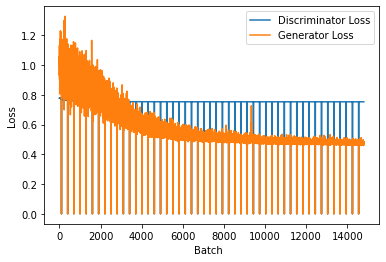

In [8]:

#Loss plot 
#print(g_loss_vector)
#print(d_loss_vector)
g_lossLine= np.zeros(steps_per_epoch*cfg.NUM_EPOCHS)
d_lossLine= np.zeros(steps_per_epoch*cfg.NUM_EPOCHS)
for i in range(cfg.NUM_EPOCHS):
    for j in range(steps_per_epoch):
        g_lossLine[j+i*300]= g_loss_vector[j,i]
        d_lossLine[j+i*300]= d_loss_vector[j,i]
       
plt.plot(d_lossLine[200:-1], label = "Discriminator Loss" )
plt.plot(g_lossLine[200:-1], label = "Generator Loss" )
plt.ylabel('Loss')
plt.xlabel('Batch  ')
plt.legend()
plt.show()


In [9]:
#print(np.mean(d_lossLine))
#print(np.mean(g_lossLine))
print("Mean discriminator the last 300 samples: ",np.mean(d_lossLine[800:-1]))
print("Mean generator the last 300 samples: ", np.mean(g_lossLine[800:-1]))
print("Variance  discriminator the last 300 samples: ",np.var(d_lossLine[800:-1]))
print("Variance generator the last 300 samples: ", np.var(g_lossLine[800:-1]))


Mean discriminator the last 300 samples:  0.7504358902091888
Mean generator the last 300 samples:  0.5615976029394781
Variance  discriminator the last 300 samples:  0.001871578015766786
Variance generator the last 300 samples:  0.016251593094894223


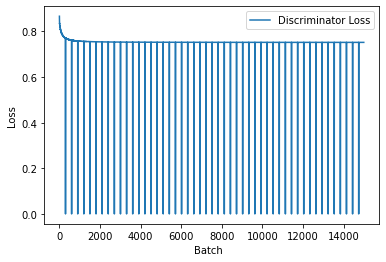

In [10]:
#plt.plot(g_lossLine, label = "Generator Loss" )
plt.plot(d_lossLine, label = "Discriminator Loss" )
plt.ylabel('Loss')
plt.xlabel('Batch  ')
plt.legend()
plt.show()